We consider the spring model
\begin{cases} 
  u'' + Cu' + Ku = 0 & t>0\\
  u(0) = 2\\
  u'(0) = -C
\end{cases}
Which has the analytical solution
\begin{align}
u(t) &= 2 e^{\frac{-Ct}{2}} cos\left(\sqrt{K-\frac{C^2}{4}}t\right)
\end{align}

###### Import modules

In [1]:
import os as os
import warnings

os.environ["OPENBLAS_NUM_THREADS"] = "1"  # Set environment variable

import sys as sys
import time as time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import seaborn as sn


with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import arviz as az
    import pymc3 as pm
    import theano.tensor as tt
    import theano
    

from numpy.linalg import inv
from scipy.interpolate import RectBivariateSpline
from scipy.integrate import odeint
from scipy.linalg import eigh
from scipy.spatial import distance_matrix
from scipy import integrate

save_folder = "spring_problem_analytical_figures/"
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

In [2]:
def pendulum_analytical_solution(C,K,t):
  # Analytical solution of u(t)
  sol = 2 * np.exp(-C*t/2) * np.cos(np.sqrt(K-C**2/4)*t)
  return sol
def dudt(C,K,t):
  # Analytical solution of u'(t)
  sol = -C*np.exp(-C*t/2)*np.cos(np.sqrt(-C**2 +4*K)*t/2) -np.exp(-C*t/2)*np.sqrt(-C**2 +4*K) * np.sin(1/2*np.sqrt(-C**2 +4*K)*t)
  return sol
def get_time(time_config):
  # Generate the time steps
  T_max = time_config[0]
  size = time_config[1]

  t = np.linspace(0, T_max, size)
  return t

Likelihood functions for Single and dual parameters

We define a likelihood where the parameters $C$ and $K$ are fed into the analytical solution. Then we can compute the negative log likelihood between that and the observed noisy data. We define $\theta = [C,K]$ for easier computation.

In [3]:
def my_loglik(C, K , data, T_max, sigma = 1.0):
  """
  This returns the log-likelihood of my_model given theta,
  datapoints, the observed data and sigma. It uses the
  model_wrapper function to do a model solve.
  """

  # Set the quadrature points.
  t = np.linspace(0, T_max, data.shape[0])

  # Solve system
  output = pendulum_analytical_solution(C,K,t)

  # Get likelihood
  likelihood = -(0.5 / sigma ** 2) * np.sum((output - data) ** 2) # negative log likelihood for gaussian
  return likelihood
class LogLike(tt.Op):
    # itypes = [tt.dvector]  # expects a vector of parameter values when called
    itypes = [tt.dvector]  # expects a scalar input
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, K_true, T_max, sigma):
        # add inputs as class attributes
        self.likelihood = loglike
        self.K = K_true
        self.T_max = T_max
        self.data = data
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        C = inputs[0]  # this will contain my variables
        # call the log-likelihood function
        logl = self.likelihood(C, self.K, self.data, self.T_max, self.sigma)
        outputs[0][0] = np.array(logl)  # output the log-likelihood

def my_loglik2(theta, data, T_max, sigma = 1.0):
  """
  This returns the log-likelihood of my_model given theta,
  datapoints, the observed data and sigma. It uses the
  model_wrapper function to do a model solve.
  """
  theta = np.array(theta).flatten()
  C,K = theta

  # Set the quadrature points..
  t = np.linspace(0, T_max, data.shape[0])

  # Solve system
  output = pendulum_analytical_solution(C,K,t)

  # Get likelihood
  likelihood = -(0.5 / sigma ** 2) * np.sum((output - data) ** 2) # negative log likelihood for gaussian
  return likelihood
# In order to use the likelihood in PyMc we need a Theano Ops function
class LogLike2(tt.Op):
    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, T_max, sigma):
        # add inputs as class attributes
        self.likelihood = loglike
        self.T_max = T_max
        self.data = data
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        # C = inputs[0][0]  # this will contain my variables
        # K = inputs[0][1]
        theta = inputs
        # call the log-likelihood function
        logl = self.likelihood(theta, self.data, self.T_max, self.sigma)
        outputs[0][0] = np.array(logl)  # output the log-likelihood

###### Analytical vs ODE solver

Here I test the difference between using the analytical solution and *odeint*. 

They give the same solution but analytical is much faster

In [ ]:
def pend(X, t, C, K):
  u, y = X
  dXdt = [y, -C*y -K*u]
  return dXdt
# Define parameters
K_true = 20.5
C_true = 1.5

# Generate training data
T_max = 5
size = 200
time_config = [T_max, size]
t = get_time(time_config)
u_analytical = pendulum_analytical_solution(C_true,K_true, t) 

# Generate points with ODEint
X0 = [2, -C_true]
u_ODE = odeint(pend, X0, t, args=(C_true, K_true))

In [ ]:
%%timeit
u_analytical = pendulum_analytical_solution(C_true,K_true, t) 

The slowest run took 6.28 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 5: 16.8 µs per loop


In [ ]:
%%timeit
u_ODE = odeint(pend, X0, t, args=(C_true, K_true))

1000 loops, best of 5: 1.51 ms per loop


In [ ]:
print("Difference:",np.max(u_analytical-u_ODE[:,0]))

Difference 5.5160938705611784e-08


# Single Parameter estimation

## Coarsity depth test

In [ ]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "single_parameter_estimation/coarsity_depth_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Generate training data
T_max = 5
size = 300
time_config = [T_max, size]
t = get_time(time_config)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0

Create coarse data for the different levels of MLMCMC

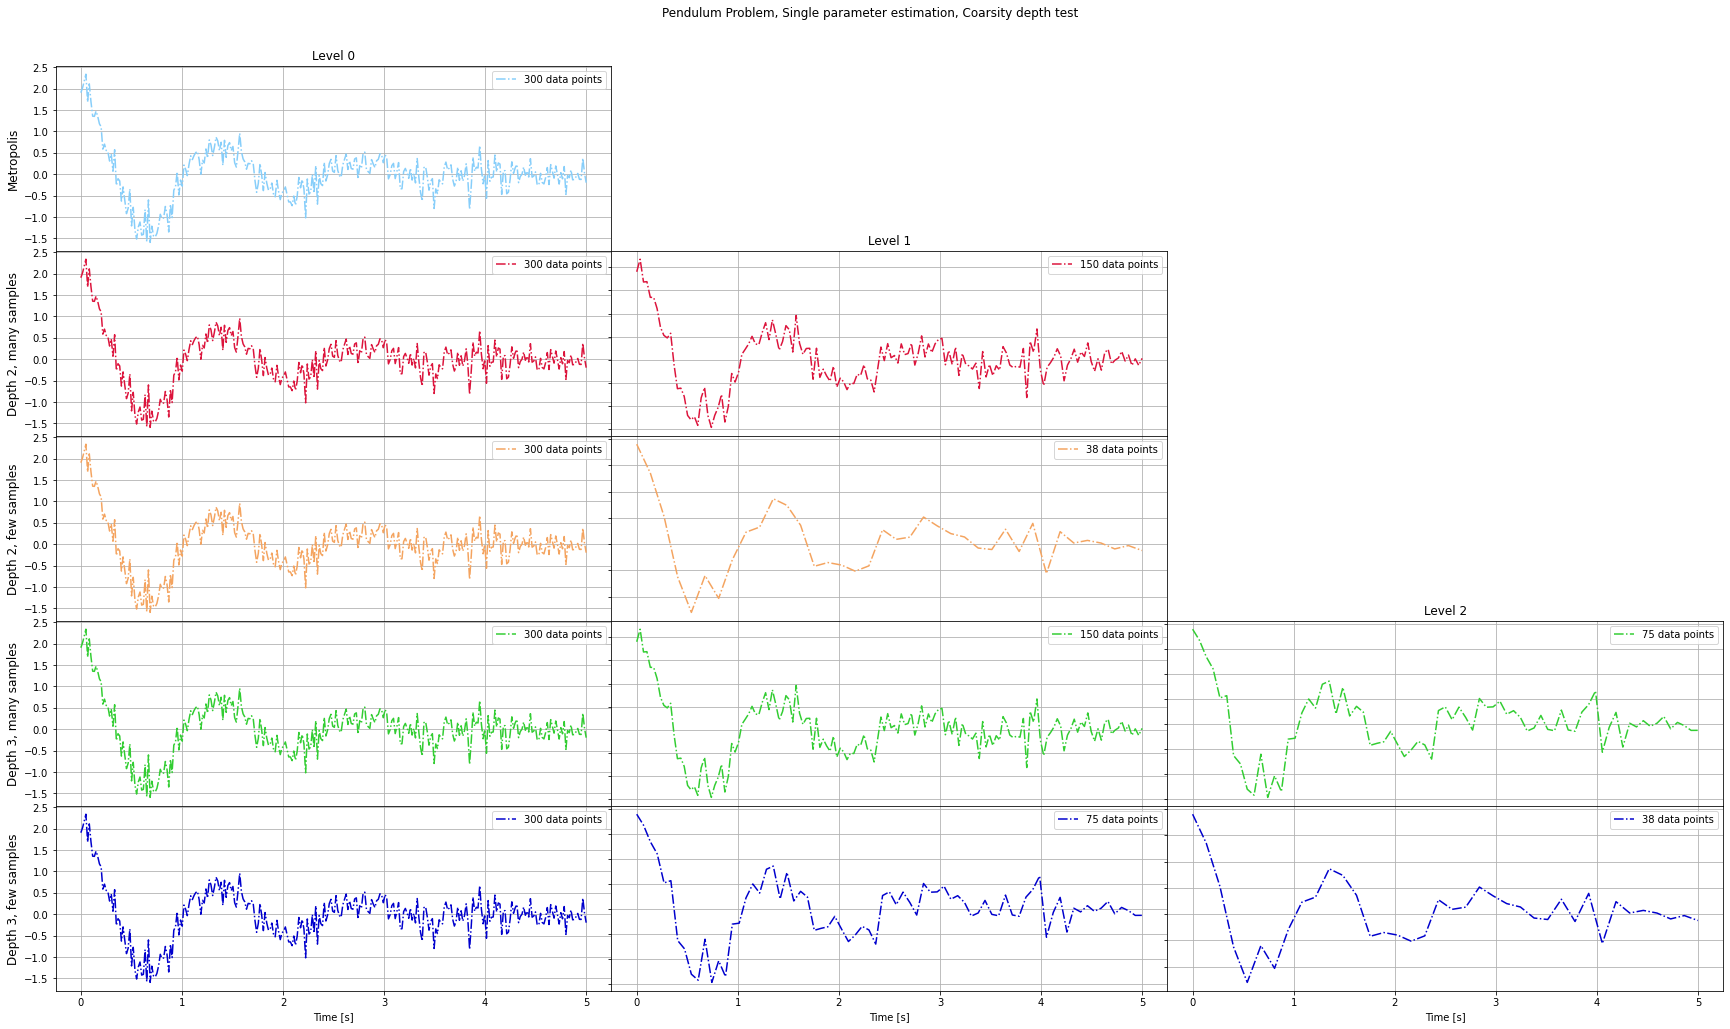

In [ ]:
datasets = []
method_names = []

# Add noise
sigma = 0.5
u_noisy = u_true + np.random.normal(0, sigma ** 2, u_true.shape)

# Dataset 1
dataset = []
dataset.append(u_noisy)
datasets.append(dataset)
method_names.append("Metropolis")

# Dataset 2
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append("Depth 2, many samples")

# Dataset 3
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::8])
datasets.append(dataset)
method_names.append("Depth 2, few samples")

# Dataset 4
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
dataset.append(u_noisy[::4])
datasets.append(dataset)
method_names.append("Depth 3, many samples")

# Dataset 5
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::4])
dataset.append(u_noisy[::8])
datasets.append(dataset)
method_names.append("Depth 3, few samples")

# for i in range(len(datasets)):
#   f,ax = plt.subplots(1,len(datasets[i]), figsize=(7*len(datasets[i]),4))
#   for j, data in enumerate(datasets[i]):
#     # print("Level "+str(j)+" has",data.shape[0],"data points")
#     if len(datasets[i]) == 1:
#       ax.plot(get_time([T_max,data.shape[0]]),data,'-.')
#       ax.set_title(f"Level {j}")
#     else:
#       ax[j].plot(get_time([T_max,data.shape[0]]),data,'-.')
#       ax[j].set_title(f"Level {j}")
#   f.suptitle(method_names[i])
#   plt.show()

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'-.',color = cols[i], label = f"{data.shape[0]} data points")
    ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Pendulum Problem, Single parameter estimation, Coarsity depth test")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)


In [ ]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:
    logl.append(LogLike(my_loglik, data, K_true, T_max, sigma = 3.0))
  logls.append(logl)

Create coarse models

In [ ]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = 0
sigma_prior = 1

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          C = pm.Normal("C", mu_prior, sigma=sigma_prior)
          C = tt.as_tensor_variable([C])

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](C))

      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)

[]
[<pymc3.model.Model object at 0x7fc1eb23cf50>, <pymc3.model.Model object at 0x7fc1f6848e90>]
[<pymc3.model.Model object at 0x7fc1ecb76950>, <pymc3.model.Model object at 0x7fc1ecfa4b50>]


Create Fine models

In [ ]:
all_fine_models = []

for i in range(len(datasets)):
  # Constructing the fine model
  with pm.Model() as fine_model:
    C = pm.Normal("C", mu_prior, sigma=sigma_prior)
    C = tt.as_tensor_variable([C])
    pm.Potential("likelihood", logls[i][0](C))
  all_fine_models.append(fine_model)

Set MCMC parameters for inference

In [ ]:
# Number of draws from the distribution
ndraws = 2000

# Number of independent chains.
nchains = 3

# Number of burn-in samples
nburn = 1000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [3,5]                 # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

In [ ]:
runtimes = []
all_traces = []
for fine_model,coarse_models in zip(all_fine_models,all_coarse_models):
  with fine_model:
    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)

      trace = pm.sample(
          draws=ndraws,
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          cores=10,
          )
    else:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)]
          )
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False
                        )
    runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  app.launch_new_instance()
Multiprocess sampling (3 chains in 10 jobs)
Metropolis: [C]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."


Total runtime: 00:11


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [C]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 22 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."


Total runtime: 00:22


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [C]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 21 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."


Total runtime: 00:21


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [C]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 117 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."


Total runtime: 01:58


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [C]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 115 seconds.


Total runtime: 01:55


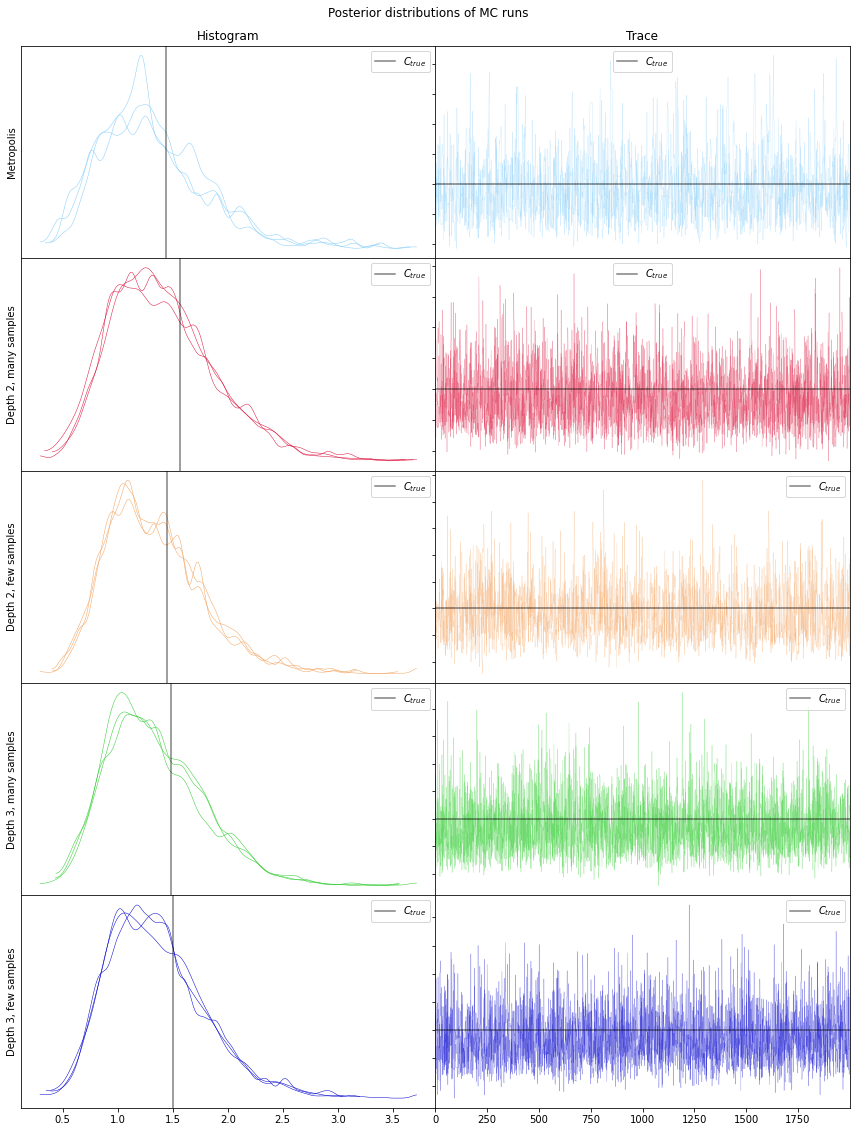

In [ ]:
# for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
#   with fine_model:
#     f,ax = plt.subplots(1,2, figsize=(10,2))
#     az.plot_trace(trace, axes = ax[None,:])
#     f.suptitle(method_names[i])
#     plt.show()

f,ax = plt.subplots(len(all_traces),2, figsize=(12,3.3*len(all_traces)))

for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    chain_prop = {"color": [cols[i], cols[i], cols[i]]}
    compact_prop={"lw": np.linspace(.5, 3, 6), "ls": ("-", "--")}
    az.plot_trace(trace, axes = ax[None,i,:], compact_prop=compact_prop, chain_prop=chain_prop)
    ax[i,0].set_ylabel(method_names[i])
    ax[i,0].set_title("")
    ax[i,1].set_title("")
    ax[i,0].axvline(x=C_true,color="k",alpha = 0.5, label=r"$C_{true}$")
    ax[i,1].axhline(y=C_true,color="k",alpha = 0.5, label=r"$C_{true}$")
    ax[i,0].legend()
    ax[i,1].legend()
for i in range(len(all_traces)):
  for j in range(2):
    if j == 0:
      if i == len(all_traces)-1:
        continue
      else:
        ax[i,j].set_xticklabels([])
    else:
      if i == len(all_traces)-1:
        ax[i,j].set_yticklabels([])
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
ax[0,0].set_title("Histogram")
ax[0,1].set_title("Trace")
f.suptitle("Posterior distributions of MC runs")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "trace_plots.png",bbox_inches='tight',dpi=300)



In [ ]:
C_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    display(az.summary(trace))
    C_hats.append(np.mean(trace['C'],axis=0))


Metropolis Sampler:
 runtime :  11.057614088058472


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.396  0.476   0.572    2.203      0.015    0.011    1165.0    1234.0    1.0


Depth 2, many samples Sampler:
 runtime :  22.833699464797974


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.36  0.446   0.566     2.17      0.009    0.007    2326.0    2502.0    1.0


Depth 2, few samples Sampler:
 runtime :  21.512435913085938


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.38  0.465   0.635    2.276      0.012    0.009    1415.0    1985.0    1.0


Depth 3, many samples Sampler:
 runtime :  118.19750881195068


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.357  0.461   0.606     2.22      0.008    0.006    3178.0    3435.0    1.0


Depth 3, few samples Sampler:
 runtime :  115.13130044937134


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.353  0.447   0.608    2.192      0.008    0.006    2768.0    2950.0    1.0

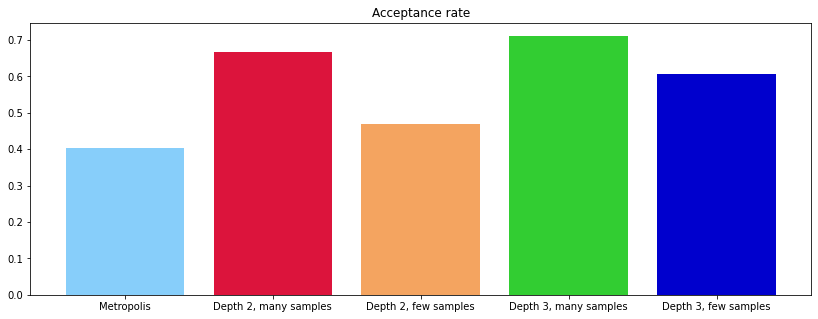

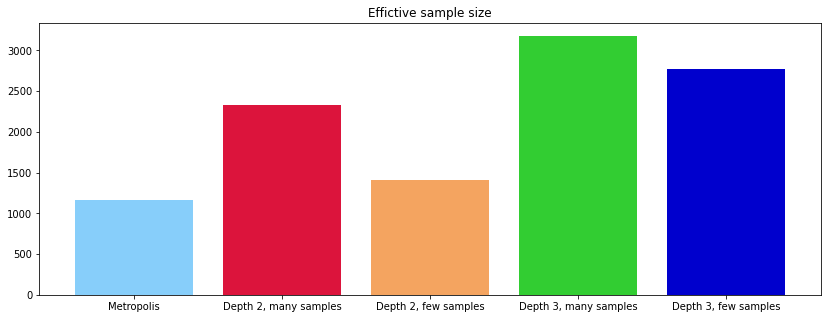

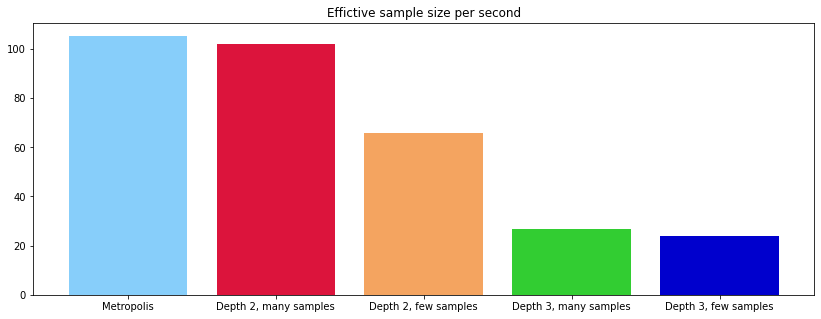

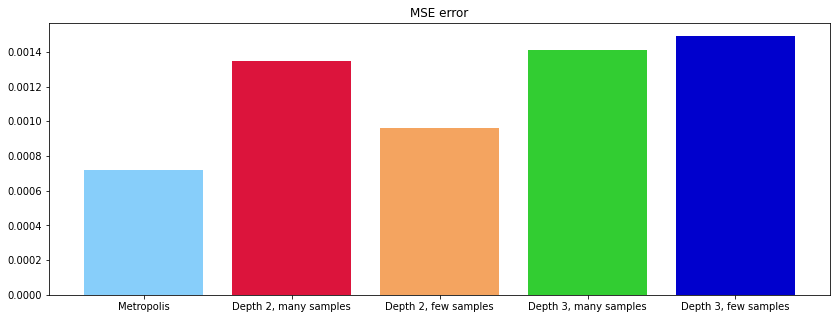

In [ ]:
# Model predictions
error = []
for C_hat in C_hats:
  u_hat = pendulum_analytical_solution(C_hat,K_true,t)
  mse = np.mean((u_true-u_hat)**2)
  error.append(mse)

# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,ess, color = cols)
ax.set_title("Effictive sample size")
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,performances, color = cols)
ax.set_title("Effictive sample size per second")
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("MSE error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

## Inital value test

In [ ]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "single_parameter_estimation/initial_value_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Generate training data
T_max = 5
size = 300
time_config = [T_max, size]
t = get_time(time_config)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0
print(C_true)

1.5


Create coarse data for the different levels of MLMCMC

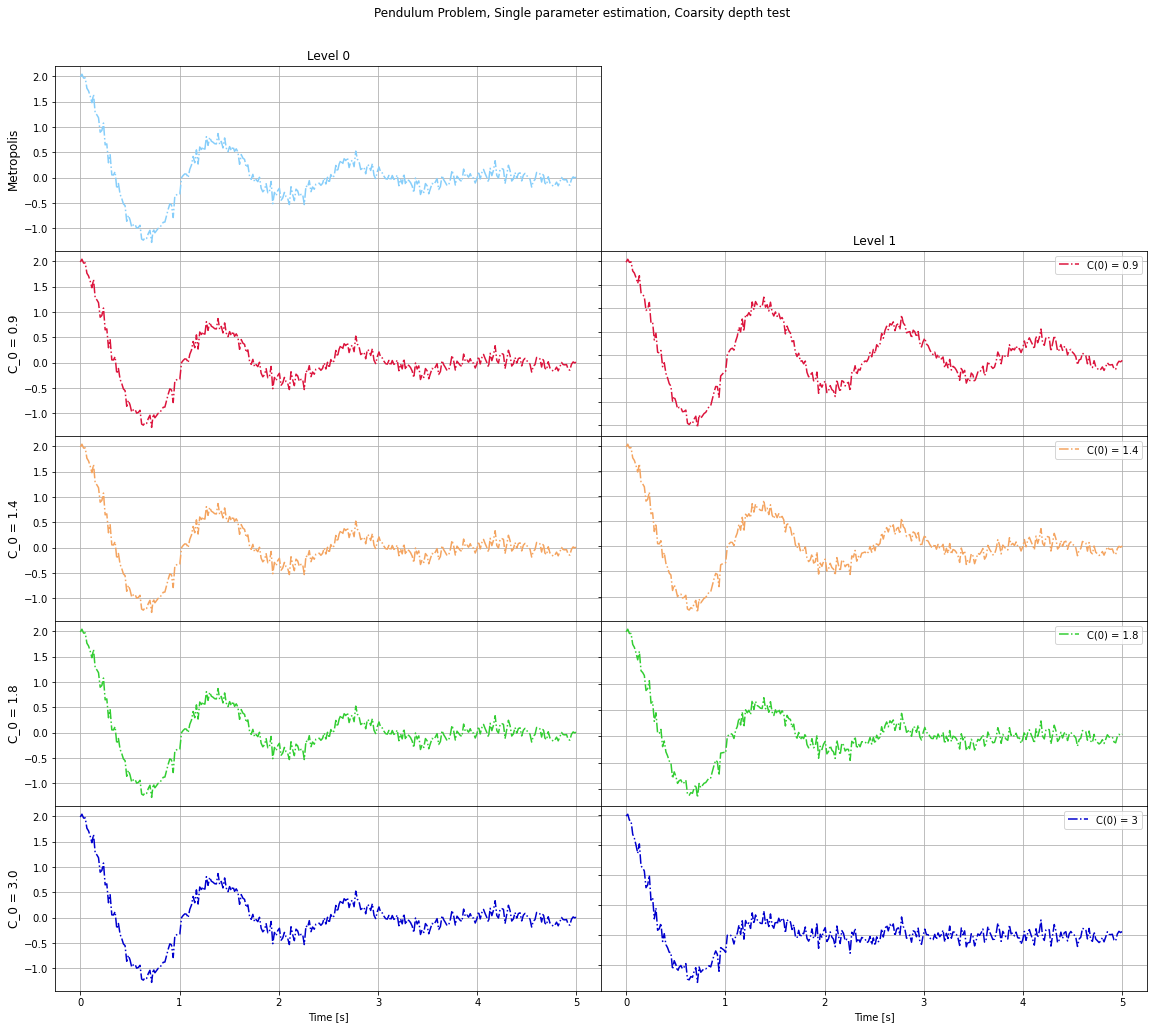

In [ ]:
datasets = []
method_names = []

# Add noise
sigma = 0.3
noise = np.random.normal(0, sigma ** 2, u_true.shape)

C_wrongs = [0.9, 1.4, 1.8, 3]
wrong_data = []
for C_wrong in C_wrongs:
  wrong_data.append(pendulum_analytical_solution(C_wrong,K_true, t))

# Dataset 1
dataset = []
dataset.append(u_true + noise)
datasets.append(dataset)
method_names.append("Metropolis")

# Dataset 2
dataset = []
dataset.append(u_true + noise)
dataset.append(wrong_data[0] + noise)
datasets.append(dataset)
method_names.append(r"C_0 = 0.9")

# Dataset 2
dataset = []
dataset.append(u_true + noise)
dataset.append(wrong_data[1] + noise)
datasets.append(dataset)
method_names.append(r"C_0 = 1.4")

# Dataset 2
dataset = []
dataset.append(u_true + noise)
dataset.append(wrong_data[2] + noise)
datasets.append(dataset)
method_names.append(r"C_0 = 1.8")

# Dataset 2
dataset = []
dataset.append(u_true + noise)
dataset.append(wrong_data[3] + noise)
datasets.append(dataset)
method_names.append(r"C_0 = 3.0")

# for i in range(len(datasets)):
#   f,ax = plt.subplots(1,len(datasets[i]), figsize=(7*len(datasets[i]),3))
#   for j, data in enumerate(datasets[i]):
#     if len(datasets[i]) == 1:
#       ax.plot(t,data)
#       ax.set_title(f"Level {j}")
#     else:
#       ax[j].plot(t,data)
#       ax[j].set_title(f"Level {j}")
#   f.suptitle(method_names[i])
#   plt.show()

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    if j != 0:
      ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'-.',color = cols[i], label = rf"C(0) = {C_wrongs[i-1]}")
      ax[i,j].legend()
    else:
      ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'-.',color = cols[i])
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Pendulum Problem, Single parameter estimation, Coarsity depth test")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)

In [ ]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:
    logl.append(LogLike(my_loglik, data, K_true, T_max, sigma = 3.0))
  logls.append(logl)

Create coarse models

In [ ]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = 0
sigma_prior = 1

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          C = pm.Normal("C", mu_prior, sigma=sigma_prior)
          C = tt.as_tensor_variable([C])

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](C))

      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)

[]


Create Fine models

In [ ]:
all_fine_models = []

for i in range(len(datasets)):
  # Constructing the fine model
  with pm.Model() as fine_model:
    C = pm.Normal("C", mu_prior, sigma=sigma_prior)
    C = tt.as_tensor_variable([C])
    pm.Potential("likelihood", logls[i][0](C))
  all_fine_models.append(fine_model)

Set MCMC parameters for inference

In [ ]:
# Number of draws from the distribution
ndraws = 2000

# Number of independent chains.
nchains = 3

# Number of burn-in samples
nburn = 1000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [5]                 # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

In [ ]:
runtimes = []
all_traces = []
for fine_model,coarse_models in zip(all_fine_models,all_coarse_models):
  with fine_model:
    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)

      trace = pm.sample(
          draws=ndraws,
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          cores=10,
          )
    else:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)]
          )
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False
                        )
    runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  app.launch_new_instance()
Multiprocess sampling (3 chains in 10 jobs)
Metropolis: [C]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 4 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [C]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 26 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [C]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 25 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [C]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 26 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [C]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 25 seconds.
The number of effective samples is smaller than 25% for some parameters.


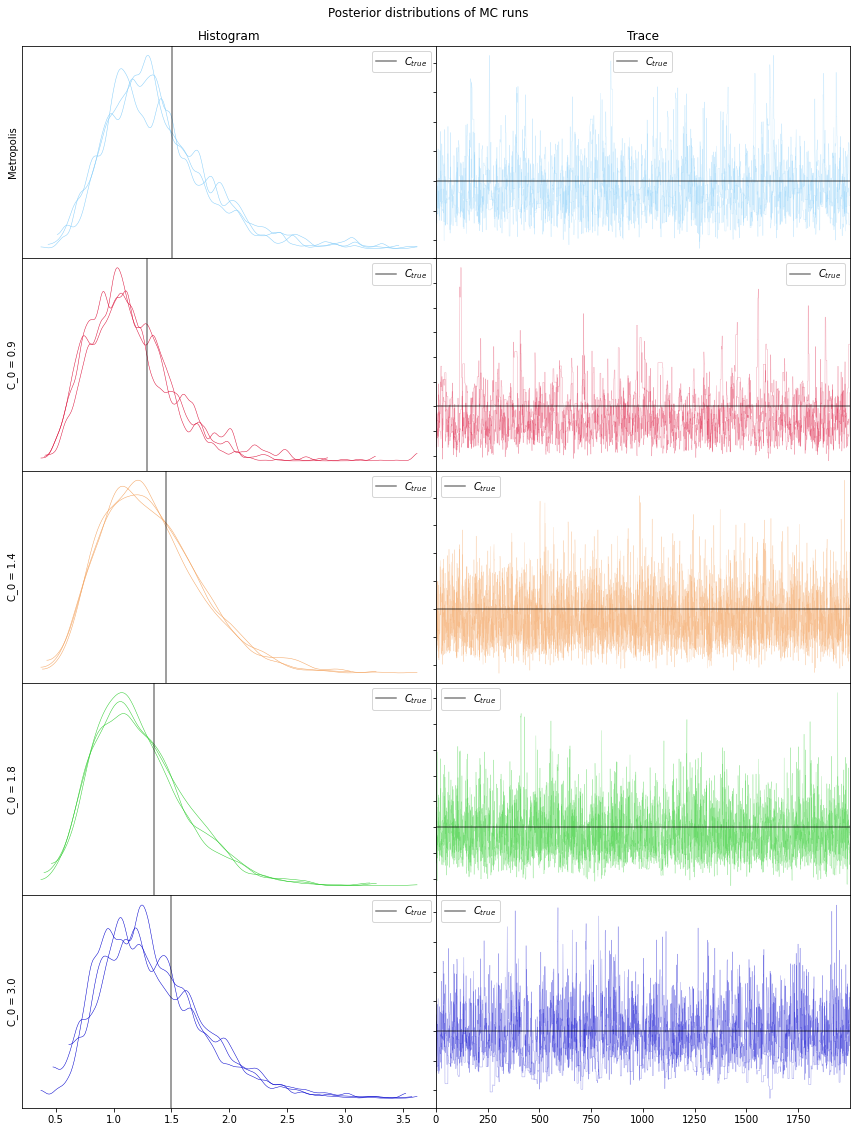

In [ ]:
# for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
#   with fine_model:
#     f,ax = plt.subplots(1,2, figsize=(10,2))
#     az.plot_trace(trace, axes = ax[None,:])
#     f.suptitle(method_names[i])
#     plt.show()

f,ax = plt.subplots(len(all_traces),2, figsize=(12,3.3*len(all_traces)))

for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    chain_prop = {"color": [cols[i], cols[i], cols[i]]}
    compact_prop={"lw": np.linspace(.5, 3, 6), "ls": ("-", "--")}
    az.plot_trace(trace, axes = ax[None,i,:], compact_prop=compact_prop, chain_prop=chain_prop)
    ax[i,0].set_ylabel(method_names[i])
    ax[i,0].set_title("")
    ax[i,1].set_title("")
    ax[i,0].axvline(x=C_true,color="k",alpha = 0.5, label=r"$C_{true}$")
    ax[i,1].axhline(y=C_true,color="k",alpha = 0.5, label=r"$C_{true}$")
    ax[i,0].legend()
    ax[i,1].legend()
for i in range(len(all_traces)):
  for j in range(2):
    if j == 0:
      if i == len(all_traces)-1:
        continue
      else:
        ax[i,j].set_xticklabels([])
    else:
      if i == len(all_traces)-1:
        ax[i,j].set_yticklabels([])
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
ax[0,0].set_title("Histogram")
ax[0,1].set_title("Trace")
f.suptitle("Posterior distributions of MC runs")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "trace_plots.png",bbox_inches='tight',dpi=300)

In [ ]:
C_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    display(az.summary(trace))
    C_hats.append(np.mean(trace['C'],axis=0))


Metropolis Sampler:
 runtime :  5.537701845169067


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.369  0.457   0.597    2.188      0.014     0.01    1270.0    1053.0    1.0


C_0 = 0.9 Sampler:
 runtime :  26.313443660736084


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.338  0.462   0.544    2.122      0.018    0.013     785.0     624.0   1.01


C_0 = 1.4 Sampler:
 runtime :  25.72620391845703


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.361  0.46   0.621    2.238      0.008    0.006    3635.0    3325.0    1.0


C_0 = 1.8 Sampler:
 runtime :  26.18178415298462


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.357  0.464   0.625     2.26      0.009    0.006    2744.0    1708.0    1.0


C_0 = 3.0 Sampler:
 runtime :  25.277305841445923


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.338  0.454   0.592    2.179      0.015     0.01     731.0     561.0    1.0

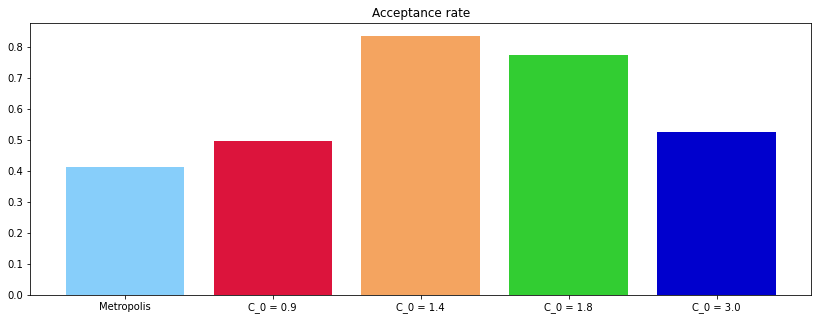

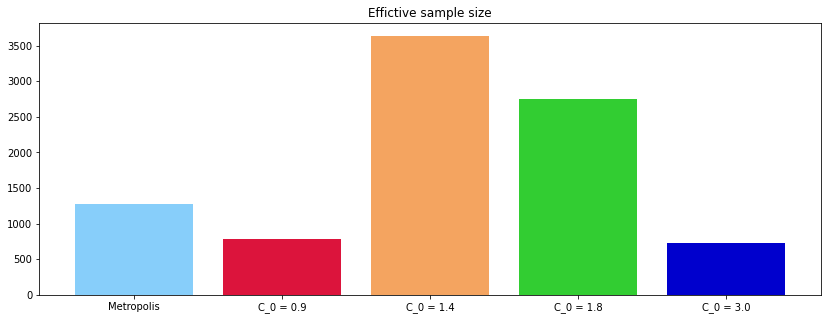

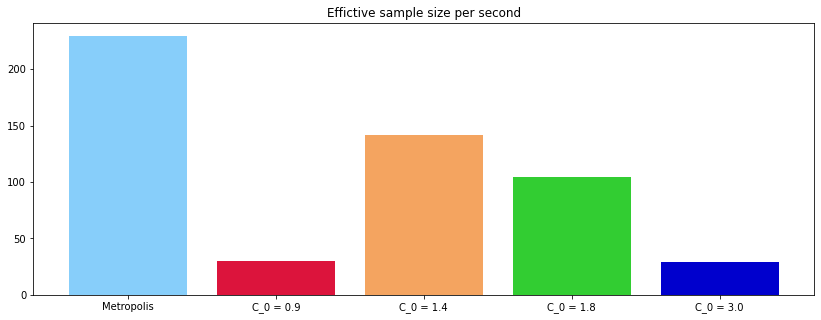

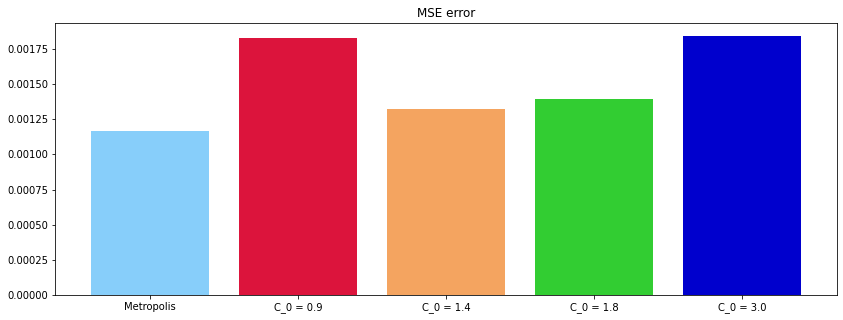

In [ ]:
# Model predictions
error = []
for C_hat in C_hats:
  u_hat = pendulum_analytical_solution(C_hat,K_true,t)
  mse = np.mean((u_true-u_hat)**2)
  error.append(mse)

# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,ess, color = cols)
ax.set_title("Effictive sample size")
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,performances, color = cols)
ax.set_title("Effictive sample size per second")
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("MSE error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

## Increasing level variance test

In [ ]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "single_parameter_estimation/increasing_level_variance_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Generate training data
T_max = 5
size = 300
time_config = [T_max, size]
t = get_time(time_config)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0

Create coarse data for the different levels of MLMCMC

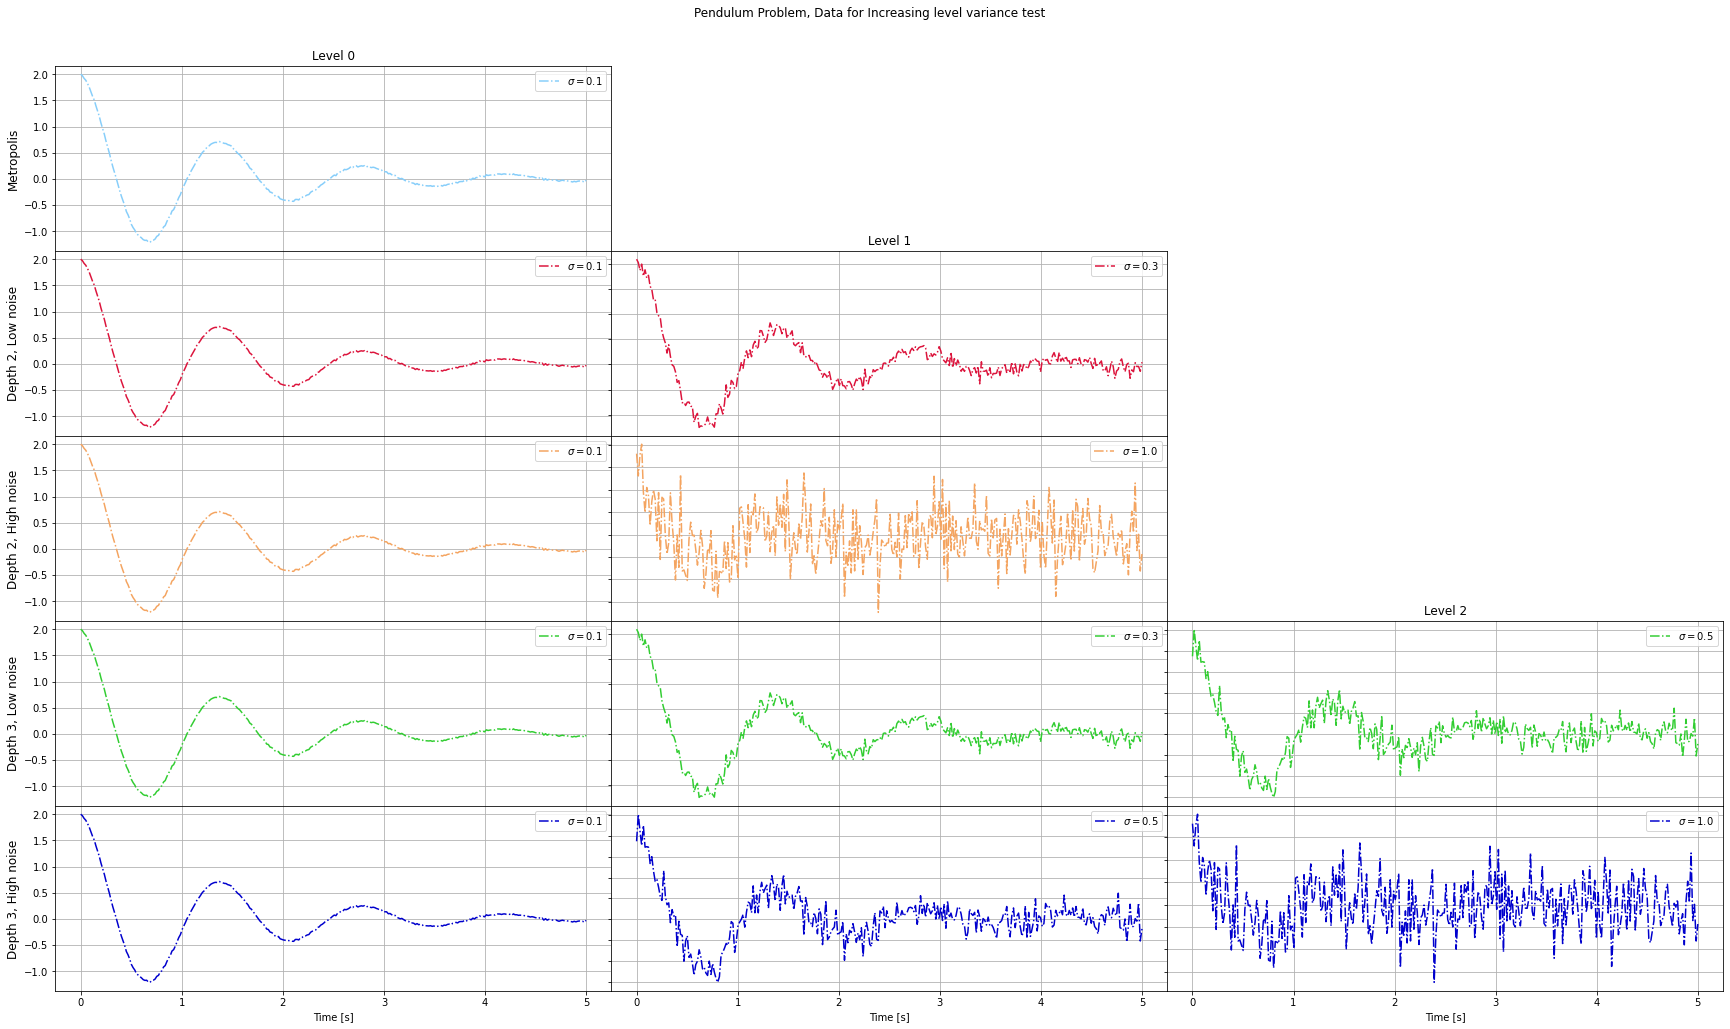

In [ ]:
datasets = []
method_names = []


# Add noise
sigmas = [0.1, 0.3, 0.5, 1.0]
noices = []
for sigma in sigmas:
  noices.append(np.random.normal(0, sigma ** 2, u_true.shape))

# Dataset 1
dataset = []
dataset.append(u_true + noices[0])
datasets.append(dataset)
method_names.append("Metropolis")

# Dataset 2
dataset = []
dataset.append(u_true + noices[0])
dataset.append(u_true + noices[1])
datasets.append(dataset)
method_names.append("Depth 2, Low noise")

# Dataset 3
dataset = []
dataset.append(u_true + noices[0])
dataset.append(u_true + noices[3])
datasets.append(dataset)
method_names.append("Depth 2, High noise")

# Dataset 4
dataset = []
dataset.append(u_true + noices[0])
dataset.append(u_true + noices[1])
dataset.append(u_true + noices[2])
datasets.append(dataset)
method_names.append("Depth 3, Low noise")

# Dataset 5
dataset = []
dataset.append(u_true + noices[0])
dataset.append(u_true + noices[2])
dataset.append(u_true + noices[3])
datasets.append(dataset)
method_names.append("Depth 3, High noise")


# for i in range(len(datasets)):
#   f,ax = plt.subplots(1,len(datasets[i]), figsize=(9*len(datasets[i]),4))
#   for j, data in enumerate(datasets[i]):
#     ax[j].plot(t,data)
#     ax[j].set_title(f"Level {j}")
#   f.suptitle(method_names[i])
#   plt.show()

SIGMAS = np.zeros((len(datasets),max_len))
SIGMAS[:,0] = sigmas[0]
SIGMAS[1,1] = sigmas[1]
SIGMAS[3,1] = sigmas[1]
SIGMAS[3,2] = sigmas[2]
SIGMAS[4,1] = sigmas[2]
SIGMAS[2,1] = sigmas[3]
SIGMAS[4,2] = sigmas[3]

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'-.',color = cols[i], label = rf"$\sigma = {SIGMAS[i,j]}$")
    ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Pendulum Problem, Data for Increasing level variance test")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)


In [ ]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:
    logl.append(LogLike(my_loglik, data, K_true, T_max, sigma = 3.0))
  logls.append(logl)

Create coarse models

In [ ]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = 0
sigma_prior = 1

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          C = pm.Normal("C", mu_prior, sigma=sigma_prior)
          C = tt.as_tensor_variable([C])

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](C))

      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)

[]
[<pymc3.model.Model object at 0x7fc1ec19e710>, <pymc3.model.Model object at 0x7fc1f659d750>]
[<pymc3.model.Model object at 0x7fc1ecbe4110>, <pymc3.model.Model object at 0x7fc1e1747d90>]


Create Fine models

In [ ]:
all_fine_models = []

for i in range(len(datasets)):
  # Constructing the fine model
  with pm.Model() as fine_model:
    C = pm.Normal("C", mu_prior, sigma=sigma_prior)
    C = tt.as_tensor_variable([C])
    pm.Potential("likelihood", logls[i][0](C))
  all_fine_models.append(fine_model)

Set MCMC parameters for inference

In [ ]:
# Number of draws from the distribution
ndraws = 2000

# Number of independent chains.
nchains = 3

# Number of burn-in samples
nburn = 1000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [3,5]                 # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

In [ ]:
runtimes = []
all_traces = []
for fine_model,coarse_models in zip(all_fine_models,all_coarse_models):
  with fine_model:
    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)

      trace = pm.sample(
          draws=ndraws,
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          cores=10,
          )
    else:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)]
          )
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False
                        )
    runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  app.launch_new_instance()
Multiprocess sampling (3 chains in 10 jobs)
Metropolis: [C]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [C]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 22 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [C]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 23 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [C]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 120 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [C]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 119 seconds.


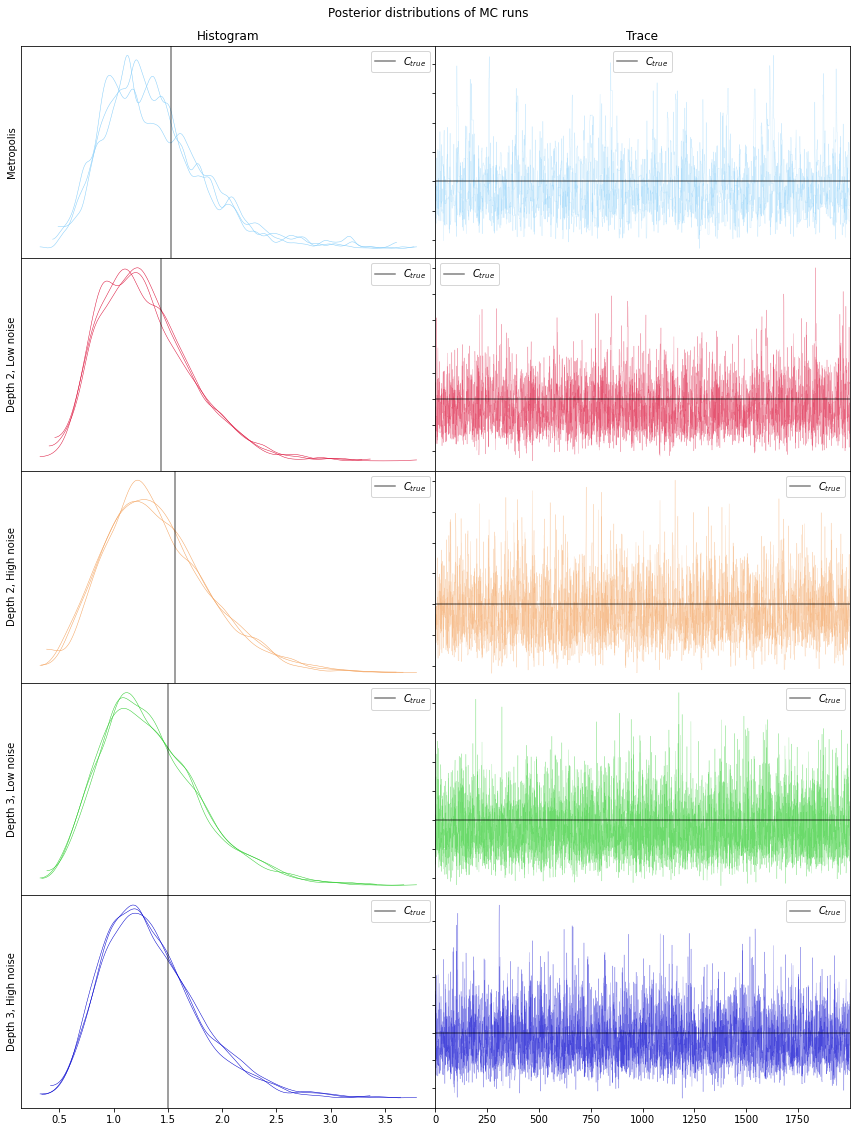

In [ ]:
# for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
#   with fine_model:
#     f,ax = plt.subplots(1,2, figsize=(10,2))
#     az.plot_trace(trace, axes = ax[None,:])
#     f.suptitle(method_names[i])
#     plt.show()
f,ax = plt.subplots(len(all_traces),2, figsize=(12,3.3*len(all_traces)))

for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    chain_prop = {"color": [cols[i], cols[i], cols[i]]}
    compact_prop={"lw": np.linspace(.5, 3, 6), "ls": ("-", "--")}
    az.plot_trace(trace, axes = ax[None,i,:], compact_prop=compact_prop, chain_prop=chain_prop)
    ax[i,0].set_ylabel(method_names[i])
    ax[i,0].set_title("")
    ax[i,1].set_title("")
    ax[i,0].axvline(x=C_true,color="k",alpha = 0.5, label=r"$C_{true}$")
    ax[i,1].axhline(y=C_true,color="k",alpha = 0.5, label=r"$C_{true}$")
    ax[i,0].legend()
    ax[i,1].legend()
for i in range(len(all_traces)):
  for j in range(2):
    if j == 0:
      if i == len(all_traces)-1:
        continue
      else:
        ax[i,j].set_xticklabels([])
    else:
      if i == len(all_traces)-1:
        ax[i,j].set_yticklabels([])
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
ax[0,0].set_title("Histogram")
ax[0,1].set_title("Trace")
f.suptitle("Posterior distributions of MC runs")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "trace_plots.png",bbox_inches='tight',dpi=300)

In [ ]:
C_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    display(az.summary(trace))
    C_hats.append(np.mean(trace['C'],axis=0))


Metropolis Sampler:
 runtime :  5.014919757843018


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.365  0.462     0.6    2.204      0.014     0.01    1229.0    1005.0    1.0


Depth 2, Low noise Sampler:
 runtime :  22.7639319896698


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.345  0.461   0.594     2.22      0.009    0.006    3031.0    2869.0    1.0


Depth 2, High noise Sampler:
 runtime :  23.10368537902832


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.354  0.446   0.574    2.179      0.009    0.006    2481.0    2058.0    1.0


Depth 3, Low noise Sampler:
 runtime :  120.73036360740662


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.353  0.457   0.603    2.247      0.006    0.004    5687.0    5195.0    1.0


Depth 3, High noise Sampler:
 runtime :  119.89278745651245


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.348  0.453   0.595     2.19      0.007    0.005    3756.0    2906.0    1.0

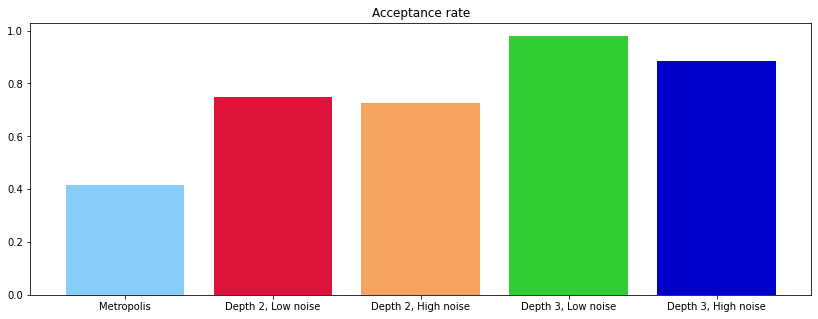

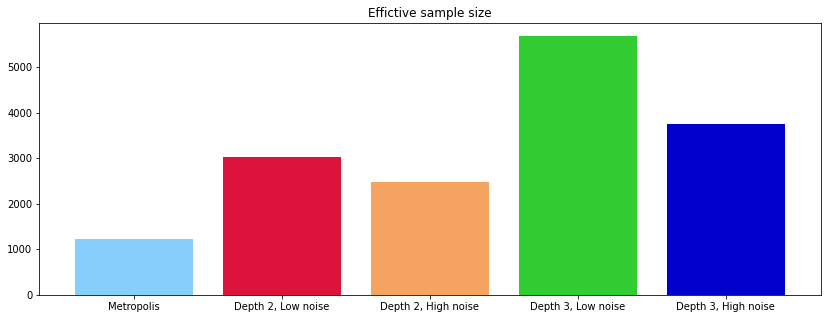

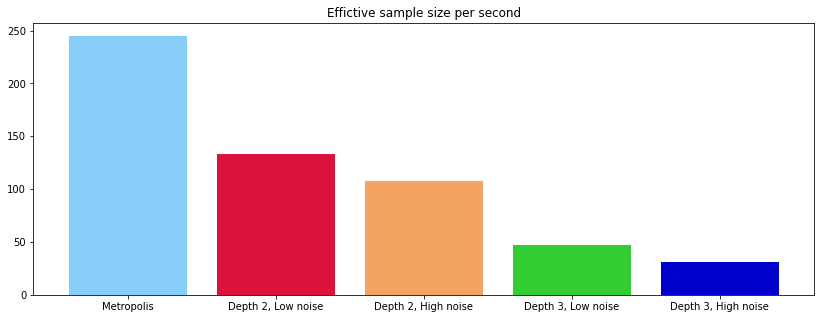

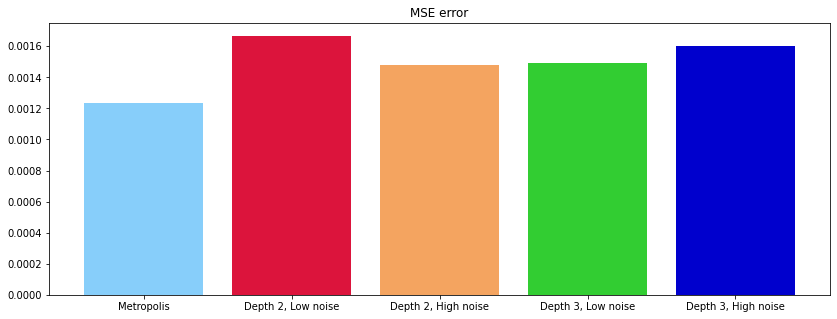

In [ ]:
# Model predictions
error = []
for C_hat in C_hats:
  u_hat = pendulum_analytical_solution(C_hat,K_true,t)
  mse = np.mean((u_true-u_hat)**2)
  error.append(mse)

# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,ess, color = cols)
ax.set_title("Effictive sample size")
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,performances, color = cols)
ax.set_title("Effictive sample size per second")
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("MSE error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

## Proposal Variance test

In [ ]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "single_parameter_estimation/proposal_variance_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Generate training data
T_max = 5
size = 300
time_config = [T_max, size]
t = get_time(time_config)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0

Create coarse data for the different levels of MLMCMC

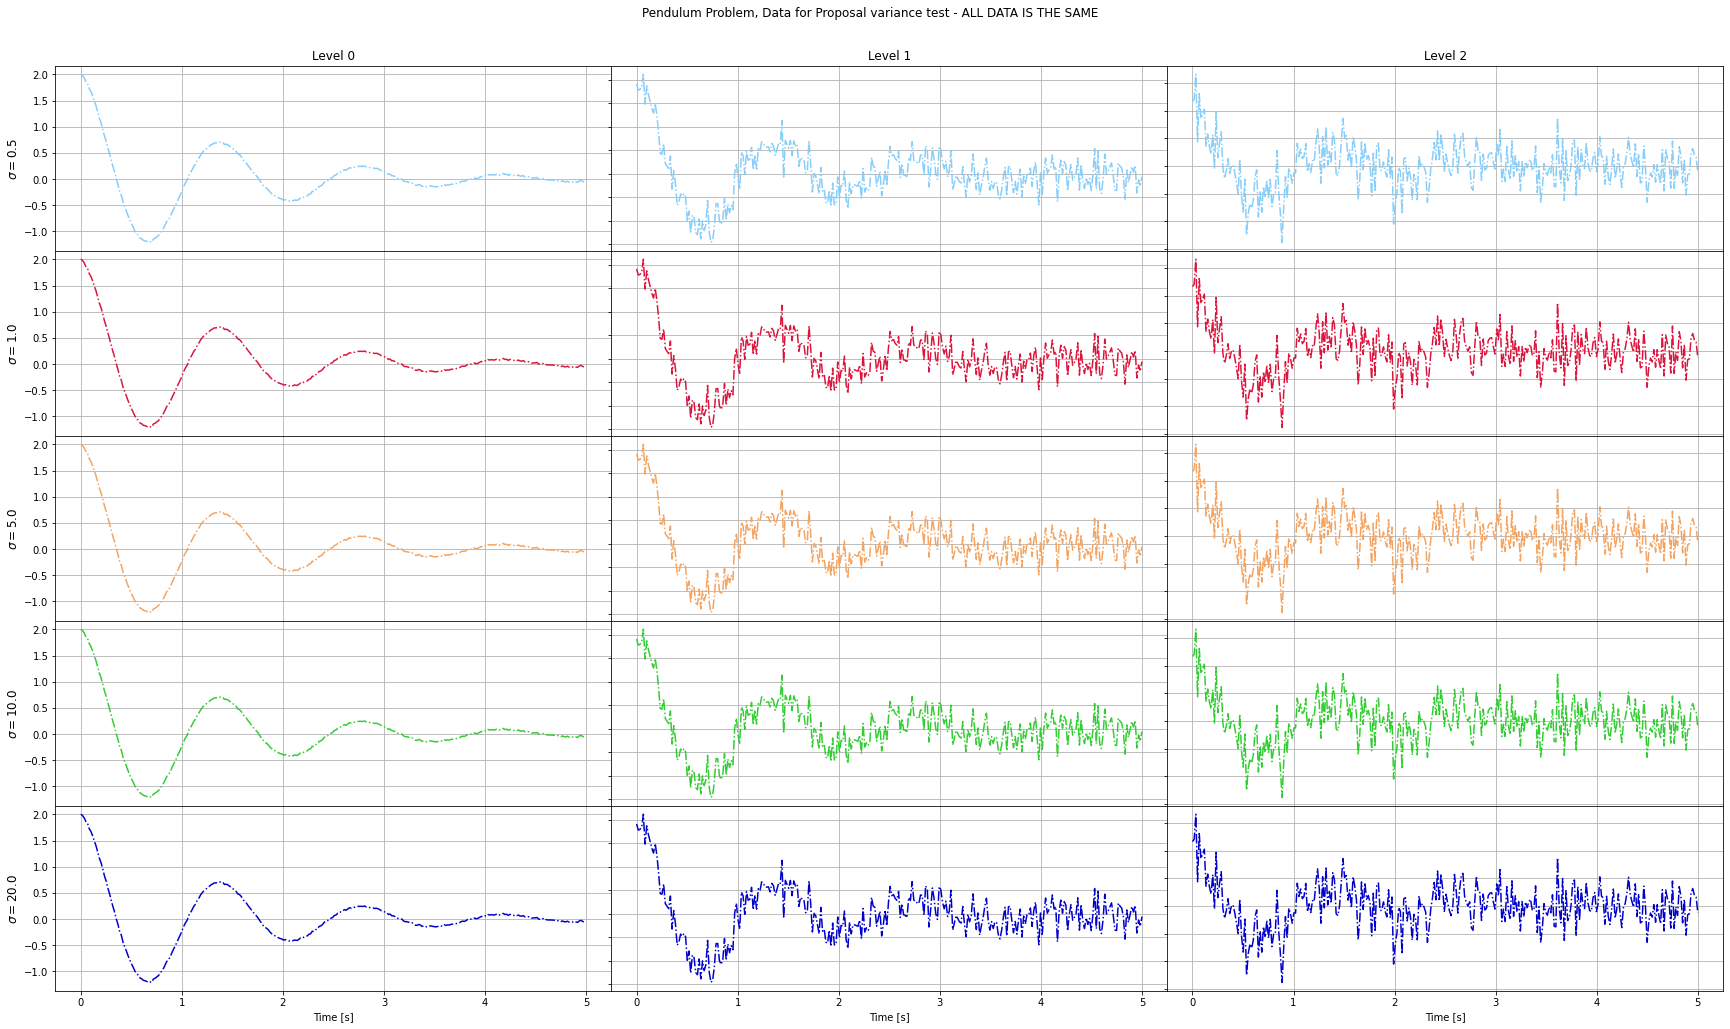

In [ ]:
datasets = []
method_names = []


# Add noise
sigmas = [0.1, 0.5, 0.8]
noices = []
for sigma in sigmas:
  noices.append(np.random.normal(0, sigma ** 2, u_true.shape))


# Dataset 1
dataset = []
dataset.append(u_true + noices[0])
dataset.append(u_true + noices[1])
dataset.append(u_true + noices[2])
datasets.append(dataset)
method_names.append(r"$\sigma = 0.5$")

# Dataset 1
dataset = []
dataset.append(u_true + noices[0])
dataset.append(u_true + noices[1])
dataset.append(u_true + noices[2])
datasets.append(dataset)
method_names.append(r"$\sigma = 1.0$")

# Dataset 1
dataset = []
dataset.append(u_true + noices[0])
dataset.append(u_true + noices[1])
dataset.append(u_true + noices[2])
datasets.append(dataset)
method_names.append(r"$\sigma = 5.0$")

# Dataset 1
dataset = []
dataset.append(u_true + noices[0])
dataset.append(u_true + noices[1])
dataset.append(u_true + noices[2])
datasets.append(dataset)
method_names.append(r"$\sigma = 10.0$")

# Dataset 1
dataset = []
dataset.append(u_true + noices[0])
dataset.append(u_true + noices[1])
dataset.append(u_true + noices[2])
datasets.append(dataset)
method_names.append(r"$\sigma = 20.0$")

# for i in range(len(datasets)):
#   f,ax = plt.subplots(1,len(datasets[i]), figsize=(9*len(datasets[i]),4))
#   for j, data in enumerate(datasets[i]):
#     ax[j].plot(t,data)
#     ax[j].set_title(f"Level {j}")
#   f.suptitle(method_names[i])
#   plt.show()
cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'-.',color = cols[i])
    # ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Pendulum Problem, Data for Proposal variance test - ALL DATA IS THE SAME")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)

In [ ]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:
    logl.append(LogLike(my_loglik, data, K_true, T_max, sigma = 3.0))
  logls.append(logl)

Create coarse models

In [ ]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = 0
sigma_priors = [0.5, 1, 5, 10, 20]

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          C = pm.Normal("C", mu_prior, sigma=sigma_priors[i])
          C = tt.as_tensor_variable([C])

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](C))

      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)

[<pymc3.model.Model object at 0x7fc1f637e1d0>, <pymc3.model.Model object at 0x7fc1ebc89090>]
[<pymc3.model.Model object at 0x7fc1f65fb610>, <pymc3.model.Model object at 0x7fc1eccdbe90>]
[<pymc3.model.Model object at 0x7fc1ebedf4d0>, <pymc3.model.Model object at 0x7fc1ec42db50>]
[<pymc3.model.Model object at 0x7fc1e1e346d0>, <pymc3.model.Model object at 0x7fc1ec285b50>]
[<pymc3.model.Model object at 0x7fc1ec955dd0>, <pymc3.model.Model object at 0x7fc1ec955a90>]


Create Fine models

In [ ]:
all_fine_models = []

for i in range(len(datasets)):
  # Constructing the fine model
  with pm.Model() as fine_model:
    C = pm.Normal("C", mu_prior, sigma=sigma_priors[i])
    C = tt.as_tensor_variable([C])
    pm.Potential("likelihood", logls[i][0](C))
  all_fine_models.append(fine_model)

Set MCMC parameters for inference

In [ ]:
# Number of draws from the distribution
ndraws = 2000

# Number of independent chains.
nchains = 3

# Number of burn-in samples
nburn = 1000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [3,5]                 # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

In [ ]:
runtimes = []
all_traces = []
for fine_model,coarse_models in zip(all_fine_models,all_coarse_models):
  with fine_model:
    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)

      trace = pm.sample(
          draws=ndraws,
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          cores=10,
          )
    else:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)]
          )
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False
                        )
    runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [C]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 121 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [C]


Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 119 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [C]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 121 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiproces

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 118 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiproces

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
Sampling 3 chains for 1_000 tune and 2_000 draw iterations (3_000 + 6_000 draws total) took 119 seconds.


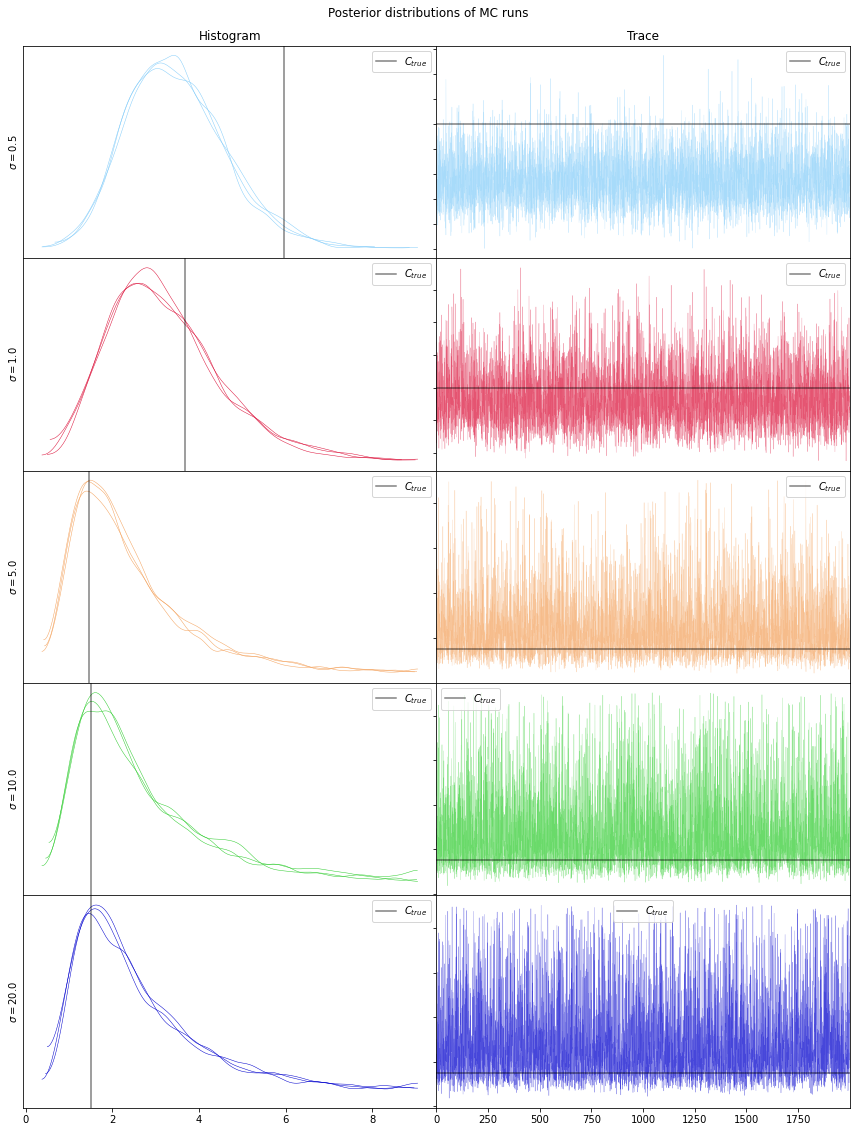

In [ ]:
# for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
#   with fine_model:
#     f,ax = plt.subplots(1,2, figsize=(10,2))
#     az.plot_trace(trace, axes = ax[None,:])
#     f.suptitle(method_names[i])
#     plt.show()
f,ax = plt.subplots(len(all_traces),2, figsize=(12,3.3*len(all_traces)))

for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    chain_prop = {"color": [cols[i], cols[i], cols[i]]}
    compact_prop={"lw": np.linspace(.5, 3, 6), "ls": ("-", "--")}
    az.plot_trace(trace, axes = ax[None,i,:], compact_prop=compact_prop, chain_prop=chain_prop)
    ax[i,0].set_ylabel(method_names[i])
    ax[i,0].set_title("")
    ax[i,1].set_title("")
    ax[i,0].axvline(x=C_true,color="k",alpha = 0.5, label=r"$C_{true}$")
    ax[i,1].axhline(y=C_true,color="k",alpha = 0.5, label=r"$C_{true}$")
    ax[i,0].legend()
    ax[i,1].legend()
for i in range(len(all_traces)):
  for j in range(2):
    if j == 0:
      if i == len(all_traces)-1:
        continue
      else:
        ax[i,j].set_xticklabels([])
    else:
      if i == len(all_traces)-1:
        ax[i,j].set_yticklabels([])
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
ax[0,0].set_title("Histogram")
ax[0,1].set_title("Trace")
f.suptitle("Posterior distributions of MC runs")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "trace_plots.png",bbox_inches='tight',dpi=300)

In [ ]:
C_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    display(az.summary(trace))
    C_hats.append(np.mean(trace['C'],axis=0))


$\sigma = 0.5$ Sampler:
 runtime :  121.92383122444153


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  0.948  0.256   0.508    1.447      0.003    0.002    5897.0    5704.0    1.0


$\sigma = 1.0$ Sampler:
 runtime :  119.49774956703186


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  1.345  0.45   0.545     2.15      0.006    0.004    5527.0    5624.0    1.0


$\sigma = 5.0$ Sampler:
 runtime :  121.4145154953003


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  2.451  1.409   0.605    5.222      0.019    0.014    5376.0    5229.0    1.0


$\sigma = 10.0$ Sampler:
 runtime :  119.05885553359985


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  2.78  1.719   0.586    6.308      0.024    0.018    5296.0    5005.0    1.0


$\sigma = 20.0$ Sampler:
 runtime :  119.99268984794617


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C  2.859  1.797   0.637    6.635      0.025    0.018    5014.0    5402.0    1.0

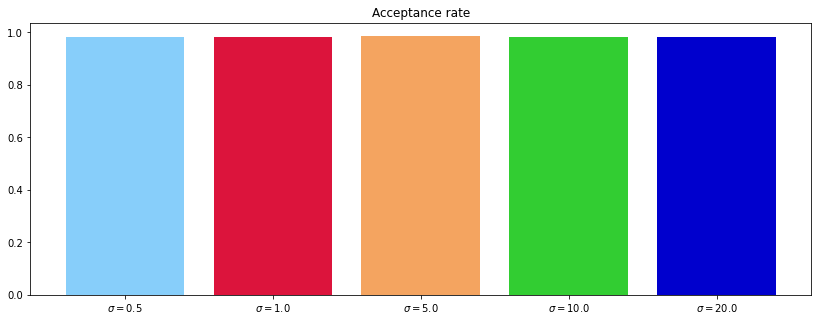

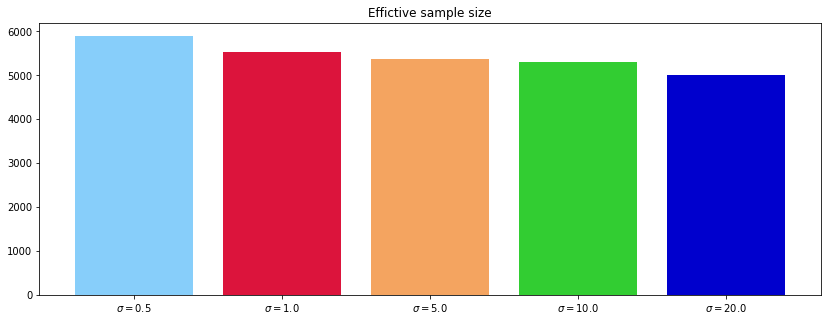

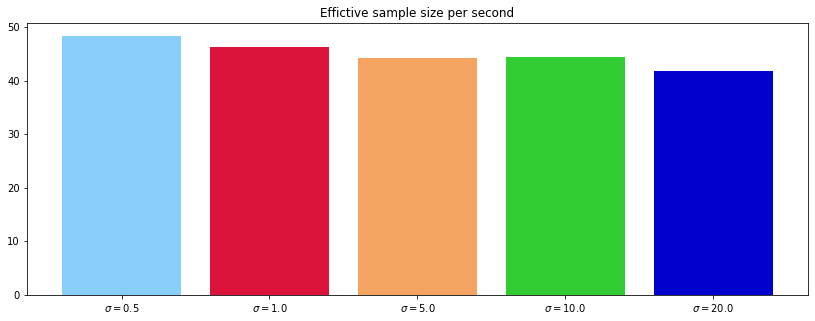

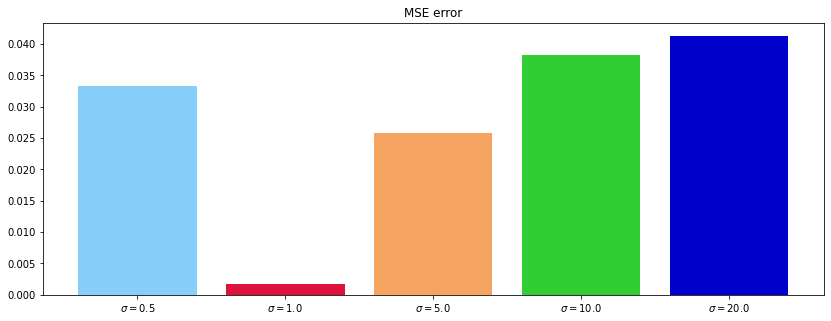

In [ ]:
# Model predictions
error = []
for C_hat in C_hats:
  u_hat = pendulum_analytical_solution(C_hat,K_true,t)
  mse = np.mean((u_true-u_hat)**2)
  error.append(mse)

# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,ess, color = cols)
ax.set_title("Effictive sample size")
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,performances, color = cols)
ax.set_title("Effictive sample size per second")
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("MSE error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

# Dual Parameter estimation

In this section we estimate both $K$ and $C$

## Problem visualization

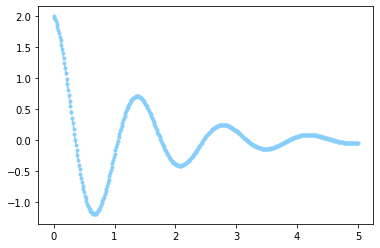

In [ ]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)
image_folder = save_folder + "problem_visualization/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)
# Define parameters
K_true = 20.5
C_true = 1.5
# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0
# Generate training data
T_max = 5
size = 400
time_config = [T_max, size]
t = get_time(time_config)
u_true = pendulum_analytical_solution(C_true,K_true, t) 
# Add noise
sigma = 0.0
DATA = u_true + np.random.normal(0, sigma ** 2, u_true.shape)
plt.plot(get_time([T_max,DATA.shape[0]]),DATA,'--.',color = "lightskyblue")

In [ ]:
N_pointsC = 100
N_pointsK = 100
# K_xy = [19,23]
# C_xy = [1,2]
N = 4
K_xy = [K_true-N,K_true+N]
C_xy = [C_true-0.7,C_true+N]
Ks = np.linspace(K_xy[0],K_xy[1],N_pointsK)
Cs = np.linspace(C_xy[0],C_xy[1],N_pointsC)

grid1 = np.zeros((N_pointsK,N_pointsC))
grid2 = np.zeros((N_pointsK,N_pointsC))
grid3 = np.zeros((N_pointsK,N_pointsC))
sigma1 = 0.3
sigma2 = 1.0
sigma3 = 3.0
for i,K in enumerate(Ks):
  for j,C in enumerate(Cs):
    like1 = my_loglik2([C,K],DATA,T_max,sigma = sigma1)
    like2 = my_loglik2([C,K],DATA,T_max,sigma = sigma2)
    like3 = my_loglik2([C,K],DATA,T_max,sigma = sigma3)
    grid1[i,j] = like1
    grid2[i,j] = like2
    grid3[i,j] = like3

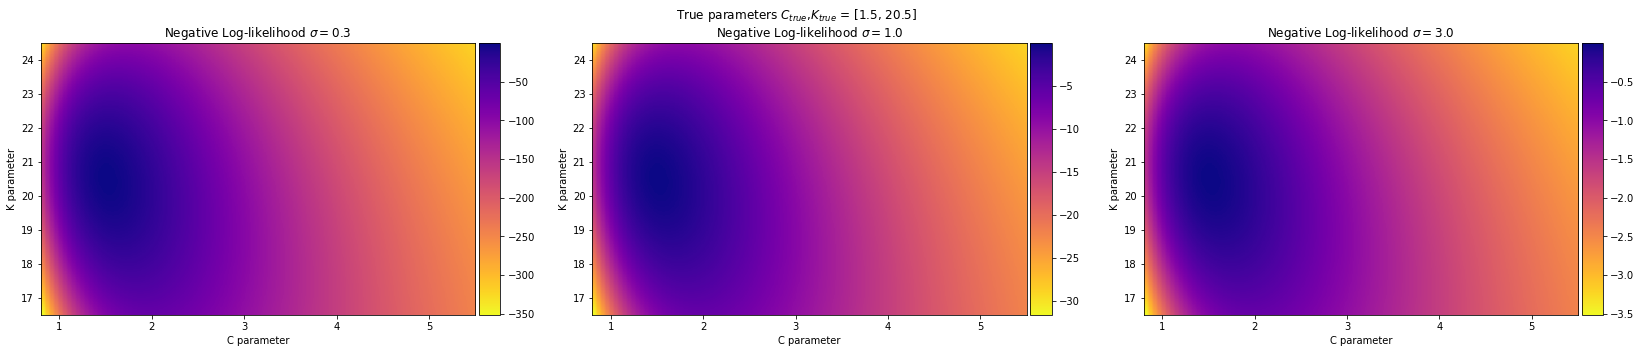

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

f,ax = plt.subplots(1,3,figsize=(28,5))
im1 = ax[0].imshow(grid1, extent=(C_xy[0],C_xy[1],K_xy[0],K_xy[1]), aspect='auto', cmap='plasma_r')
im2 = ax[1].imshow(grid2, extent=(C_xy[0],C_xy[1],K_xy[0],K_xy[1]), aspect='auto', cmap='plasma_r')
im3 = ax[2].imshow(grid3, extent=(C_xy[0],C_xy[1],K_xy[0],K_xy[1]), aspect='auto', cmap='plasma_r')
divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im1, cax=cax, orientation='vertical')
divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im2, cax=cax, orientation='vertical')
divider = make_axes_locatable(ax[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im3, cax=cax, orientation='vertical')
ax[0].set_title(rf"Negative Log-likelihood $\sigma = {sigma1}$")
ax[1].set_title(rf"Negative Log-likelihood $\sigma = {sigma2}$")
ax[2].set_title(rf"Negative Log-likelihood $\sigma = {sigma3}$")
for i in range(len(ax)):
  ax[i].set_xlabel('C parameter', fontsize=10)
  ax[i].set_ylabel('K parameter', fontsize=10)
f.suptitle(r"True parameters $C_{true}$,$K_{true}$"+f" = [{C_true}, {K_true}]")
plt.show()
f.savefig(image_folder + "likelihood_different_sigmas.png",bbox_inches='tight',dpi=400)

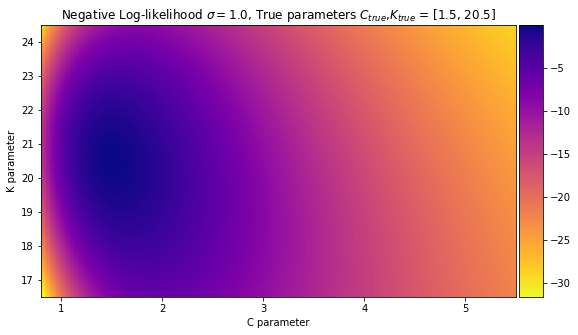

In [ ]:
f,ax = plt.subplots(figsize=(9,5))
im = ax.imshow(grid2, extent=(C_xy[0],C_xy[1],K_xy[0],K_xy[1]), aspect='auto', cmap='plasma_r')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')
ax.set_xlabel('C parameter', fontsize=10)
ax.set_ylabel('K parameter', fontsize=10)
ax.set_title(rf"Negative Log-likelihood $\sigma = {sigma2}$, " + r"True parameters $C_{true}$,$K_{true}$"+f" = [{C_true}, {K_true}]")
plt.show()
f.savefig(image_folder + "likelihood_of_problem.png",bbox_inches='tight',dpi=400)

## Coarsity depth test

In [ ]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "dual_parameter_estimation/coarsity_depth_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0

# Generate training data
T_max = 5
size = 500
time_config = [T_max, size]
t = get_time(time_config)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

Create coarse data for the different levels of MLMCMC

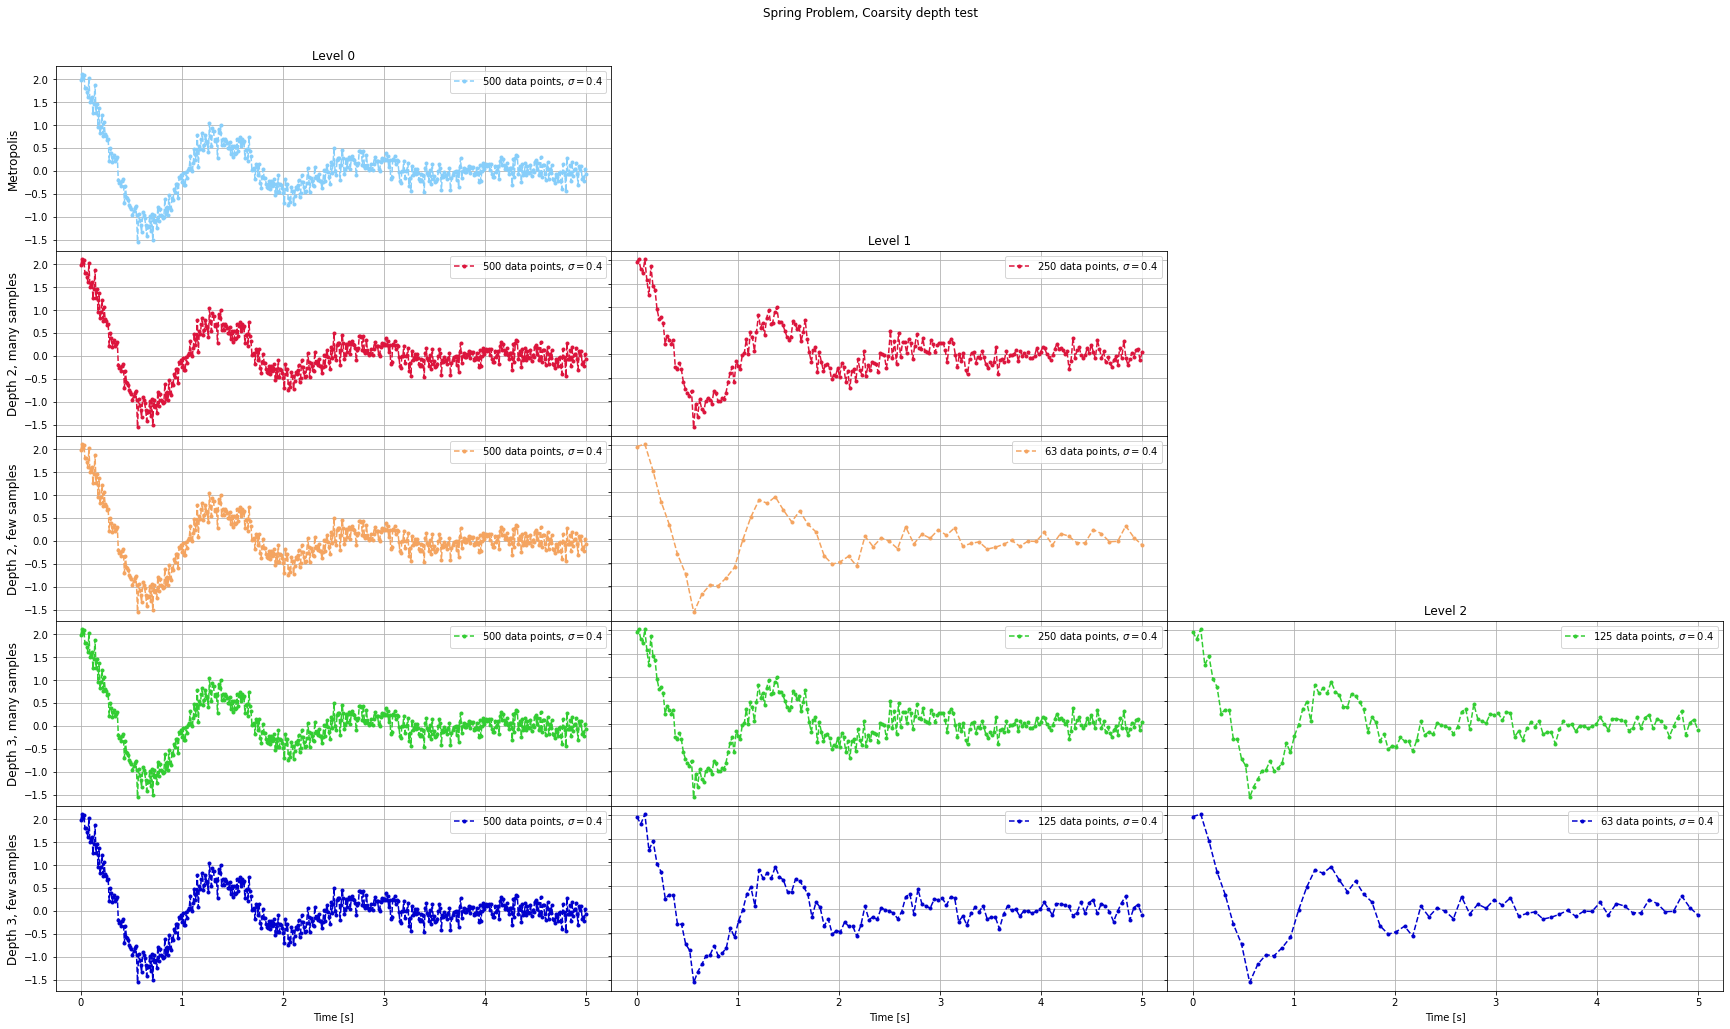

In [ ]:
datasets = []
method_names = []

# Add noise
sigma = 0.4
u_noisy = u_true + np.random.normal(0, sigma ** 2, u_true.shape)

# Dataset 1
dataset = []
dataset.append(u_noisy)
datasets.append(dataset)
method_names.append("Metropolis")

# Dataset 2
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
datasets.append(dataset)
method_names.append("Depth 2, many samples")

# Dataset 3
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::8])
datasets.append(dataset)
method_names.append("Depth 2, few samples")

# Dataset 4
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::2])
dataset.append(u_noisy[::4])
datasets.append(dataset)
method_names.append("Depth 3, many samples")

# Dataset 5
dataset = []
dataset.append(u_noisy)
dataset.append(u_noisy[::4])
dataset.append(u_noisy[::8])
datasets.append(dataset)
method_names.append("Depth 3, few samples")

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'--.',color = cols[i], label = rf"{data.shape[0]} data points, $\sigma = {sigma}$")
    ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Spring Problem, Coarsity depth test")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)

In [ ]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:
    logl.append(LogLike2(my_loglik2, data, T_max, sigma = 0.7))
  logls.append(logl)

Create coarse models

In [ ]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.array([4,22])
cov_prior = np.eye(2)

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(2,))

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](theta))

      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)

[]
[<pymc3.model.Model object at 0x7f4c8469f350>, <pymc3.model.Model object at 0x7f4c769edbd0>]
[<pymc3.model.Model object at 0x7f4c8472dc90>, <pymc3.model.Model object at 0x7f4c7699c250>]


Create fine models

In [ ]:
all_fine_models = []

for i in range(len(datasets)):
  # Constructing the fine model
  with pm.Model() as fine_model:
    theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(2,))
    pm.Potential("likelihood", logls[i][0](theta))
  all_fine_models.append(fine_model)

Set MCMC parameters for inference

In [ ]:
# Number of draws from the distribution
ndraws = 3000

# Number of independent chains.
nchains = 3

# Number of burn-in samples
nburn = 1000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [3,5]                     # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

In [ ]:
runtimes = []
all_traces = []
for fine_model,coarse_models in zip(all_fine_models,all_coarse_models):
  with fine_model:
    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)

      trace = pm.sample(
          draws=ndraws,
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          cores=10,
          )
    else:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)]
          )
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False
                        )
    runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  app.launch_new_instance()
Multiprocess sampling (3 chains in 10 jobs)
Metropolis: [theta]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 17 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 59 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 51 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 260 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 205 seconds.
The number of effective samples is smaller than 10% for some parameters.


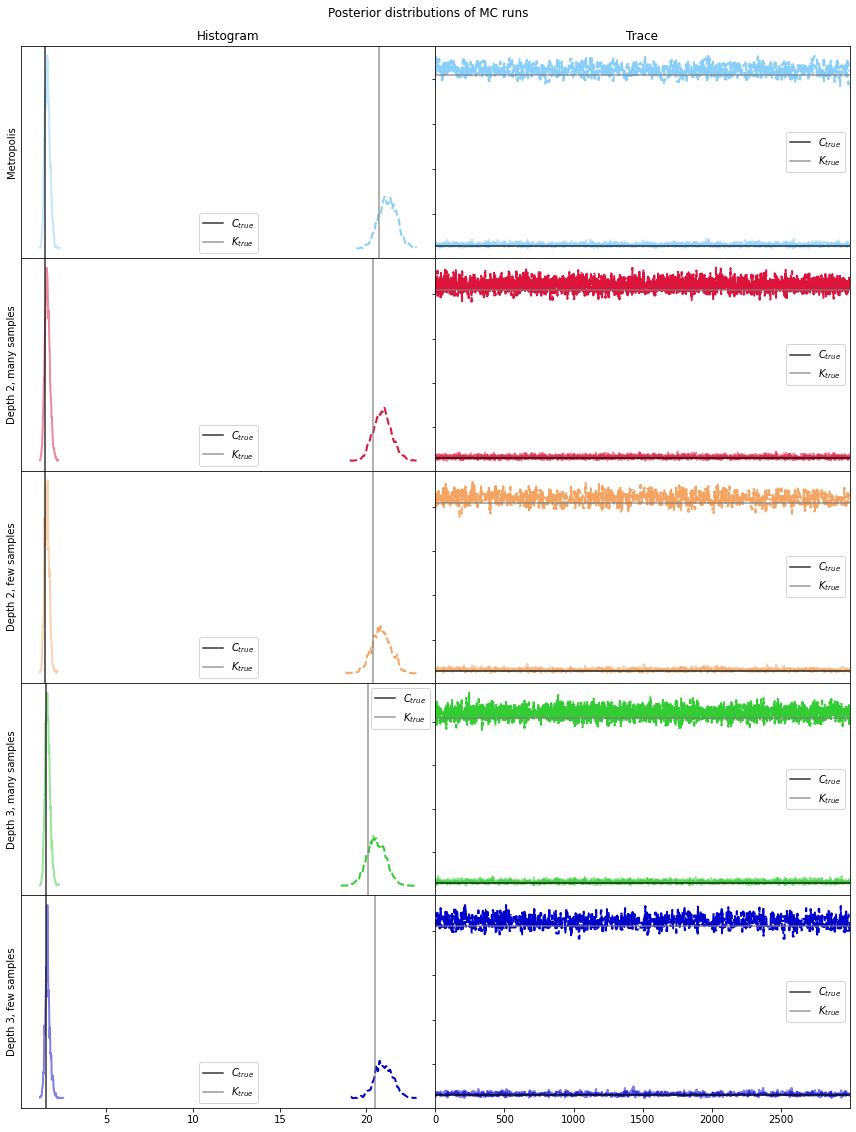

In [ ]:
f,ax = plt.subplots(len(all_traces),2, figsize=(12,3.3*len(all_traces)))
for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    chain_prop = {"color": [cols[i], cols[i]]}
    compact_prop={"lw": [2,2], "ls": ("-", "--"),"alpha":[0.5, 1.0]}
    az.plot_trace(trace, axes = ax[None,i,:], compact = True, combined=True, compact_prop=compact_prop, chain_prop=chain_prop)
    ax[i,0].set_ylabel(method_names[i])
    ax[i,0].set_title("")
    ax[i,1].set_title("")
    ax[i,0].axvline(x=C_true,color="k",alpha = 0.8, label=r"$C_{true}$")
    ax[i,0].axvline(x=K_true,color="grey",alpha = 0.8, label=r"$K_{true}$")
    ax[i,1].axhline(y=C_true,color="k",alpha = 0.8, label=r"$C_{true}$")
    ax[i,1].axhline(y=K_true,color="grey",alpha = 0.8, label=r"$K_{true}$")
    ax[i,0].legend()
    ax[i,1].legend()
for i in range(len(all_traces)):
  for j in range(2):
    if j == 0:
      if i == len(all_traces)-1:
        continue
      else:
        ax[i,j].set_xticklabels([])
    else:
      if i == len(all_traces)-1:
        ax[i,j].set_yticklabels([])
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
ax[0,0].set_title("Histogram")
ax[0,1].set_title("Trace")
f.suptitle("Posterior distributions of MC runs")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "trace_plots.png",bbox_inches='tight',dpi=300)

In [ ]:
theta_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    display(az.summary(trace))
    theta_hats.append(np.mean(trace['theta'],axis=0))


Metropolis Sampler:
 runtime :  42.62526535987854


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.609  0.149   1.350    1.896  ...    0.003    1145.0    1581.0   1.00
theta[1]  21.016  0.526  19.978   21.926  ...    0.018     423.0     584.0   1.01

[2 rows x 9 columns]


Depth 2, many samples Sampler:
 runtime :  64.81204915046692


mean    sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.612  0.15   1.334    1.892  ...    0.002    2070.0    2761.0    1.0
theta[1]  21.026  0.54  19.990   22.000  ...    0.009    1966.0    2656.0    1.0

[2 rows x 9 columns]


Depth 2, few samples Sampler:
 runtime :  52.505738496780396


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.603  0.141   1.356    1.861  ...    0.004     570.0     960.0   1.01
theta[1]  20.976  0.557  19.951   21.993  ...    0.015     711.0     920.0   1.01

[2 rows x 9 columns]


Depth 3, many samples Sampler:
 runtime :  261.9735977649689


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.607  0.149   1.334    1.886  ...    0.002    1931.0    1909.0    1.0
theta[1]  20.998  0.556  19.999   22.045  ...    0.009    1770.0    1558.0    1.0

[2 rows x 9 columns]


Depth 3, few samples Sampler:
 runtime :  205.69132709503174


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.609  0.145   1.357    1.911  ...    0.003     847.0    1062.0    1.0
theta[1]  21.006  0.535  20.007   22.006  ...    0.014     754.0     782.0    1.0

[2 rows x 9 columns]

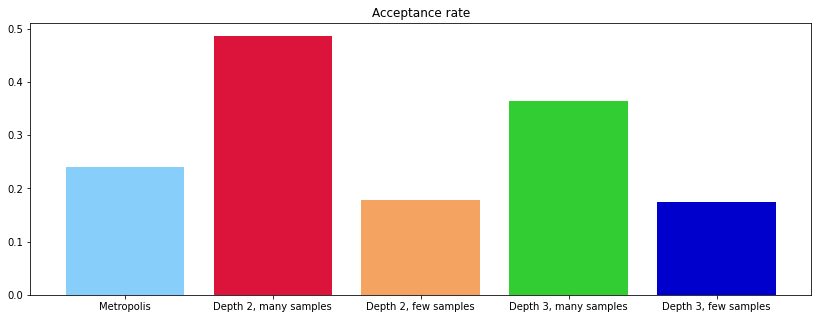

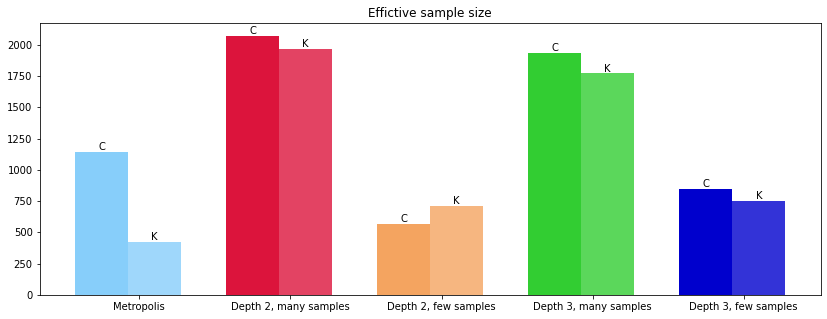

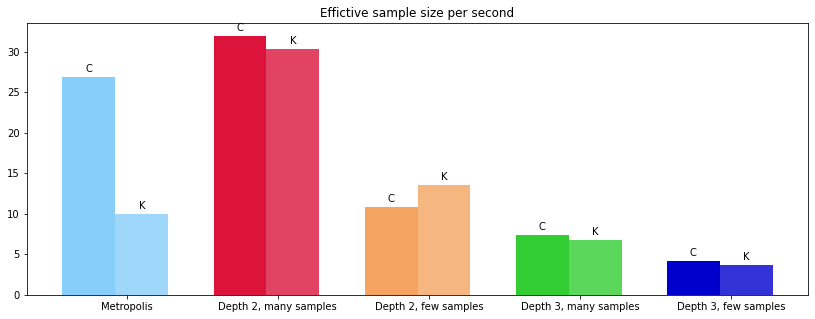

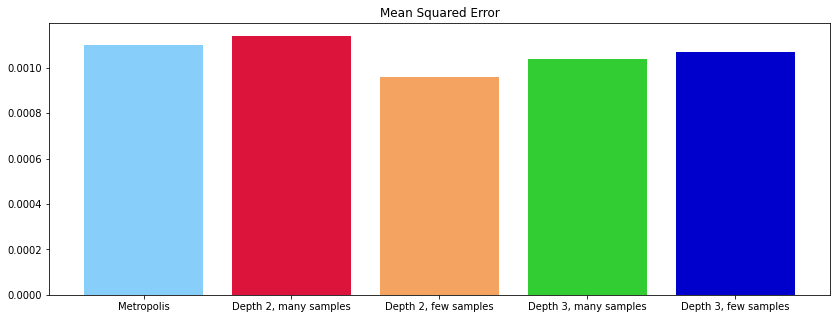

In [ ]:
# Model predictions
error = []
for theta_hat in theta_hats:
  u_hat = pendulum_analytical_solution(theta_hat[0],theta_hat[1],t)
  mse = np.mean((u_true-u_hat)**2)
  error.append(mse)

# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
ess = np.array(ess)
ess_n = np.array(ess_n)
performances = np.array(performances)

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

N = ess.shape[0]
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
labels = ["C"]*N + ["K"]*N

f,ax = plt.subplots(figsize=(14,5))
ax.bar(ind,ess[:,0],width, color = cols)
ax.bar(ind+width,ess[:,1],width, color = cols, alpha=0.8)
ax.set_xticks(ind + 0.25)
ax.set_title('Effictive sample size')
ax.set_xticklabels(method_names)
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.4, label, ha="center", va="bottom"
    )
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(ind,performances[:,0],width, color = cols)
ax.bar(ind+width,performances[:,1],width, color = cols, alpha=0.8)
ax.set_xticks(ind + 0.25)
ax.set_title('Effictive sample size per second')
ax.set_xticklabels(method_names)
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0.4, label, ha="center", va="bottom"
    )
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("Mean Squared Error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

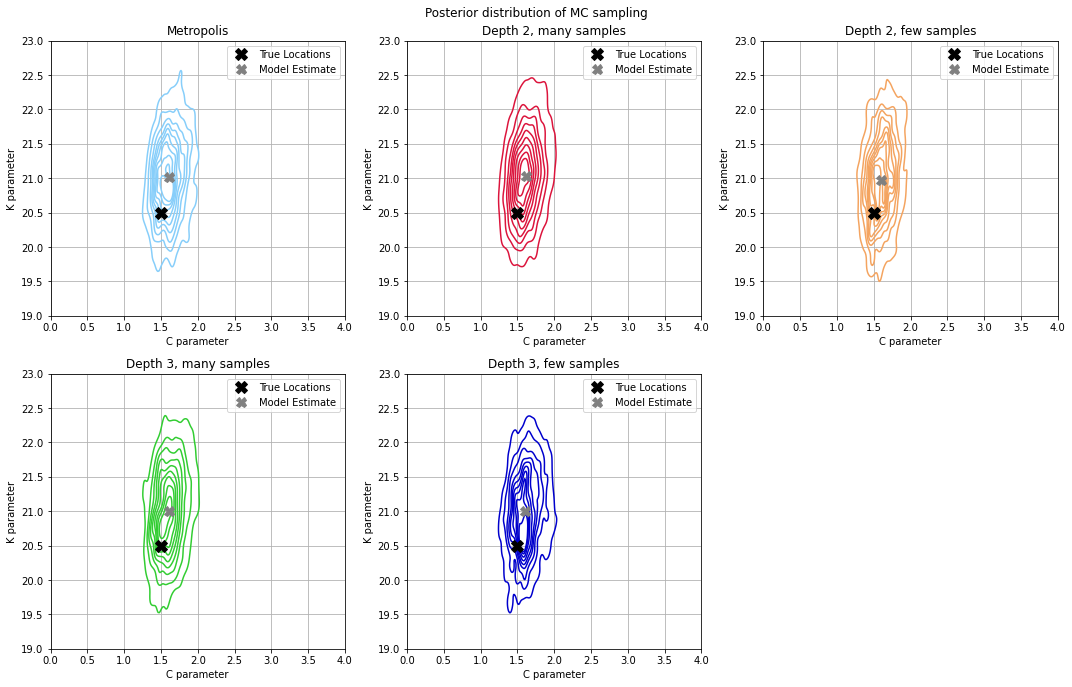

In [ ]:
minC = min(all_traces[0]['theta'][:,0])
maxC = max(all_traces[0]['theta'][:,0])
minK = min(all_traces[0]['theta'][:,1])
maxK = min(all_traces[0]['theta'][:,1])

for i in range(1,len(all_traces)):
  if min(all_traces[i]['theta'][:,0]) <= minC:
    minC = min(all_traces[i]['theta'][:,0])
  if max(all_traces[i]['theta'][:,0]) >= maxC:
    maxC = max(all_traces[i]['theta'][:,0])
  if min(all_traces[i]['theta'][:,1]) <= minK:
    minK = min(all_traces[i]['theta'][:,1])
  if max(all_traces[i]['theta'][:,1]) >= maxK:
    maxK = max(all_traces[i]['theta'][:,1])

limC = [minC,maxC]
limK = [minK,maxK]

limC = [0,4]
limK = [19,23]

N,M = (2,3)
f,ax = plt.subplots(N,M, figsize=(5*M,5*N))
ax = ax.flatten()
for i, trace in enumerate(all_traces):
  sn.kdeplot(x = trace['theta'][:,0], y = trace['theta'][:,1],ax = ax[i], color = cols[i])
  # sn.kdeplot(x = trace['theta'][:,0], y = trace['theta'][:,1],ax = ax[i], fill = True, cmap="mako")
  ax[i].set_xlabel('C parameter', fontsize=10)
  ax[i].set_ylabel('K parameter', fontsize=10)
  ax[i].set_title(method_names[i])
  ax[i].grid('on')
  ax[i].set_xlim(limC)
  ax[i].set_ylim(limK)
  # ax[i].axvline(x=C_true,color="k",alpha = 1.0, label=r"True Locations")
  # ax[i].axhline(y=K_true,color="k",alpha = 1.0)
  ax[i].plot(C_true,K_true,"Xk", alpha=1.0, markersize=12, label="True Locations")
  ax[i].plot(theta_hats[i][0],theta_hats[i][1],"X",color="gray", alpha=1.0, markersize=10, label="Model Estimate")
  ax[i].legend()
for j in range(i+1,N*M):
  ax[j].set_visible(False)
f.suptitle("Posterior distribution of MC sampling")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
f.savefig(image_folder + "posterior.png",bbox_inches='tight',dpi=300)

In [ ]:
theta_hats[i]

array([ 1.608596  , 21.00563935])

## Increasing level noise test


In [ ]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "dual_parameter_estimation/increasing_level_noise_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0

# Generate training data
T_max = 5
size = 500
time_config = [T_max, size]
t = get_time(time_config)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

Create coarse data for the different levels of MLMCMC

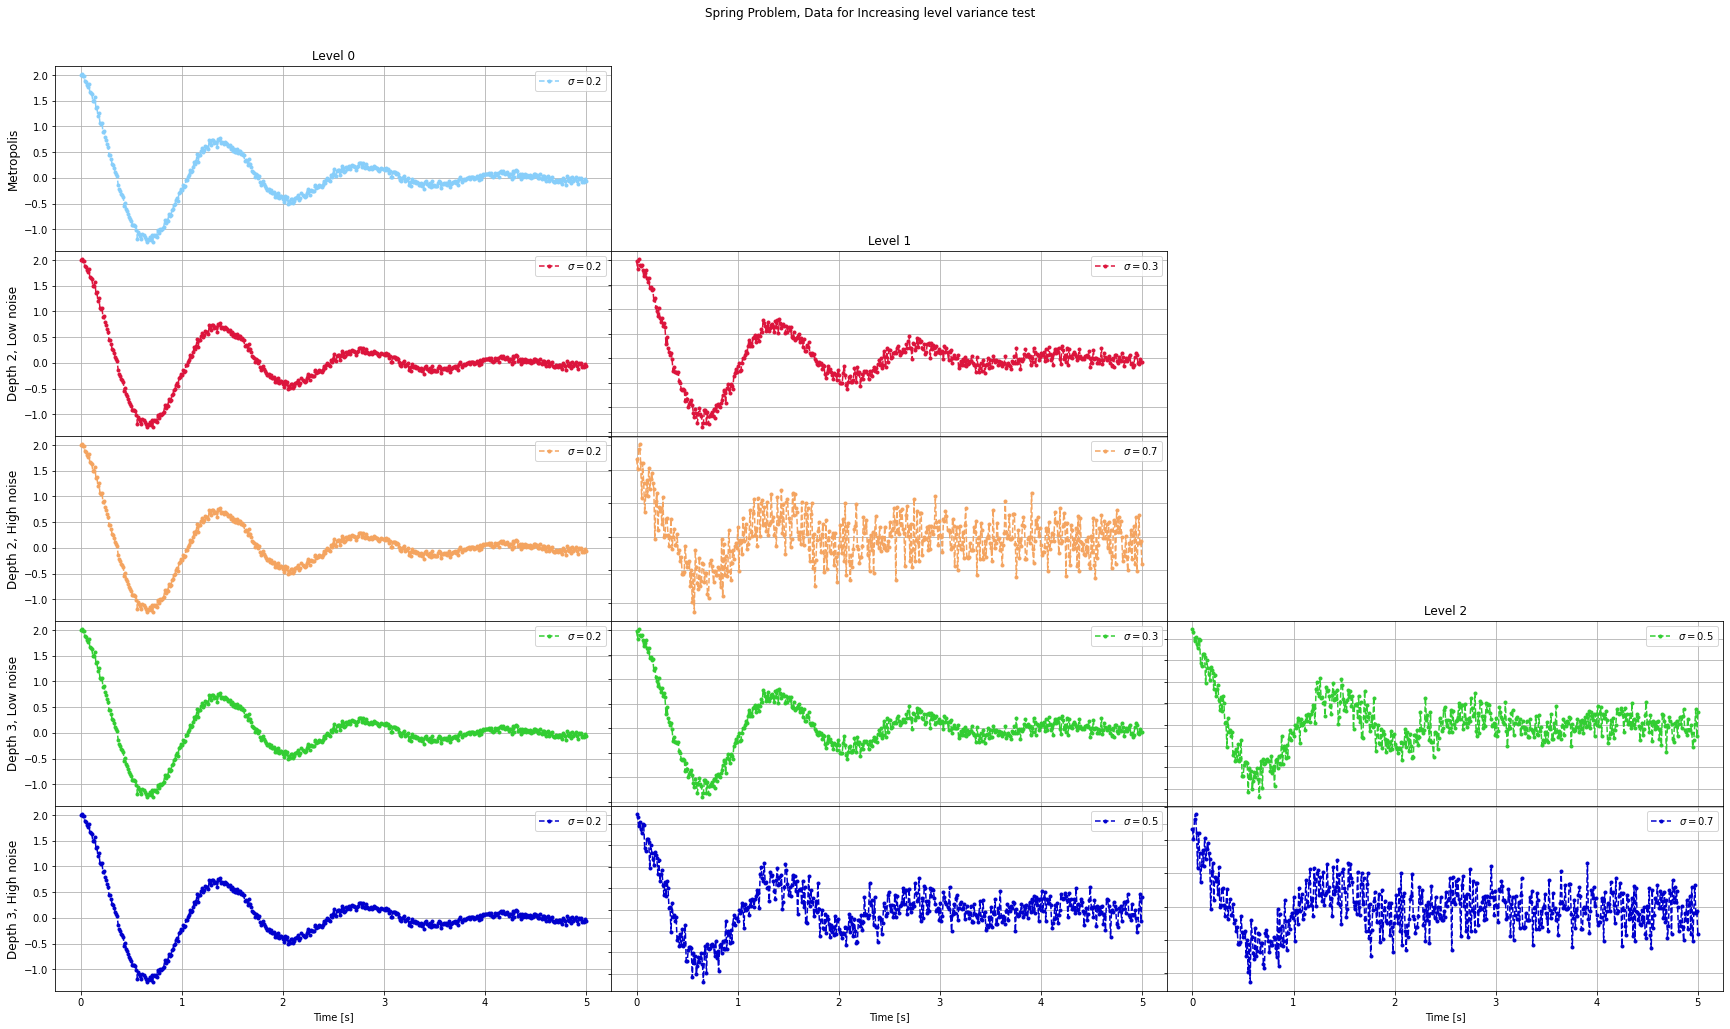

In [ ]:
datasets = []
method_names = []


# Add noise
sigmas = [0.2, 0.3, 0.5, 0.7]
noices = []
for sigma in sigmas:
  noices.append(np.random.normal(0, sigma ** 2, u_true.shape))

# Dataset 1
dataset = []
dataset.append(u_true + noices[0])
datasets.append(dataset)
method_names.append("Metropolis")

# Dataset 2
dataset = []
dataset.append(u_true + noices[0])
dataset.append(u_true + noices[1])
datasets.append(dataset)
method_names.append("Depth 2, Low noise")

# Dataset 3
dataset = []
dataset.append(u_true + noices[0])
dataset.append(u_true + noices[3])
datasets.append(dataset)
method_names.append("Depth 2, High noise")

# Dataset 4
dataset = []
dataset.append(u_true + noices[0])
dataset.append(u_true + noices[1])
dataset.append(u_true + noices[2])
datasets.append(dataset)
method_names.append("Depth 3, Low noise")

# Dataset 5
dataset = []
dataset.append(u_true + noices[0])
dataset.append(u_true + noices[2])
dataset.append(u_true + noices[3])
datasets.append(dataset)
method_names.append("Depth 3, High noise")

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

SIGMAS = np.zeros((len(datasets),max_len))
SIGMAS[:,0] = sigmas[0]
SIGMAS[1,1] = sigmas[1]
SIGMAS[3,1] = sigmas[1]
SIGMAS[3,2] = sigmas[2]
SIGMAS[4,1] = sigmas[2]
SIGMAS[2,1] = sigmas[3]
SIGMAS[4,2] = sigmas[3]

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'--.',color = cols[i], label = rf"$\sigma = {SIGMAS[i,j]}$")
    ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Spring Problem, Data for Increasing level variance test")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)

In [ ]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:
    logl.append(LogLike2(my_loglik2, data, T_max, sigma = 1.0))
  logls.append(logl)

Create coarse models

In [ ]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.array([4,22])
cov_prior = np.eye(2)

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(2,))

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](theta))

      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)

[]
[<pymc3.model.Model object at 0x7f4c72c09650>, <pymc3.model.Model object at 0x7f4c768b6a10>]
[<pymc3.model.Model object at 0x7f4c704d1b50>, <pymc3.model.Model object at 0x7f4c70a0e2d0>]


Create fine models

In [ ]:
all_fine_models = []

for i in range(len(datasets)):
  # Constructing the fine model
  with pm.Model() as fine_model:
    theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(2,))
    pm.Potential("likelihood", logls[i][0](theta))
  all_fine_models.append(fine_model)

Set MCMC parameters for inference

In [ ]:
# Number of draws from the distribution
ndraws = 3000

# Number of independent chains.
nchains = 3

# Number of burn-in samples
nburn = 1000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [3,5]                     # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

In [ ]:
runtimes = []
all_traces = []
for fine_model,coarse_models in zip(all_fine_models,all_coarse_models):
  with fine_model:
    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)

      trace = pm.sample(
          draws=ndraws,
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          cores=10,
          )
    else:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)]
          )
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False
                        )
    runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  app.launch_new_instance()
Multiprocess sampling (3 chains in 10 jobs)
Metropolis: [theta]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 11 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 53 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 53 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 259 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 216 seconds.
The number of effective samples is smaller than 25% for some parameters.


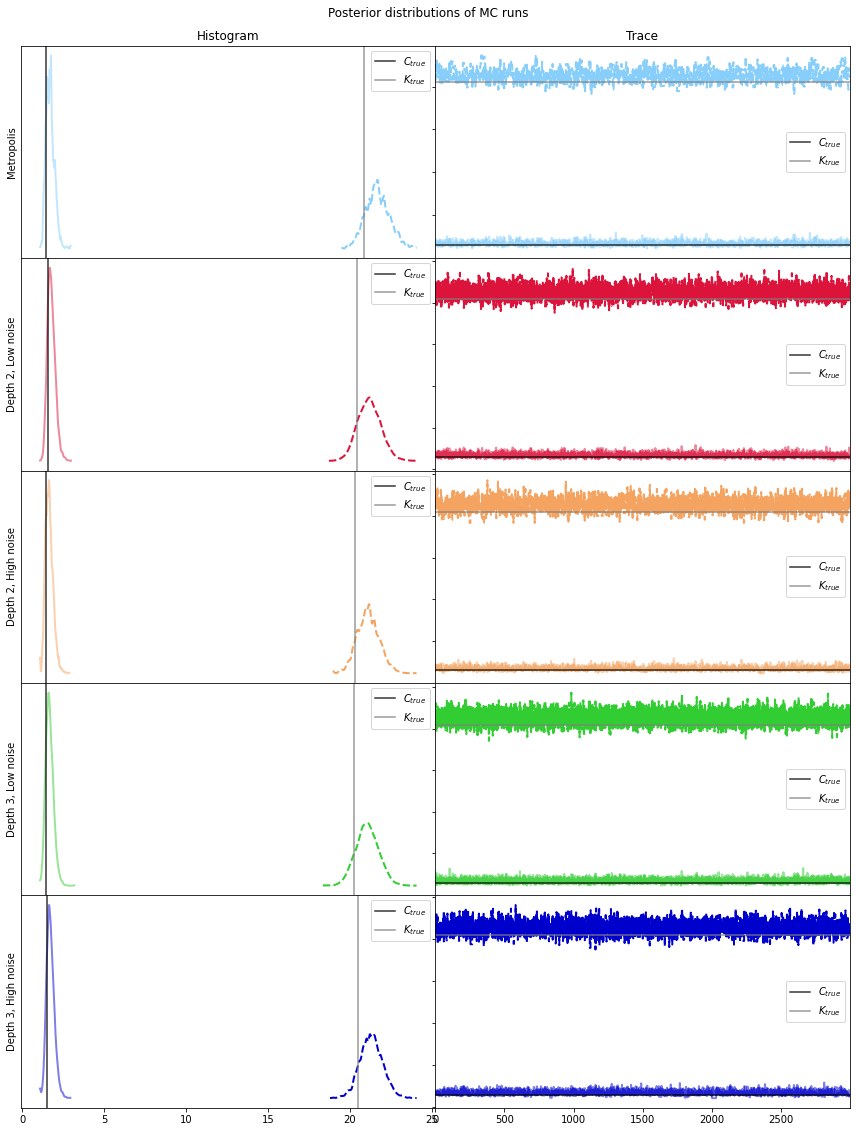

In [ ]:
f,ax = plt.subplots(len(all_traces),2, figsize=(12,3.3*len(all_traces)))
for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    chain_prop = {"color": [cols[i], cols[i]]}
    compact_prop={"lw": [2,2], "ls": ("-", "--"),"alpha":[0.5, 1.0]}
    az.plot_trace(trace, axes = ax[None,i,:], compact = True, combined=True, compact_prop=compact_prop, chain_prop=chain_prop)
    ax[i,0].set_ylabel(method_names[i])
    ax[i,0].set_title("")
    ax[i,1].set_title("")
    ax[i,0].axvline(x=C_true,color="k",alpha = 0.8, label=r"$C_{true}$")
    ax[i,0].axvline(x=K_true,color="grey",alpha = 0.8, label=r"$K_{true}$")
    ax[i,1].axhline(y=C_true,color="k",alpha = 0.8, label=r"$C_{true}$")
    ax[i,1].axhline(y=K_true,color="grey",alpha = 0.8, label=r"$K_{true}$")
    ax[i,0].legend()
    ax[i,1].legend()
for i in range(len(all_traces)):
  for j in range(2):
    if j == 0:
      if i == len(all_traces)-1:
        continue
      else:
        ax[i,j].set_xticklabels([])
    else:
      if i == len(all_traces)-1:
        ax[i,j].set_yticklabels([])
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
ax[0,0].set_title("Histogram")
ax[0,1].set_title("Trace")
f.suptitle("Posterior distributions of MC runs")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "trace_plots.png",bbox_inches='tight',dpi=300)

In [ ]:
theta_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    display(az.summary(trace))
    theta_hats.append(np.mean(trace['theta'],axis=0))


Metropolis Sampler:
 runtime :  11.511179447174072


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.723  0.247   1.292    2.160  ...    0.005    1149.0    1582.0   1.00
theta[1]  21.311  0.710  20.033   22.659  ...    0.022     526.0     547.0   1.01

[2 rows x 9 columns]


Depth 2, Low noise Sampler:
 runtime :  54.483874559402466


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.720  0.241   1.316    2.197  ...    0.003    3124.0    3756.0    1.0
theta[1]  21.279  0.708  19.982   22.602  ...    0.009    3258.0    4123.0    1.0

[2 rows x 9 columns]


Depth 2, High noise Sampler:
 runtime :  54.30350089073181


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.709  0.237   1.314    2.169  ...    0.004    1233.0     945.0    1.0
theta[1]  21.325  0.688  19.952   22.532  ...    0.011    1884.0    1981.0    1.0

[2 rows x 9 columns]


Depth 3, Low noise Sampler:
 runtime :  260.1398048400879


mean    sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.716  0.24   1.269    2.153  ...    0.002    6198.0    5051.0    1.0
theta[1]  21.304  0.71  20.043   22.680  ...    0.006    6132.0    5838.0    1.0

[2 rows x 9 columns]


Depth 3, High noise Sampler:
 runtime :  217.0356364250183


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.721  0.240   1.307    2.189  ...    0.004    1721.0     959.0    1.0
theta[1]  21.314  0.694  20.099   22.695  ...    0.009    2861.0    2335.0    1.0

[2 rows x 9 columns]

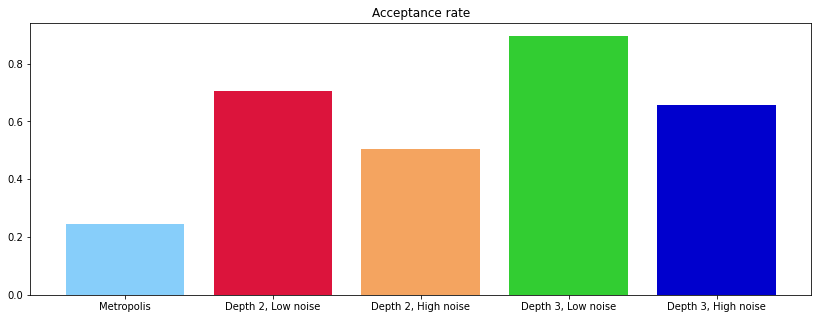

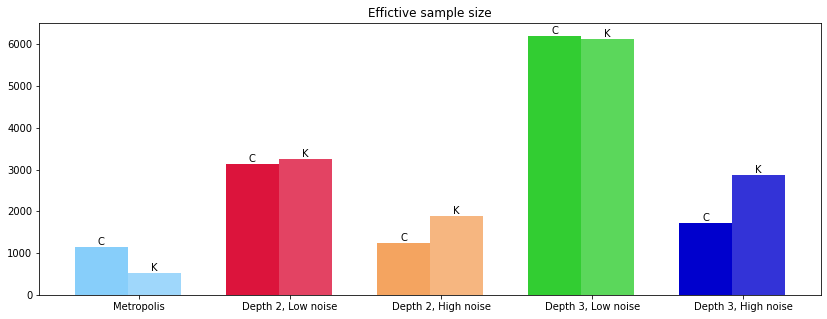

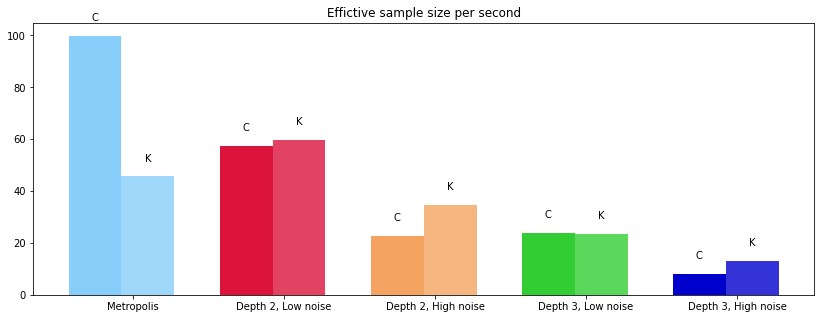

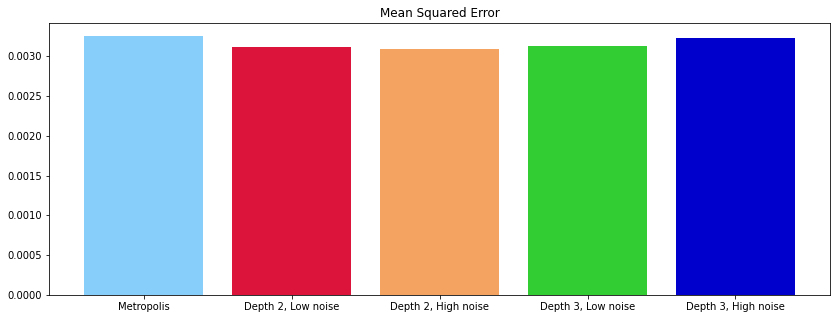

In [ ]:
# Model predictions
error = []
for theta_hat in theta_hats:
  u_hat = pendulum_analytical_solution(theta_hat[0],theta_hat[1],t)
  mse = np.mean((u_true-u_hat)**2)
  error.append(mse)

# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
ess = np.array(ess)
ess_n = np.array(ess_n)
performances = np.array(performances)

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

N = ess.shape[0]
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
labels = ["C"]*N + ["K"]*N

f,ax = plt.subplots(figsize=(14,5))
ax.bar(ind,ess[:,0],width, color = cols)
ax.bar(ind+width,ess[:,1],width, color = cols, alpha=0.8)
ax.set_xticks(ind + 0.25)
ax.set_title('Effictive sample size')
ax.set_xticklabels(method_names)
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(ind,performances[:,0],width, color = cols)
ax.bar(ind+width,performances[:,1],width, color = cols, alpha=0.8)
ax.set_xticks(ind + 0.25)
ax.set_title('Effictive sample size per second')
ax.set_xticklabels(method_names)
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("Mean Squared Error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

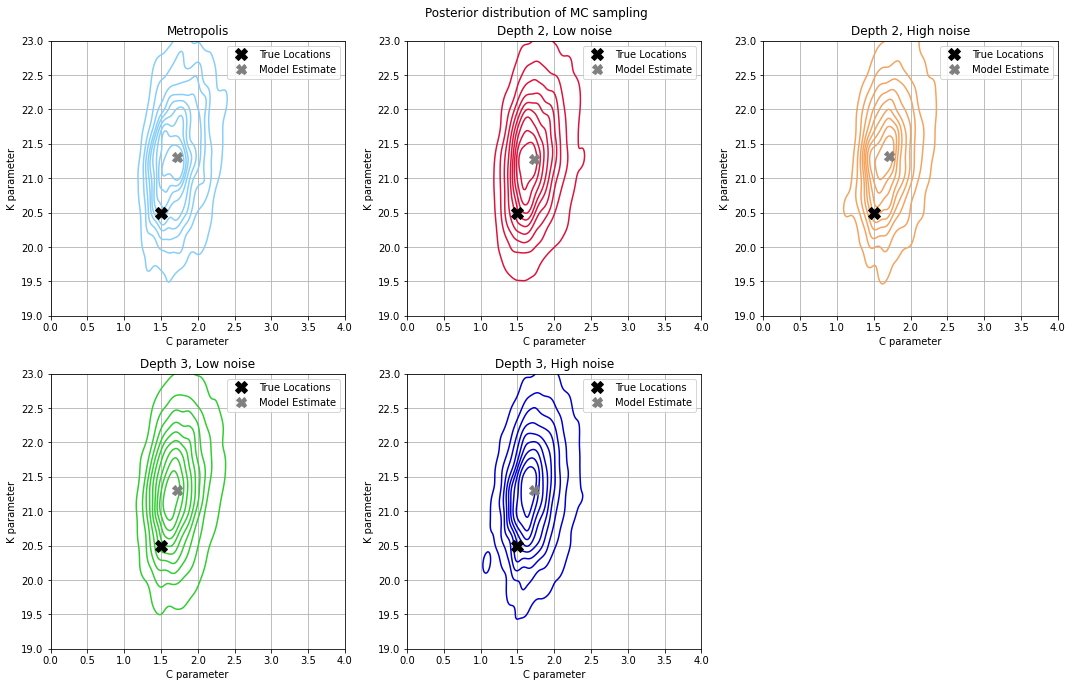

In [ ]:
minC = min(all_traces[0]['theta'][:,0])
maxC = max(all_traces[0]['theta'][:,0])
minK = min(all_traces[0]['theta'][:,1])
maxK = min(all_traces[0]['theta'][:,1])

for i in range(1,len(all_traces)):
  if min(all_traces[i]['theta'][:,0]) <= minC:
    minC = min(all_traces[i]['theta'][:,0])
  if max(all_traces[i]['theta'][:,0]) >= maxC:
    maxC = max(all_traces[i]['theta'][:,0])
  if min(all_traces[i]['theta'][:,1]) <= minK:
    minK = min(all_traces[i]['theta'][:,1])
  if max(all_traces[i]['theta'][:,1]) >= maxK:
    maxK = max(all_traces[i]['theta'][:,1])

limC = [minC,maxC]
limK = [minK,maxK]

limC = [0,4]
limK = [19,23]

N,M = (2,3)
f,ax = plt.subplots(N,M, figsize=(5*M,5*N))
ax = ax.flatten()
for i, trace in enumerate(all_traces):
  sn.kdeplot(x = trace['theta'][:,0], y = trace['theta'][:,1],ax = ax[i], color = cols[i])
  # sn.kdeplot(x = trace['theta'][:,0], y = trace['theta'][:,1],ax = ax[i], fill = True, cmap="mako")
  ax[i].set_xlabel('C parameter', fontsize=10)
  ax[i].set_ylabel('K parameter', fontsize=10)
  ax[i].set_title(method_names[i])
  ax[i].grid('on')
  ax[i].set_xlim(limC)
  ax[i].set_ylim(limK)
  # ax[i].axvline(x=C_true,color="k",alpha = 1.0, label=r"True Locations")
  # ax[i].axhline(y=K_true,color="k",alpha = 1.0)
  ax[i].plot(C_true,K_true,"Xk", alpha=1.0, markersize=12, label="True Locations")
  ax[i].plot(theta_hats[i][0],theta_hats[i][1],"X",color="gray", alpha=1.0, markersize=10, label="Model Estimate")
  ax[i].legend()
for j in range(i+1,N*M):
  ax[j].set_visible(False)
f.suptitle("Posterior distribution of MC sampling")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
f.savefig(image_folder + "posterior.png",bbox_inches='tight',dpi=300)

## Proposal variance test


In [157]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "dual_parameter_estimation/proposal_variance_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0

# Generate training data
T_max = 5
size = 400
time_config = [T_max, size]
t = get_time(time_config)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

Create coarse data for the different levels of MLMCMC

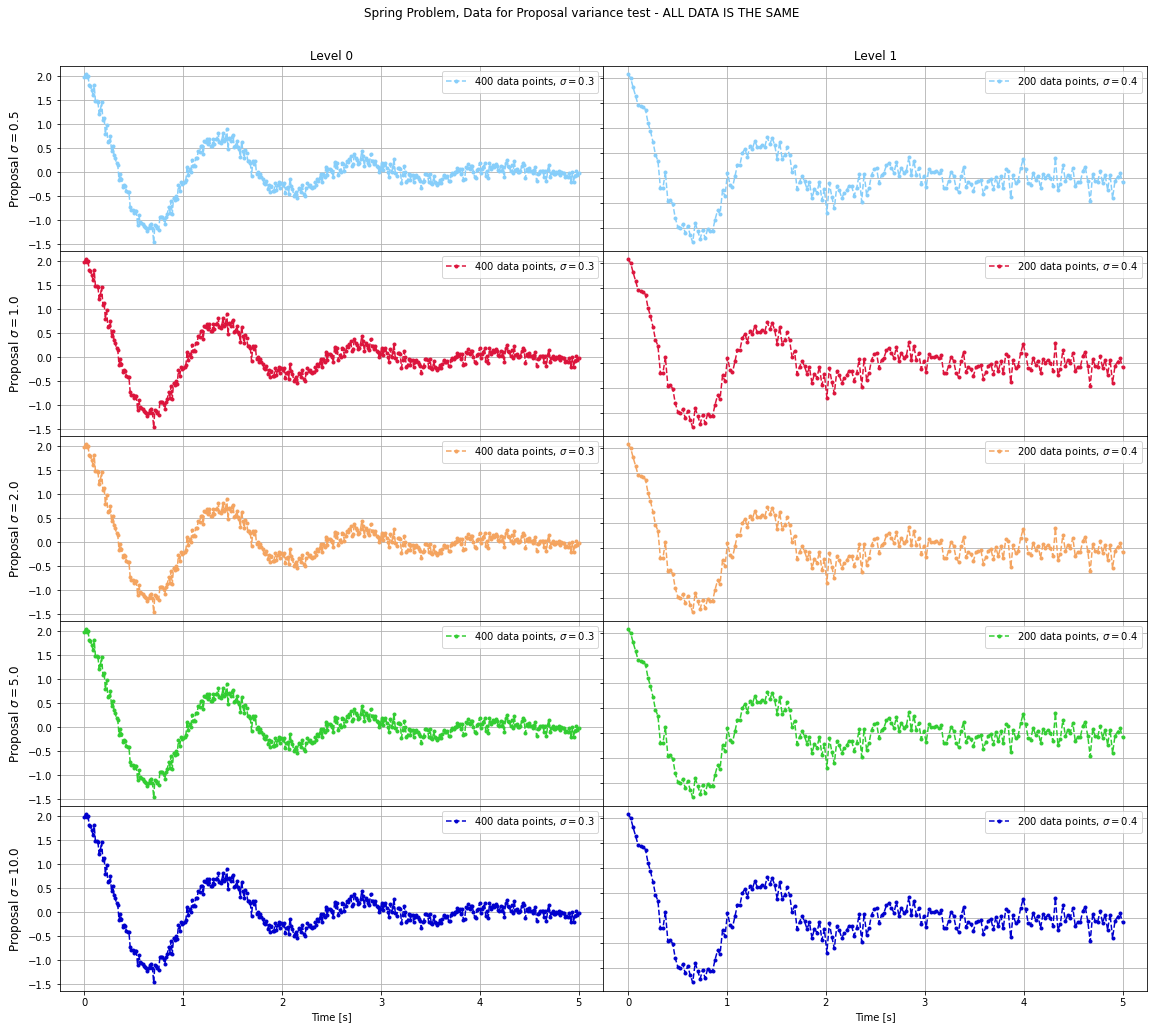

In [158]:
datasets = []
method_names = []


# Add noise
sigmas = [0.3, 0.4, 0.5]
noices = []
for sigma in sigmas:
  noices.append(np.random.normal(0, sigma ** 2, u_true.shape))


# Dataset 1
dataset = []
dataset.append(u_true + noices[0])
dataset.append((u_true + noices[1])[::2])
# dataset.append((u_true + noices[2])[::2])
datasets.append(dataset)
method_names.append(r"Proposal $\sigma = 0.5$")

# Dataset 1
dataset = []
dataset.append(u_true + noices[0])
dataset.append((u_true + noices[1])[::2])
# dataset.append((u_true + noices[2])[::2])
datasets.append(dataset)
method_names.append(r"Proposal $\sigma = 1.0$")

# Dataset 1
dataset = []
dataset.append(u_true + noices[0])
dataset.append((u_true + noices[1])[::2])
# dataset.append((u_true + noices[2])[::2])
datasets.append(dataset)
method_names.append(r"Proposal $\sigma = 2.0$")

# Dataset 1
dataset = []
dataset.append(u_true + noices[0])
dataset.append((u_true + noices[1])[::2])
# dataset.append((u_true + noices[2])[::2])
datasets.append(dataset)
method_names.append(r"Proposal $\sigma = 5.0$")

# Dataset 1
dataset = []
dataset.append(u_true + noices[0])
dataset.append((u_true + noices[1])[::2])
# dataset.append((u_true + noices[2])[::2])
datasets.append(dataset)
method_names.append(r"Proposal $\sigma = 10.0$")

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'--.',color = cols[i], label = rf"{data.shape[0]} data points, $\sigma = {sigmas[j]}$")
    ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Spring Problem, Data for Proposal variance test - ALL DATA IS THE SAME")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)

In [160]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:
    logl.append(LogLike2(my_loglik2, data, T_max, sigma = 0.5))
  logls.append(logl)

Create coarse models

In [161]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.array([4,22])
# cov_priors = [0.5*np.eye(2), 1*np.eye(2), 5*np.eye(2), 10*np.eye(2), 20*np.eye(2)]
cov_prior = np.eye(2)

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(2,))

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](theta))

      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)
all_fine_models = []
for i in range(len(datasets)):
  # Constructing the fine model
  with pm.Model() as fine_model:
    theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(2,))
    pm.Potential("likelihood", logls[i][0](theta))
  all_fine_models.append(fine_model)

Set MCMC parameters for inference

In [164]:
from theano.sparse.basic import TrueDot
# Number of draws from the distribution
ndraws = 4000

# Number of independent chains.
nchains = 3

# Number of burn-in samples
nburn = 1000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [3,5]                     # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

# standard deviation
Ss = [np.asarray([0.5]), np.asarray([1.0]), np.asarray([2.0]), np.asarray([5.0]), np.asarray([10.0])]

In [166]:
runtimes = []
all_traces = []
for i,(fine_model,coarse_models) in enumerate(zip(all_fine_models,all_coarse_models)):
  with fine_model:
    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval,
                                      S = Ss[i])

      trace = pm.sample(
          draws=ndraws,
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          cores=10
          )
    else:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, 
          subsampling_rates=nsub[:len(coarse_models)],
          # base_S = Ss[i]
          base_scaling = Ss[i],
          )
      
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False,
                        )
    runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 1_000 tune and 4_000 draw iterations (3_000 + 12_000 draws total) took 92 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 1_000 tune and 4_000 draw iterations (3_000 + 12_000 draws total) took 73 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 1_000 tune and 4_000 draw iterations (3_000 + 12_000 draws total) took 67 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 1_000 tune and 4_000 draw iterations (3_000 + 12_000 draws total) took 65 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
Sampling 3 chains for 1_000 tune and 4_000 draw iterations (3_000 + 12_000 draws total) took 67 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


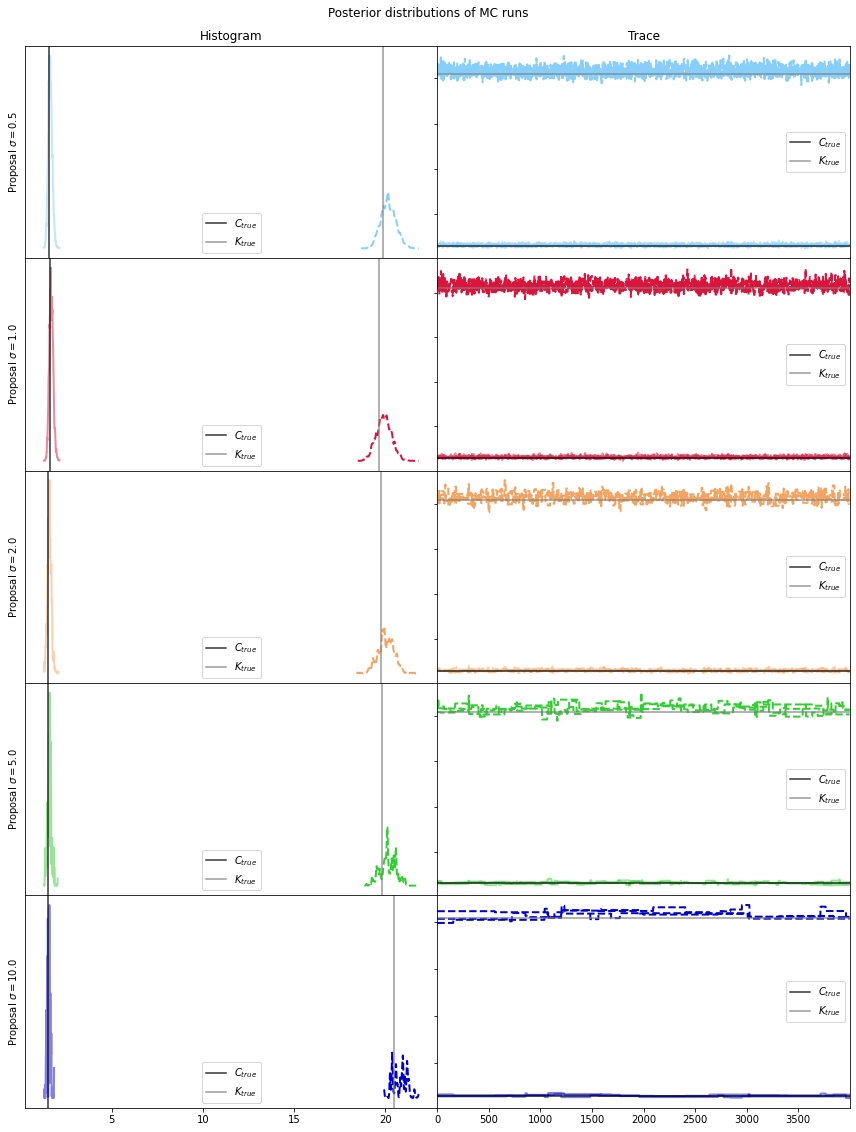

In [167]:
f,ax = plt.subplots(len(all_traces),2, figsize=(12,3.3*len(all_traces)))
for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    chain_prop = {"color": [cols[i], cols[i]]}
    compact_prop={"lw": [2,2], "ls": ("-", "--"),"alpha":[0.5, 1.0]}
    az.plot_trace(trace, axes = ax[None,i,:], compact = True, combined=True, compact_prop=compact_prop, chain_prop=chain_prop)
    ax[i,0].set_ylabel(method_names[i])
    ax[i,0].set_title("")
    ax[i,1].set_title("")
    ax[i,0].axvline(x=C_true,color="k",alpha = 0.8, label=r"$C_{true}$")
    ax[i,0].axvline(x=K_true,color="grey",alpha = 0.8, label=r"$K_{true}$")
    ax[i,1].axhline(y=C_true,color="k",alpha = 0.8, label=r"$C_{true}$")
    ax[i,1].axhline(y=K_true,color="grey",alpha = 0.8, label=r"$K_{true}$")
    ax[i,0].legend()
    ax[i,1].legend()
for i in range(len(all_traces)):
  for j in range(2):
    if j == 0:
      if i == len(all_traces)-1:
        continue
      else:
        ax[i,j].set_xticklabels([])
    else:
      if i == len(all_traces)-1:
        ax[i,j].set_yticklabels([])
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
ax[0,0].set_title("Histogram")
ax[0,1].set_title("Trace")
f.suptitle("Posterior distributions of MC runs")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "trace_plots.png",bbox_inches='tight',dpi=300)

In [168]:
theta_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    display(az.summary(trace))
    theta_hats.append(np.mean(trace['theta'],axis=0))


Proposal $\sigma = 0.5$ Sampler:
 runtime :  94.2479190826416


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.560  0.114   1.361    1.787  ...    0.002    2230.0    2610.0    1.0
theta[1]  20.799  0.437  19.970   21.598  ...    0.008    1574.0    2149.0    1.0

[2 rows x 9 columns]


Proposal $\sigma = 1.0$ Sampler:
 runtime :  74.35983514785767


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.565  0.115   1.360    1.791  ...    0.002    1534.0    1819.0    1.0
theta[1]  20.783  0.441  19.979   21.619  ...    0.010     937.0    1405.0    1.0

[2 rows x 9 columns]


Proposal $\sigma = 2.0$ Sampler:
 runtime :  68.0901448726654


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.567  0.113   1.331    1.751  ...    0.004     396.0     581.0   1.01
theta[1]  20.795  0.456  19.973   21.604  ...    0.014     492.0     514.0   1.00

[2 rows x 9 columns]


Proposal $\sigma = 5.0$ Sampler:
 runtime :  66.9467101097107


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.559  0.114   1.359    1.807  ...    0.009      79.0      50.0   1.07
theta[1]  20.850  0.457  19.940   21.641  ...    0.039      75.0      87.0   1.05

[2 rows x 9 columns]


Proposal $\sigma = 10.0$ Sampler:
 runtime :  68.29412579536438


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.551  0.093   1.393    1.695  ...    0.014      23.0      11.0   1.12
theta[1]  20.820  0.384  20.266   21.363  ...    0.064      18.0       7.0   1.16

[2 rows x 9 columns]

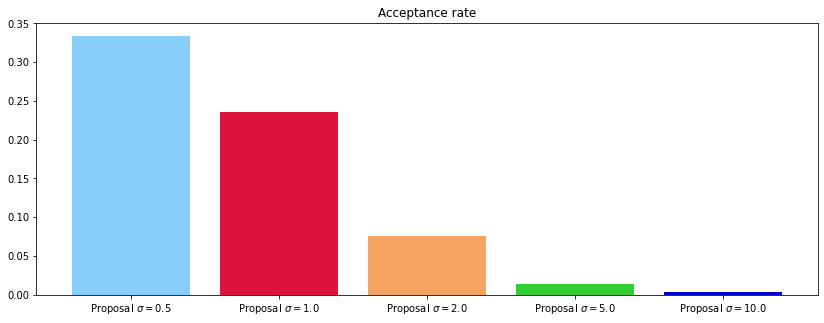

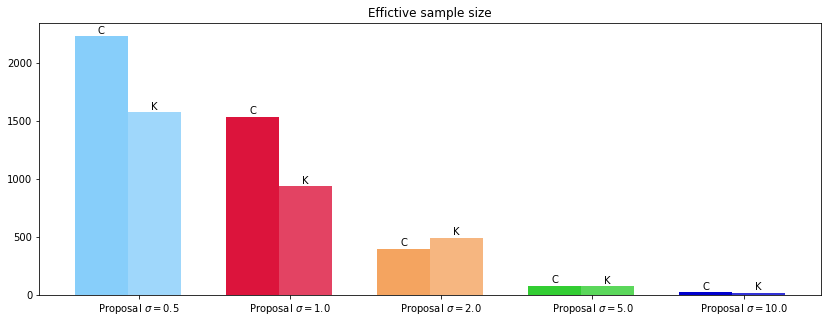

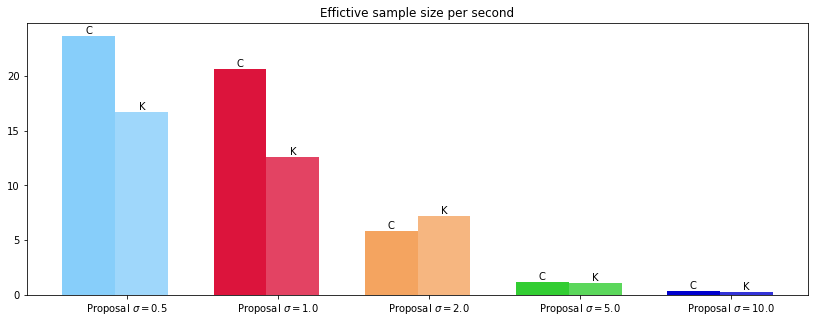

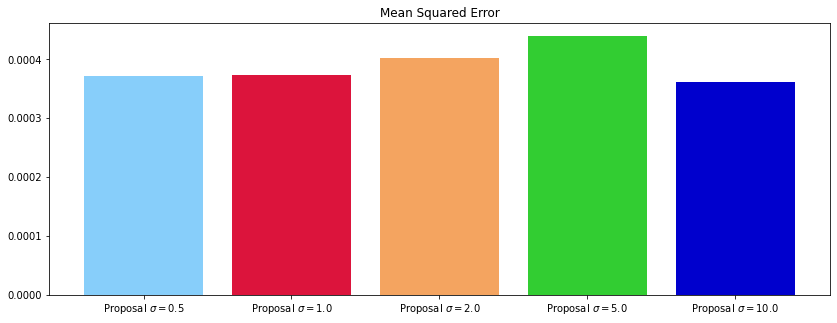

In [171]:
# Model predictions
error = []
for theta_hat in theta_hats:
  u_hat = pendulum_analytical_solution(theta_hat[0],theta_hat[1],t)
  mse = np.mean((u_true-u_hat)**2)
  error.append(mse)

# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
ess = np.array(ess)
ess_n = np.array(ess_n)
performances = np.array(performances)

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

N = ess.shape[0]
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
labels = ["C"]*N + ["K"]*N

f,ax = plt.subplots(figsize=(14,5))
ax.bar(ind,ess[:,0],width, color = cols)
ax.bar(ind+width,ess[:,1],width, color = cols, alpha=0.8)
ax.set_xticks(ind + 0.25)
ax.set_title('Effictive sample size')
ax.set_xticklabels(method_names)
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(ind,performances[:,0],width, color = cols)
ax.bar(ind+width,performances[:,1],width, color = cols, alpha=0.8)
ax.set_xticks(ind + 0.25)
ax.set_title('Effictive sample size per second')
ax.set_xticklabels(method_names)
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0, label, ha="center", va="bottom"
    )
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("Mean Squared Error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

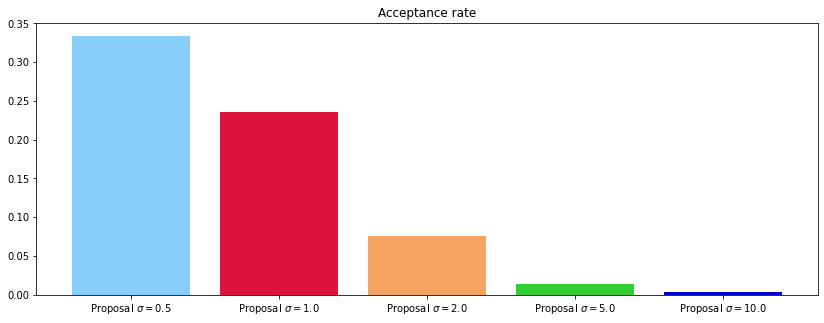

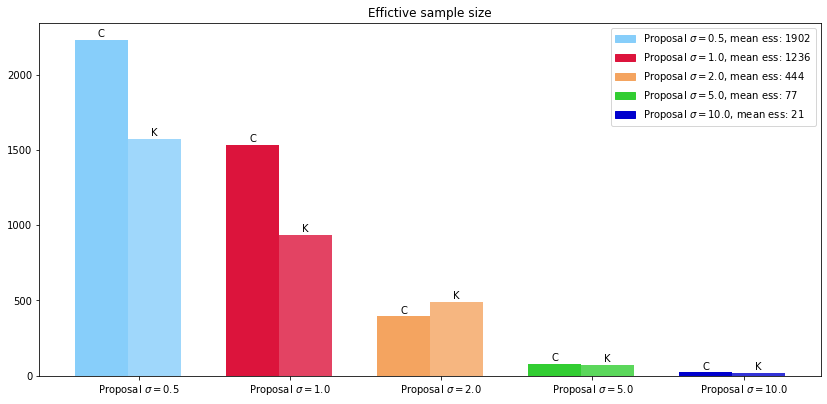

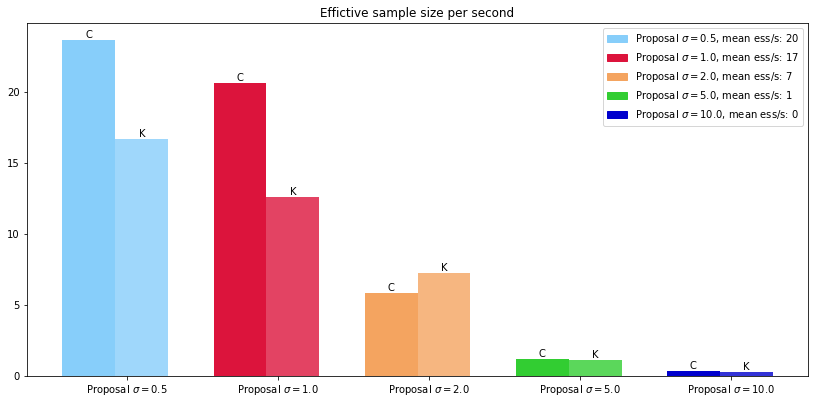

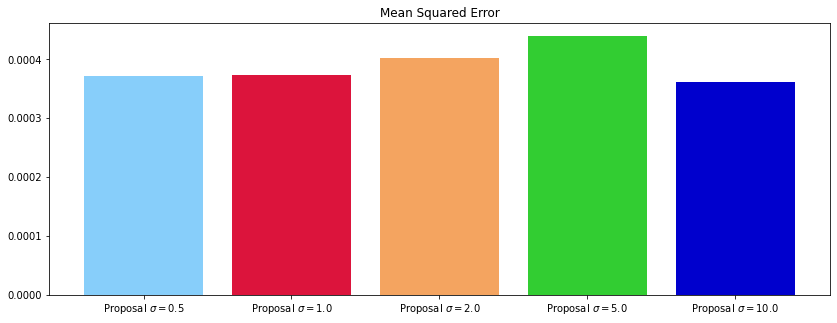

In [187]:
# Model predictions
error = []
for theta_hat in theta_hats:
  u_hat = pendulum_analytical_solution(theta_hat[0],theta_hat[1],t)
  mse = np.mean((u_true-u_hat)**2)
  error.append(mse)

# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array()))
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
ess = np.array(ess)
ess_n = np.array(ess_n)
performances = np.array(performances)
ess = np.reshape(ess,(len(method_names),2))
ess_n = np.reshape(ess_n,(len(method_names),2))
performances = np.reshape(performances,(len(method_names),2))

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

N = ess.shape[0]
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
labels = ["C"]*N + ["K"]*N
handles = [plt.Rectangle((0,0),1,1, color=cols[i]) for i in range(len(method_names))]

f,ax = plt.subplots(figsize=(14,5))
names = [method_names[i] + ", mean ess: " + str(round(e)) for i,e in enumerate(np.mean(ess,axis=1))]
ax.bar(ind,ess[:,0],width, color = cols)
ax.bar(ind+width,ess[:,1],width, color = cols, alpha=0.8)
ax.set_xticks(ind + 0.25)
ax.set_title('Effictive sample size')
ax.set_xticklabels(method_names)
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
ax.legend(handles, names)
f.subplots_adjust(bottom=-0.1)
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
names = [method_names[i] + ", mean ess/s: " + str(round(e)) for i,e in enumerate(np.mean(performances,axis=1))]
ax.bar(ind,performances[:,0],width, color = cols)
ax.bar(ind+width,performances[:,1],width, color = cols, alpha=0.8)
ax.set_xticks(ind + 0.25)
ax.set_title('Effictive sample size per second')
ax.set_xticklabels(method_names)
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0, label, ha="center", va="bottom"
    )
ax.legend(handles, names)
f.subplots_adjust(bottom=-0.1)
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("Mean Squared Error")
# ax.set_ylim([0,0.001])
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

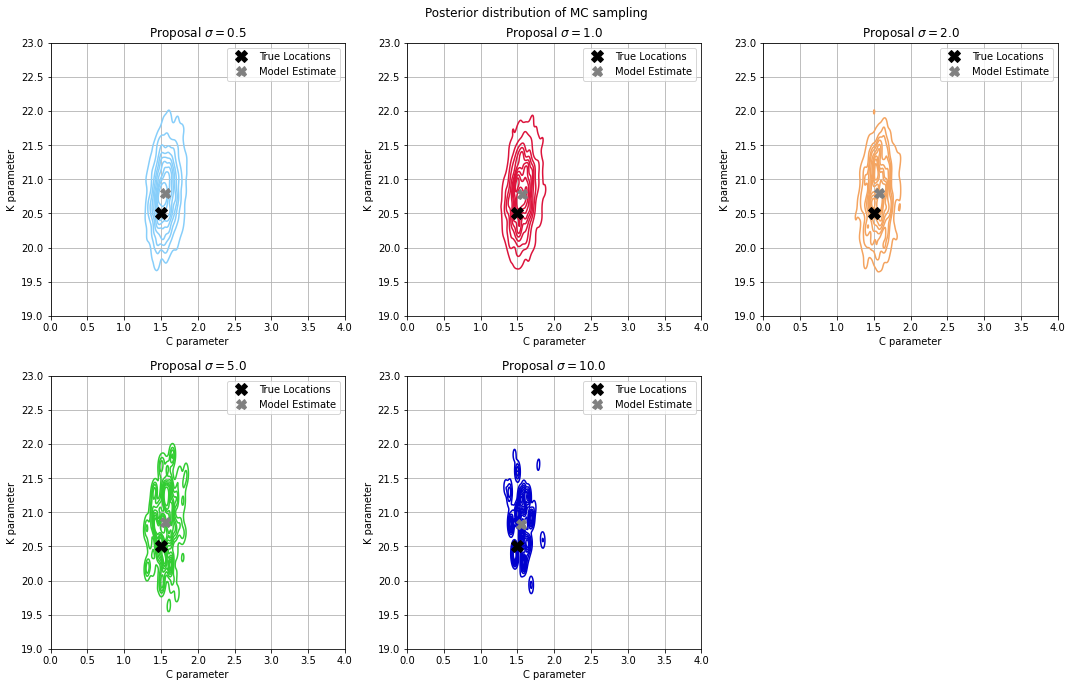

In [188]:
# minC = min(all_traces[0]['theta'][:,0])
# maxC = max(all_traces[0]['theta'][:,0])
# minK = min(all_traces[0]['theta'][:,1])
# maxK = min(all_traces[0]['theta'][:,1])

# for i in range(1,len(all_traces)):
#   if min(all_traces[i]['theta'][:,0]) <= minC:
#     minC = min(all_traces[i]['theta'][:,0])
#   if max(all_traces[i]['theta'][:,0]) >= maxC:
#     maxC = max(all_traces[i]['theta'][:,0])
#   if min(all_traces[i]['theta'][:,1]) <= minK:
#     minK = min(all_traces[i]['theta'][:,1])
#   if max(all_traces[i]['theta'][:,1]) >= maxK:
#     maxK = max(all_traces[i]['theta'][:,1])

# limC = [minC,maxC]
# limK = [minK,maxK]

limC = [0,4]
limK = [19,23]

N,M = (2,3)
f,ax = plt.subplots(N,M, figsize=(5*M,5*N))
ax = ax.flatten()
for i, trace in enumerate(all_traces):
  sn.kdeplot(x = trace['theta'][:,0], y = trace['theta'][:,1],ax = ax[i], color = cols[i])
  # sn.kdeplot(x = trace['theta'][:,0], y = trace['theta'][:,1],ax = ax[i], fill = True, cmap="mako")
  ax[i].set_xlabel('C parameter', fontsize=10)
  ax[i].set_ylabel('K parameter', fontsize=10)
  ax[i].set_title(method_names[i])
  ax[i].grid('on')
  ax[i].set_xlim(limC)
  ax[i].set_ylim(limK)
  # ax[i].axvline(x=C_true,color="k",alpha = 1.0, label=r"True Locations")
  # ax[i].axhline(y=K_true,color="k",alpha = 1.0)
  ax[i].plot(C_true,K_true,"Xk", alpha=1.0, markersize=12, label="True Locations")
  ax[i].plot(theta_hats[i][0],theta_hats[i][1],"X",color="gray", alpha=1.0, markersize=10, label="Model Estimate")
  ax[i].legend()
for j in range(i+1,N*M):
  ax[j].set_visible(False)
f.suptitle("Posterior distribution of MC sampling")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
f.savefig(image_folder + "posterior.png",bbox_inches='tight',dpi=300)

## Uneven Proposal Variance Test


In [139]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "dual_parameter_estimation/uneven_proposal_variance_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0

# Generate training data
T_max = 5
size = 500
time_config = [T_max, size]
t = get_time(time_config)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

Create coarse data for the different levels of MLMCMC

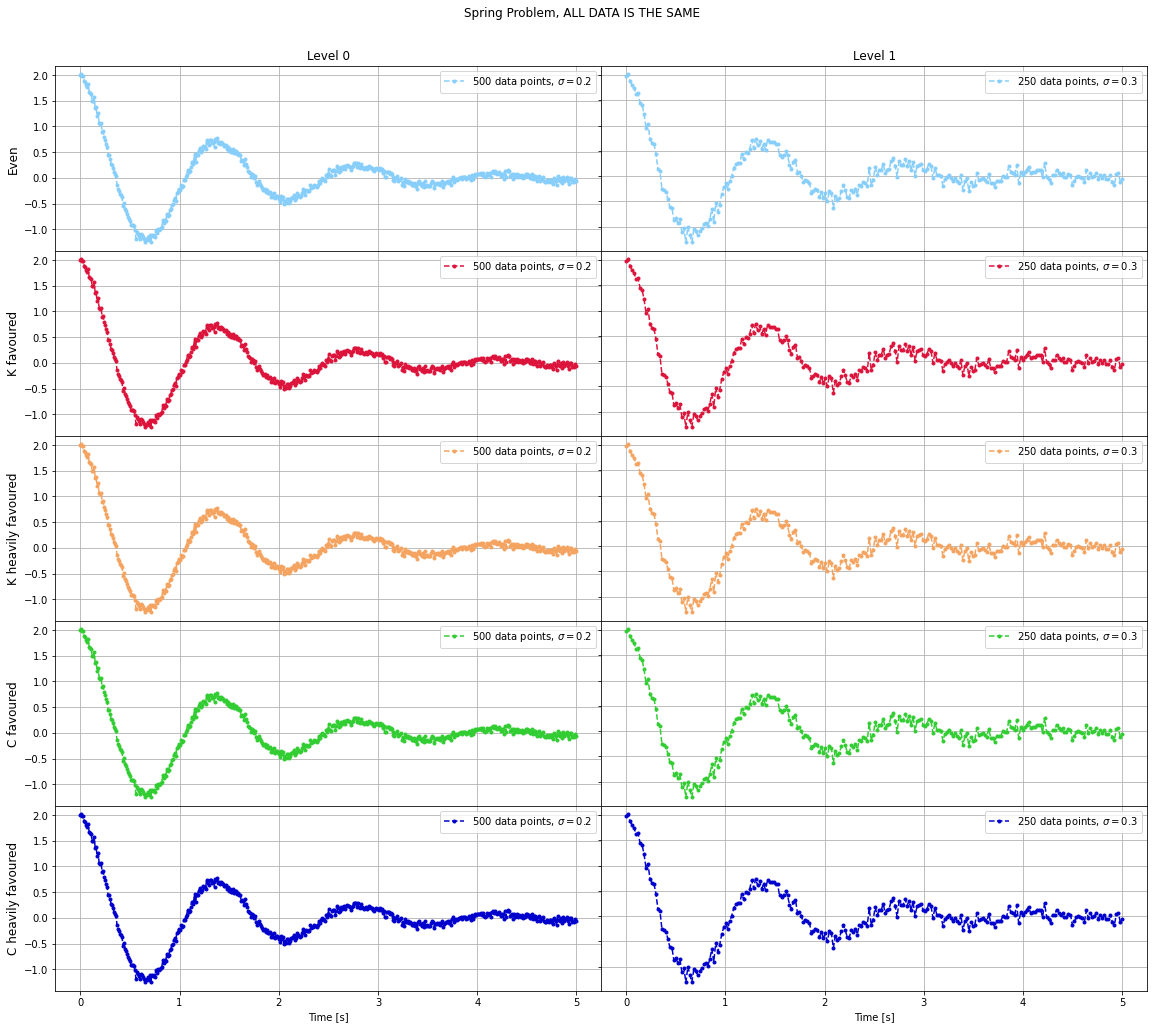

In [140]:
datasets = []
method_names = []

# Add noise
sigmas = [0.2, 0.3]
noises = []
for sigma in sigmas:
  noises.append(np.random.normal(0, sigma ** 2, u_true.shape))

# Dataset 1
dataset = []
dataset.append(u_true + noises[0])
dataset.append((u_true + noises[1])[::2])
datasets.append(dataset)
method_names.append("Even")

# Dataset 1
dataset = []
dataset.append(u_true + noises[0])
dataset.append((u_true + noises[1])[::2])
datasets.append(dataset)
method_names.append("K favoured")

# Dataset 1
dataset = []
dataset.append(u_true + noises[0])
dataset.append((u_true + noises[1])[::2])
datasets.append(dataset)
method_names.append("K heavily favoured")

# Dataset 1
dataset = []
dataset.append(u_true + noises[0])
dataset.append((u_true + noises[1])[::2])
datasets.append(dataset)
method_names.append("C favoured")

# Dataset 1
dataset = []
dataset.append(u_true + noises[0])
dataset.append((u_true + noises[1])[::2])
datasets.append(dataset)
# method_names.append("Skewed")
method_names.append("C heavily favoured")

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    if j == 0:
      ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'--.',color = cols[i], label = rf"{data.shape[0]} data points, $\sigma = {sigmas[0]}$")
    else:
      ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'--.',color = cols[i], label = rf"{data.shape[0]} data points, $\sigma = {sigmas[1]}$")
    ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Spring Problem, ALL DATA IS THE SAME")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)

In [141]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:
    logl.append(LogLike2(my_loglik2, data, T_max, sigma = 0.7))
  logls.append(logl)

Create coarse models

In [142]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.array([4,22])
# cov_priors = [np.eye(2), np.array([[3,0],[0,1]]), np.array([[10,0],[0,1]]), np.array([[1,0],[0,3]]), np.array([[1,0.9],[0.9,1]])]
cov_priors = [np.eye(2), np.eye(2), np.eye(2), np.eye(2), np.eye(2)]
# Normalize the covariance matrices
# for i,cov in enumerate(cov_priors):
#   cov_priors[i] = 2*cov/np.linalg.norm(cov)

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_priors[i], shape=(2,))

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](theta))

      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)
all_fine_models = []
for i in range(len(datasets)):
  # Constructing the fine model
  with pm.Model() as fine_model:
    theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_priors[i], shape=(2,))
    pm.Potential("likelihood", logls[i][0](theta))
  all_fine_models.append(fine_model)

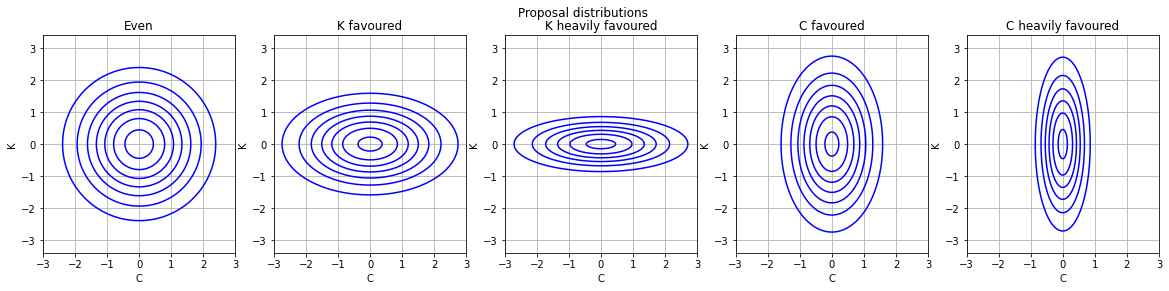

In [145]:
from scipy.stats import multivariate_normal
# cov_priors = [np.eye(2), np.array([[3,0],[0,1]]), np.array([[10,0],[0,1]]), np.array([[1,0],[0,3]]), np.array([[1,0.9],[0.9,1]])]
cov_priors = [np.eye(2), np.array([[3,0],[0,1]]), np.array([[10,0],[0,1]]), np.array([[1,0],[0,3]]), np.array([[1,0],[0,10]])]
for i,cov in enumerate(cov_priors):
  cov_priors[i] = 2*cov/np.linalg.norm(cov)
n_points = 1000
x, _ = np.linspace(0-3, 0+3, n_points,retstep=True)
y, _ = np.linspace(0-3, 0+3, n_points,retstep=True)
x_grid, y_grid = np.meshgrid(x, y) 
X = np.array([x_grid.ravel(), y_grid.ravel()]).T

N,M = (1,5)
f,ax = plt.subplots(N,M, figsize=(M*4,N*4))
ax = ax.flatten()
for i, cov in enumerate(cov_priors):
  y = multivariate_normal.pdf(X, mean=np.zeros(2), cov=cov)
  y = y.reshape(n_points, n_points)

  ax[i].contour(x_grid, y_grid, y, colors = "blue")
  ax[i].axis('equal')
  ax[i].grid('on')
  ax[i].set_ylabel('K')
  ax[i].set_xlabel('C')
  ax[i].set_title(method_names[i])
for j in range(i+1,N*M):
  ax[j].set_visible(False)
f.suptitle("Proposal distributions")
plt.show()
f.savefig(image_folder + "proposal_distributions.png",bbox_inches='tight',dpi=400)


Set MCMC parameters for inference

In [146]:
# Number of draws from the distribution
ndraws = 3000

# Number of independent chains.
nchains = 3

# Number of burn-in samples
nburn = 1000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [3,5]                     # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

# Proposal covariance matrix
# Ss = [np.eye(2), np.array([[3,0],[0,1]]), np.array([[10,0],[0,1]]), np.array([[1,0],[0,3]]), np.array([[1,0.9],[0.9,1]])]
Ss = [np.asarray([1,1]), np.asarray([3,1]), np.asarray([10,1]), np.asarray([1,3]), np.asarray([1,10])]
for i,cov in enumerate(Ss):
  Ss[i] = 2*cov/np.linalg.norm(cov)

In [147]:
runtimes = []
all_traces = []
for i,(fine_model,coarse_models) in enumerate(zip(all_fine_models,all_coarse_models)):
  # proposal = pm.step_methods.MultivariateNormalProposal(Ss[i],tune =False)
  with fine_model:
    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)

      trace = pm.sample(
          draws=ndraws,
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          cores=10,
          )
    else:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)],
          base_S = Ss[i],
          # proposal_dist = proposal
          )
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False
                        )
    runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 60 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 61 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 60 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 63 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [theta]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 59 seconds.
The number of effective samples is smaller than 25% for some parameters.


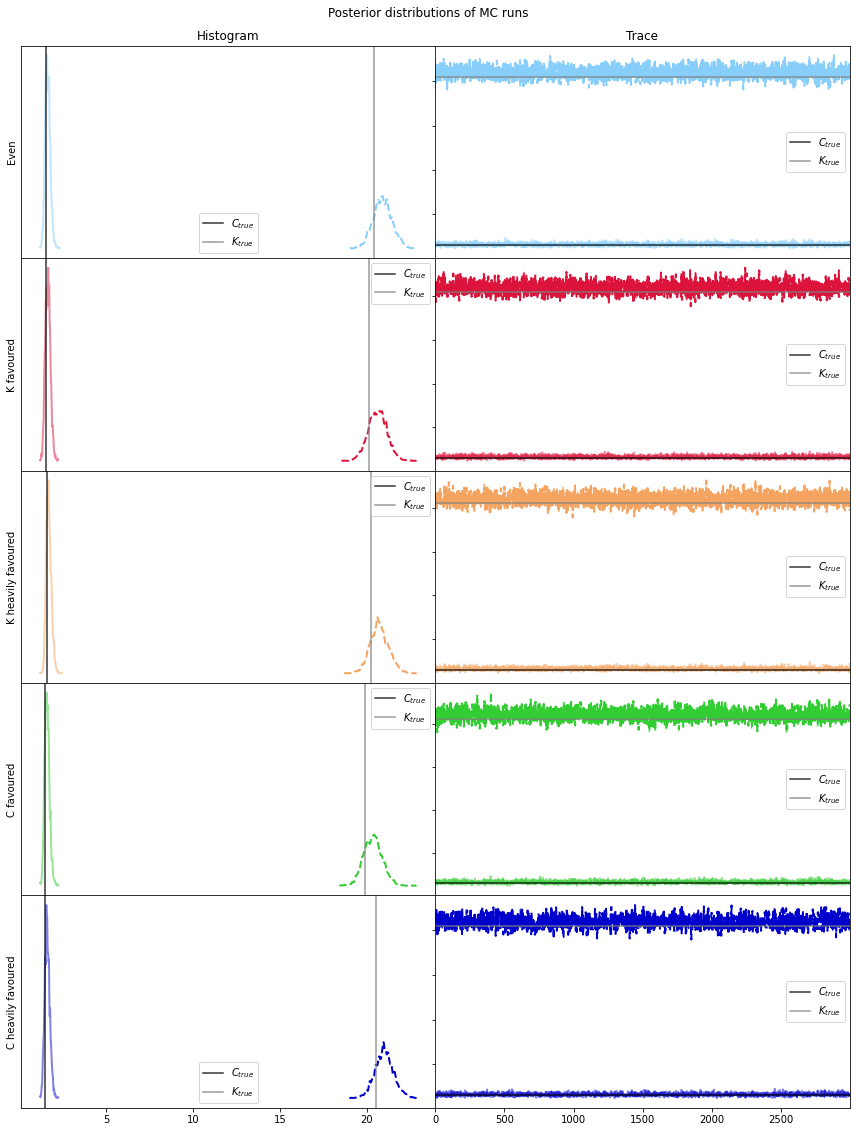

In [148]:
f,ax = plt.subplots(len(all_traces),2, figsize=(12,3.3*len(all_traces)))
for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    chain_prop = {"color": [cols[i], cols[i]]}
    compact_prop={"lw": [2,2], "ls": ("-", "--"),"alpha":[0.5, 1.0]}
    az.plot_trace(trace, axes = ax[None,i,:], compact = True, combined=True, compact_prop=compact_prop, chain_prop=chain_prop)
    ax[i,0].set_ylabel(method_names[i])
    ax[i,0].set_title("")
    ax[i,1].set_title("")
    ax[i,0].axvline(x=C_true,color="k",alpha = 0.8, label=r"$C_{true}$")
    ax[i,0].axvline(x=K_true,color="grey",alpha = 0.8, label=r"$K_{true}$")
    ax[i,1].axhline(y=C_true,color="k",alpha = 0.8, label=r"$C_{true}$")
    ax[i,1].axhline(y=K_true,color="grey",alpha = 0.8, label=r"$K_{true}$")
    ax[i,0].legend()
    ax[i,1].legend()
for i in range(len(all_traces)):
  for j in range(2):
    if j == 0:
      if i == len(all_traces)-1:
        continue
      else:
        ax[i,j].set_xticklabels([])
    else:
      if i == len(all_traces)-1:
        ax[i,j].set_yticklabels([])
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
ax[0,0].set_title("Histogram")
ax[0,1].set_title("Trace")
f.suptitle("Posterior distributions of MC runs")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "trace_plots.png",bbox_inches='tight',dpi=300)

In [149]:
theta_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    display(az.summary(trace))
    theta_hats.append(np.mean(trace['theta'],axis=0))


Even Sampler:
 runtime :  61.28325176239014


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.605  0.146   1.352    1.885  ...    0.002    1963.0    2870.0    1.0
theta[1]  20.975  0.542  20.034   22.069  ...    0.008    2219.0    2195.0    1.0

[2 rows x 9 columns]


K favoured Sampler:
 runtime :  62.42767024040222


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.609  0.149   1.340    1.895  ...    0.002    1965.0    2804.0    1.0
theta[1]  20.995  0.549  19.957   22.010  ...    0.009    2011.0    2557.0    1.0

[2 rows x 9 columns]


K heavily favoured Sampler:
 runtime :  61.54699349403381


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.603  0.150   1.340    1.891  ...    0.003    1779.0    2481.0   1.01
theta[1]  20.983  0.541  19.959   21.998  ...    0.008    2046.0    2198.0   1.00

[2 rows x 9 columns]


C favoured Sampler:
 runtime :  64.00051617622375


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.597  0.145   1.339    1.876  ...    0.003    1491.0    2619.0    1.0
theta[1]  20.999  0.552  19.989   22.027  ...    0.009    1950.0    2134.0    1.0

[2 rows x 9 columns]


C heavily favoured Sampler:
 runtime :  60.045745849609375


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.602  0.146   1.323    1.868  ...    0.003    1614.0    1987.0    1.0
theta[1]  20.984  0.541  19.932   21.997  ...    0.010    1532.0    1914.0    1.0

[2 rows x 9 columns]

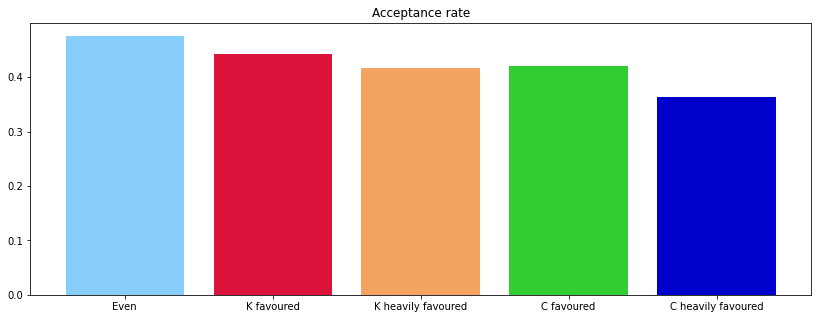

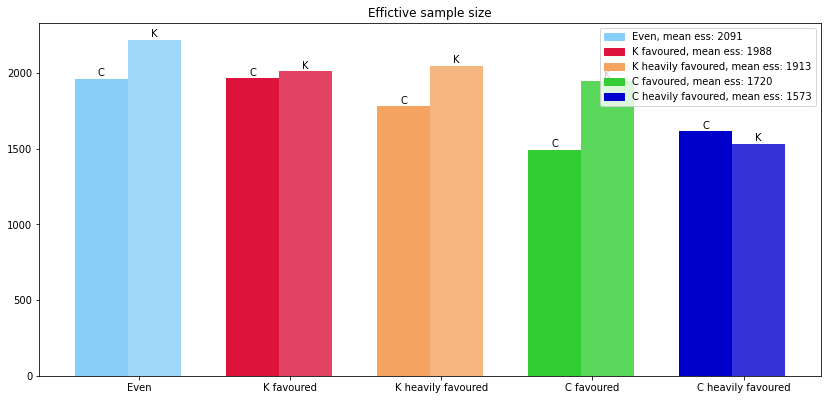

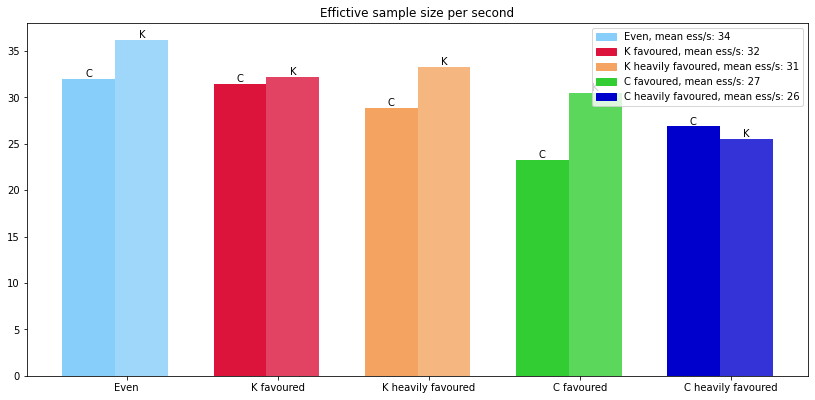

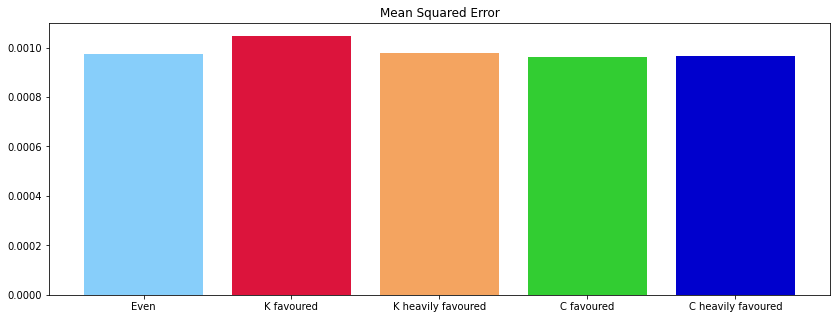

In [156]:
# Model predictions
error = []
for theta_hat in theta_hats:
  u_hat = pendulum_analytical_solution(theta_hat[0],theta_hat[1],t)
  mse = np.mean((u_true-u_hat)**2)
  error.append(mse)

# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
ess = np.array(ess)
ess_n = np.array(ess_n)
performances = np.array(performances)

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

N = ess.shape[0]
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
labels = ["C"]*N + ["K"]*N
handles = [plt.Rectangle((0,0),1,1, color=cols[i]) for i in range(len(method_names))]

# N = ess.shape[0]
# ind = np.arange(N)  # the x locations for the groups
# width = 0.35       # the width of the bars
# labels = ["C"]*N + ["K"]*N

# f,ax = plt.subplots(figsize=(14,5))
# ax.bar(ind,ess[:,0],width, color = cols)
# ax.bar(ind+width,ess[:,1],width, color = cols, alpha=0.8)
# ax.set_xticks(ind + 0.25)
# ax.set_title('Effictive sample size')
# ax.set_xticklabels(method_names)
# rects = ax.patches
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(
#         rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
#     )
# plt.show()
# f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

# f,ax = plt.subplots(figsize=(14,5))
# ax.bar(ind,performances[:,0],width, color = cols)
# ax.bar(ind+width,performances[:,1],width, color = cols, alpha=0.8)
# ax.set_xticks(ind + 0.25)
# ax.set_title('Effictive sample size per second')
# ax.set_xticklabels(method_names)
# rects = ax.patches
# for rect, label in zip(rects, labels):
#     height = rect.get_height()
#     ax.text(
#         rect.get_x() + rect.get_width() / 2, height + 0, label, ha="center", va="bottom"
#     )
# plt.show()
# f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)
f,ax = plt.subplots(figsize=(14,5))
names = [method_names[i] + ", mean ess: " + str(round(e)) for i,e in enumerate(np.mean(ess,axis=1))]
ax.bar(ind,ess[:,0],width, color = cols)
ax.bar(ind+width,ess[:,1],width, color = cols, alpha=0.8)
ax.set_xticks(ind + 0.25)
ax.set_title('Effictive sample size')
ax.set_xticklabels(method_names)
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
ax.legend(handles, names)
f.subplots_adjust(bottom=-0.1)
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
names = [method_names[i] + ", mean ess/s: " + str(round(e)) for i,e in enumerate(np.mean(performances,axis=1))]
ax.bar(ind,performances[:,0],width, color = cols)
ax.bar(ind+width,performances[:,1],width, color = cols, alpha=0.8)
ax.set_xticks(ind + 0.25)
ax.set_title('Effictive sample size per second')
ax.set_xticklabels(method_names)
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0, label, ha="center", va="bottom"
    )
ax.legend(handles, names)
f.subplots_adjust(bottom=-0.1)
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("Mean Squared Error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

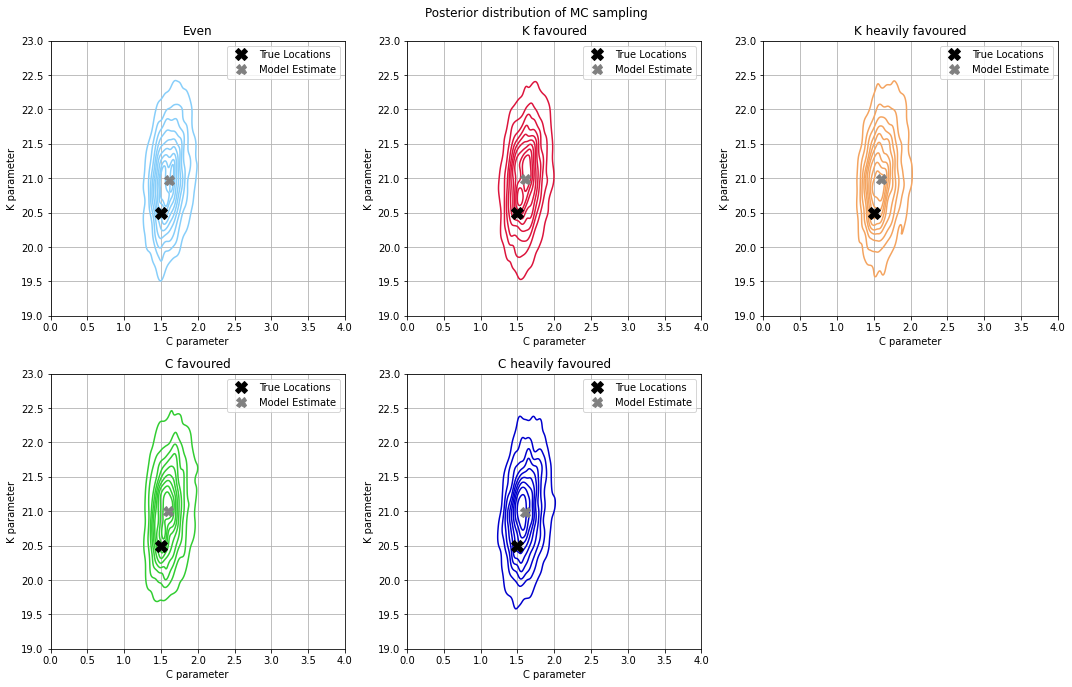

In [151]:
# minC = min(all_traces[0]['theta'][:,0])
# maxC = max(all_traces[0]['theta'][:,0])
# minK = min(all_traces[0]['theta'][:,1])
# maxK = min(all_traces[0]['theta'][:,1])

# for i in range(1,len(all_traces)):
#   if min(all_traces[i]['theta'][:,0]) <= minC:
#     minC = min(all_traces[i]['theta'][:,0])
#   if max(all_traces[i]['theta'][:,0]) >= maxC:
#     maxC = max(all_traces[i]['theta'][:,0])
#   if min(all_traces[i]['theta'][:,1]) <= minK:
#     minK = min(all_traces[i]['theta'][:,1])
#   if max(all_traces[i]['theta'][:,1]) >= maxK:
#     maxK = max(all_traces[i]['theta'][:,1])

# limC = [minC,maxC]
# limK = [minK,maxK]

limC = [0,4]
limK = [19,23]

N,M = (2,3)
f,ax = plt.subplots(N,M, figsize=(5*M,5*N))
ax = ax.flatten()
for i, trace in enumerate(all_traces):
  sn.kdeplot(x = trace['theta'][:,0], y = trace['theta'][:,1],ax = ax[i], color = cols[i])
  # sn.kdeplot(x = trace['theta'][:,0], y = trace['theta'][:,1],ax = ax[i], fill = True, cmap="mako")
  ax[i].set_xlabel('C parameter', fontsize=10)
  ax[i].set_ylabel('K parameter', fontsize=10)
  ax[i].set_title(method_names[i])
  ax[i].grid('on')
  ax[i].set_xlim(limC)
  ax[i].set_ylim(limK)
  # ax[i].axvline(x=C_true,color="k",alpha = 1.0, label=r"True Locations")
  # ax[i].axhline(y=K_true,color="k",alpha = 1.0)
  ax[i].plot(C_true,K_true,"Xk", alpha=1.0, markersize=12, label="True Locations")
  ax[i].plot(theta_hats[i][0],theta_hats[i][1],"X",color="gray", alpha=1.0, markersize=10, label="Model Estimate")
  ax[i].legend()
for j in range(i+1,N*M):
  ax[j].set_visible(False)
f.suptitle("Posterior distribution of MC sampling")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
f.savefig(image_folder + "posterior.png",bbox_inches='tight',dpi=300)

## Subsample rate test


In [ ]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "dual_parameter_estimation/subsample_rate_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0

# Generate training data
T_max = 5
size = 200
time_config = [T_max, size]
t = get_time(time_config)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

Create coarse data for the different levels of MLMCMC

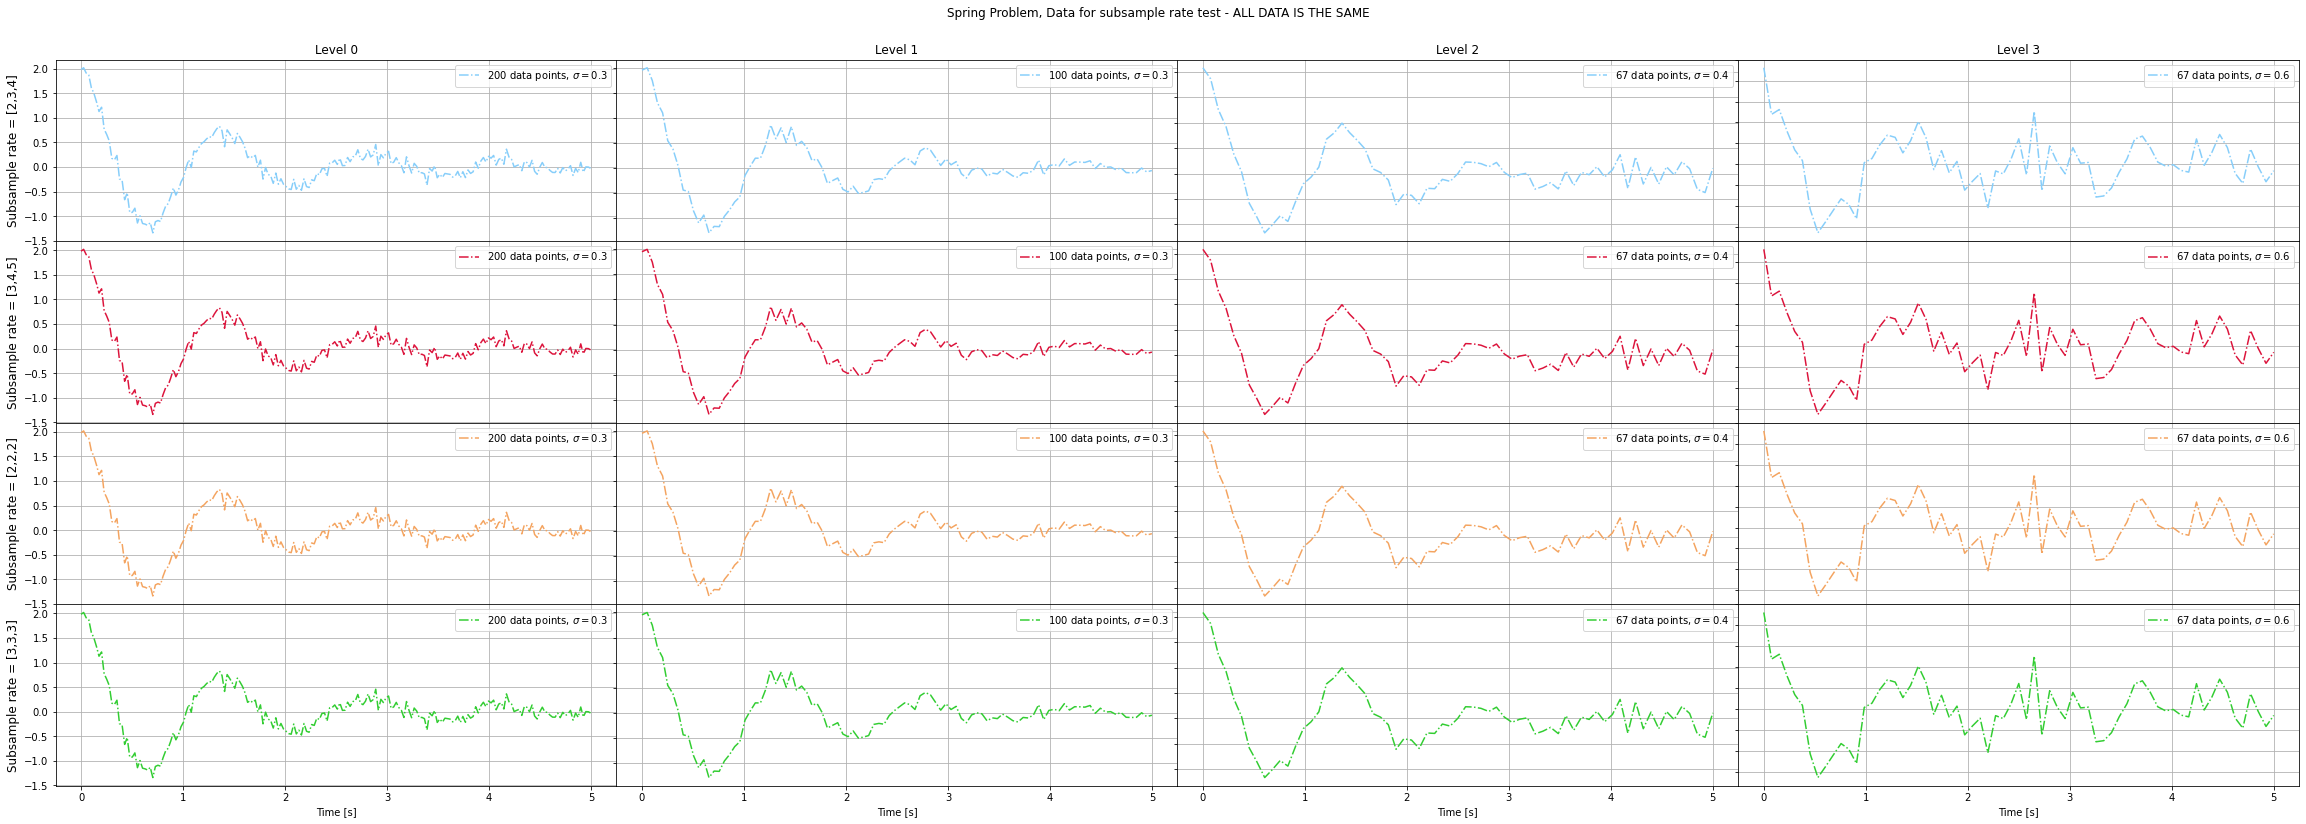

In [ ]:
datasets = []
method_names = []

# Add noise
sigmas = [0.3, 0.3, 0.4, 0.6]
noises = []
for sigma in sigmas:
  noises.append(np.random.normal(0, sigma ** 2, u_true.shape))

# Dataset 1
dataset = []
dataset.append(u_true + noises[0])
dataset.append((u_true + noises[1])[::2])
dataset.append((u_true + noises[2])[::3])
dataset.append((u_true + noises[3])[::3])
datasets.append(dataset)
method_names.append("Subsample rate = [2,3,4]")

# Dataset 1
dataset = []
dataset.append(u_true + noises[0])
dataset.append((u_true + noises[1])[::2])
dataset.append((u_true + noises[2])[::3])
dataset.append((u_true + noises[3])[::3])
datasets.append(dataset)
method_names.append("Subsample rate = [3,4,5]")

# Dataset 1
dataset = []
dataset.append(u_true + noises[0])
dataset.append((u_true + noises[1])[::2])
dataset.append((u_true + noises[2])[::3])
dataset.append((u_true + noises[3])[::3])
datasets.append(dataset)
method_names.append("Subsample rate = [2,2,2]")

# Dataset 1
dataset = []
dataset.append(u_true + noises[0])
dataset.append((u_true + noises[1])[::2])
dataset.append((u_true + noises[2])[::3])
dataset.append((u_true + noises[3])[::3])
datasets.append(dataset)
method_names.append("Subsample rate = [3,3,3]")

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'-.',color = cols[i], label = rf"{data.shape[0]} data points, $\sigma = {sigmas[j]}$")
    ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Spring Problem, Data for subsample rate test - ALL DATA IS THE SAME")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)

In [ ]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:
    logl.append(LogLike2(my_loglik2, data, T_max, sigma = 0.7))
  logls.append(logl)

Create coarse models

In [ ]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.array([4,22])
cov_prior = np.eye(2)

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:

          # Multivariate normal prior.
          theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(2,))

          # Use the Potential class to evaluate likelihood
          pm.Potential("likelihood", logls[i][j](theta))

      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)

[<pymc3.model.Model object at 0x7eff852c1150>, <pymc3.model.Model object at 0x7eff6f9a0ed0>, <pymc3.model.Model object at 0x7eff6f8cb250>]
[<pymc3.model.Model object at 0x7eff6dbd6450>, <pymc3.model.Model object at 0x7eff6bb49ad0>, <pymc3.model.Model object at 0x7eff6fc71b10>]
[<pymc3.model.Model object at 0x7eff70560350>, <pymc3.model.Model object at 0x7eff6ffe8dd0>, <pymc3.model.Model object at 0x7eff70613950>]
[<pymc3.model.Model object at 0x7eff73884b10>, <pymc3.model.Model object at 0x7eff7015f890>, <pymc3.model.Model object at 0x7eff6b563950>]


Create fine models

In [ ]:
all_fine_models = []

for i in range(len(datasets)):
  # Constructing the fine model
  with pm.Model() as fine_model:
    theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(2,))
    pm.Potential("likelihood", logls[i][0](theta))
  all_fine_models.append(fine_model)

Set MCMC parameters for inference

In [ ]:
# Number of draws from the distribution
ndraws = 1500

# Number of independent chains.
nchains = 2

# Number of burn-in samples
nburn = 800

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsubs = [[2,3,4],[3,4,5],[2,2,2],[3,3,3]]                     # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

In [ ]:
runtimes = []
all_traces = []
for fine_model,coarse_models,nsub in zip(all_fine_models,all_coarse_models,nsubs):
  with fine_model:
      step_mlda = pm.MLDA(
        coarse_models=coarse_models, subsampling_rates=nsub
      )
      # Sample using MLDA
      t_start = time.time()
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False
                        )
      runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)
  print("Total runtime: " + str(datetime.timedelta(seconds=int(runtime)))[2:])

/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (2 chains in 10 jobs)
MLDA: [theta]


Sampling 2 chains for 800 tune and 1_500 draw iterations (1_600 + 3_000 draws total) took 330 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."


Total runtime: 05:30


Multiprocess sampling (2 chains in 10 jobs)
MLDA: [theta]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
Sampling 2 chains for 800 tune and 1_500 draw iterations (1_600 + 3_000 draws total) took 442 seconds.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."


Total runtime: 07:22


Multiprocess sampling (2 chains in 10 jobs)
MLDA: [theta]


Sampling 2 chains for 800 tune and 1_500 draw iterations (1_600 + 3_000 draws total) took 75 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."


Total runtime: 01:15


Multiprocess sampling (2 chains in 10 jobs)
MLDA: [theta]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until
Sampling 2 chains for 800 tune and 1_500 draw iterations (1_600 + 3_000 draws total) took 185 seconds.
The number of effective samples is smaller than 25% for some parameters.


Total runtime: 03:05


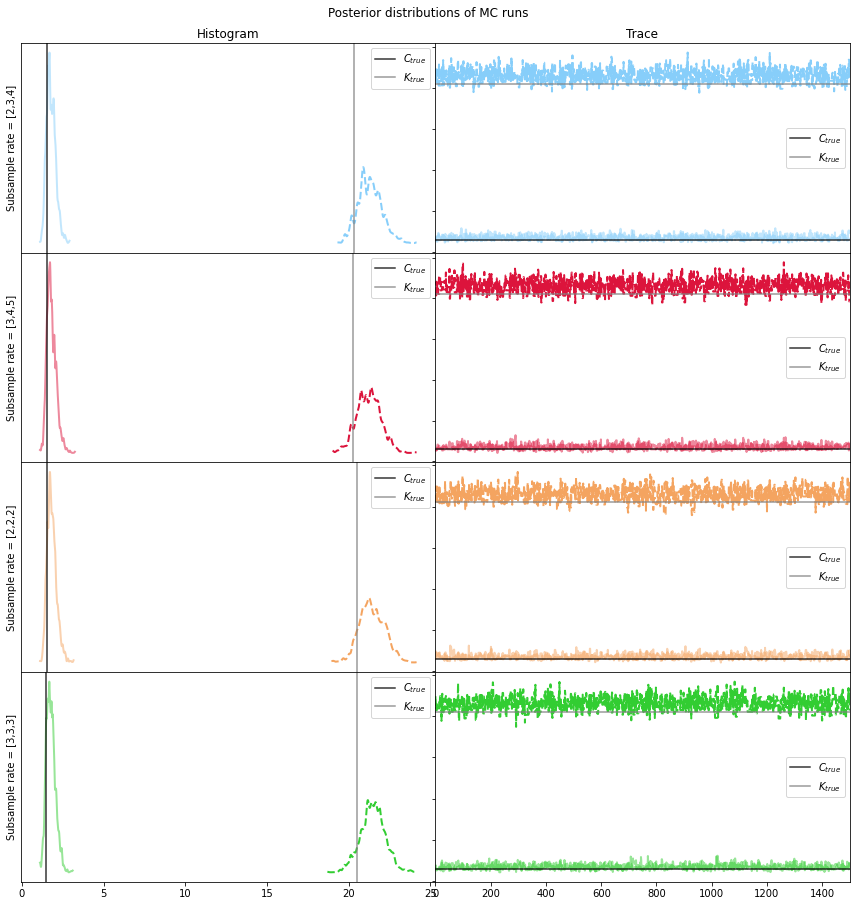

In [ ]:
f,ax = plt.subplots(len(all_traces),2, figsize=(12,3.3*len(all_traces)))
for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  with fine_model:
    chain_prop = {"color": [cols[i], cols[i]]}
    compact_prop={"lw": [2,2], "ls": ("-", "--"),"alpha":[0.5, 1.0]}
    az.plot_trace(trace, axes = ax[None,i,:], compact = True, combined=True, compact_prop=compact_prop, chain_prop=chain_prop)
    ax[i,0].set_ylabel(method_names[i])
    ax[i,0].set_title("")
    ax[i,1].set_title("")
    ax[i,0].axvline(x=C_true,color="k",alpha = 0.8, label=r"$C_{true}$")
    ax[i,0].axvline(x=K_true,color="grey",alpha = 0.8, label=r"$K_{true}$")
    ax[i,1].axhline(y=C_true,color="k",alpha = 0.8, label=r"$C_{true}$")
    ax[i,1].axhline(y=K_true,color="grey",alpha = 0.8, label=r"$K_{true}$")
    ax[i,0].legend()
    ax[i,1].legend()
for i in range(len(all_traces)):
  for j in range(2):
    if j == 0:
      if i == len(all_traces)-1:
        continue
      else:
        ax[i,j].set_xticklabels([])
    else:
      if i == len(all_traces)-1:
        ax[i,j].set_yticklabels([])
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
ax[0,0].set_title("Histogram")
ax[0,1].set_title("Trace")
f.suptitle("Posterior distributions of MC runs")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "trace_plots.png",bbox_inches='tight',dpi=300)

In [ ]:
theta_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    display(az.summary(trace))
    theta_hats.append(np.mean(trace['theta'],axis=0))


Subsample rate = [2,3,4] Sampler:
 runtime :  330.2476749420166


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.769  0.280   1.329    2.334  ...    0.006     985.0    1264.0   1.01
theta[1]  21.474  0.729  20.154   22.882  ...    0.019     692.0     697.0   1.00

[2 rows x 9 columns]


Subsample rate = [3,4,5] Sampler:
 runtime :  442.58610677719116


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.757  0.288   1.250    2.286  ...    0.007     937.0     813.0   1.01
theta[1]  21.461  0.753  20.125   22.890  ...    0.019     796.0     698.0   1.00

[2 rows x 9 columns]


Subsample rate = [2,2,2] Sampler:
 runtime :  75.01467728614807


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.773  0.291   1.263    2.304  ...    0.007     767.0     971.0   1.01
theta[1]  21.456  0.769  20.216   23.008  ...    0.022     591.0     645.0   1.00

[2 rows x 9 columns]


Subsample rate = [3,3,3] Sampler:
 runtime :  185.0755753517151


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
theta[0]   1.773  0.281   1.280    2.305  ...    0.007     847.0    1206.0   1.00
theta[1]  21.486  0.745  20.061   22.804  ...    0.020     732.0     436.0   1.01

[2 rows x 9 columns]

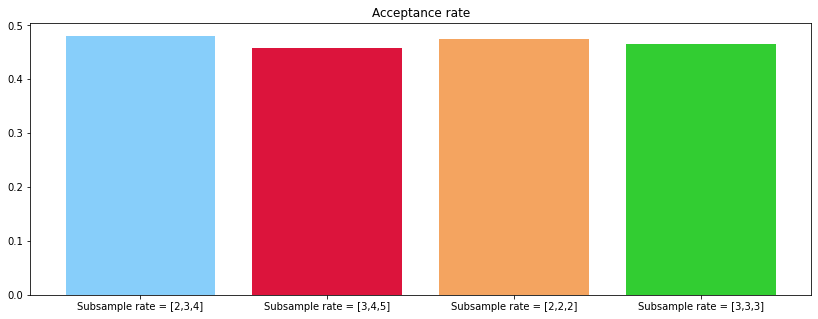

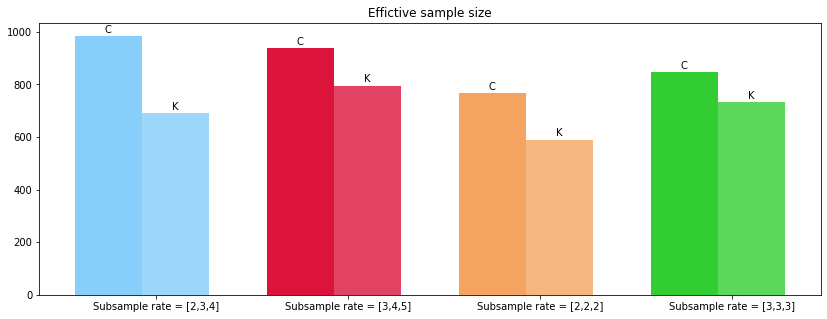

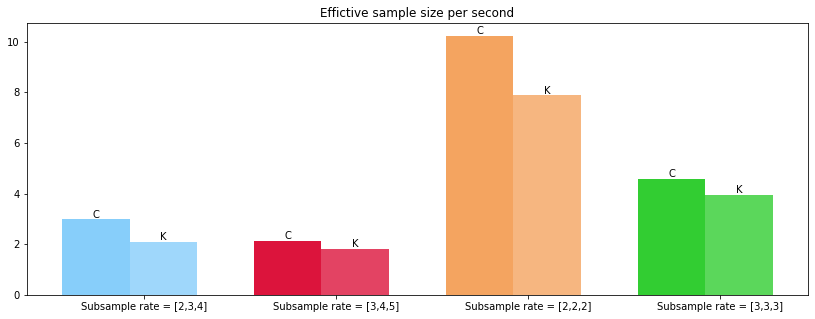

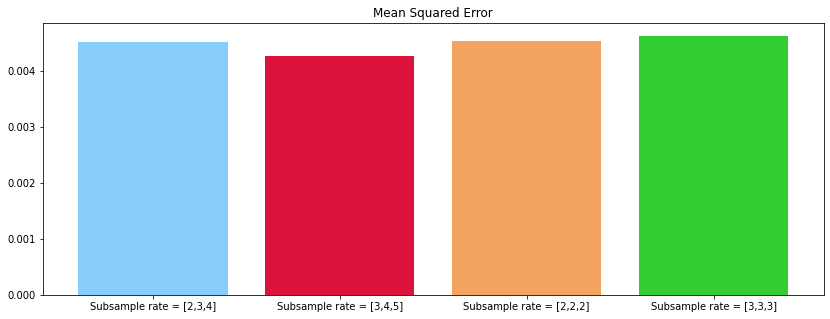

In [ ]:
# Model predictions
error = []
for theta_hat in theta_hats:
  u_hat = pendulum_analytical_solution(theta_hat[0],theta_hat[1],t)
  mse = np.mean((u_true-u_hat)**2)
  error.append(mse)

# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array())[0])
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
ess = np.array(ess)
ess_n = np.array(ess_n)
performances = np.array(performances)

cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

N = ess.shape[0]
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
labels = ["C"]*N + ["K"]*N

f,ax = plt.subplots(figsize=(14,5))
ax.bar(ind,ess[:,0],width, color = cols)
ax.bar(ind+width,ess[:,1],width, color = cols, alpha=0.8)
ax.set_xticks(ind + 0.25)
ax.set_title('Effictive sample size')
ax.set_xticklabels(method_names)
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(ind,performances[:,0],width, color = cols)
ax.bar(ind+width,performances[:,1],width, color = cols, alpha=0.8)
ax.set_xticks(ind + 0.25)
ax.set_title('Effictive sample size per second')
ax.set_xticklabels(method_names)
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0, label, ha="center", va="bottom"
    )
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("Mean Squared Error")
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

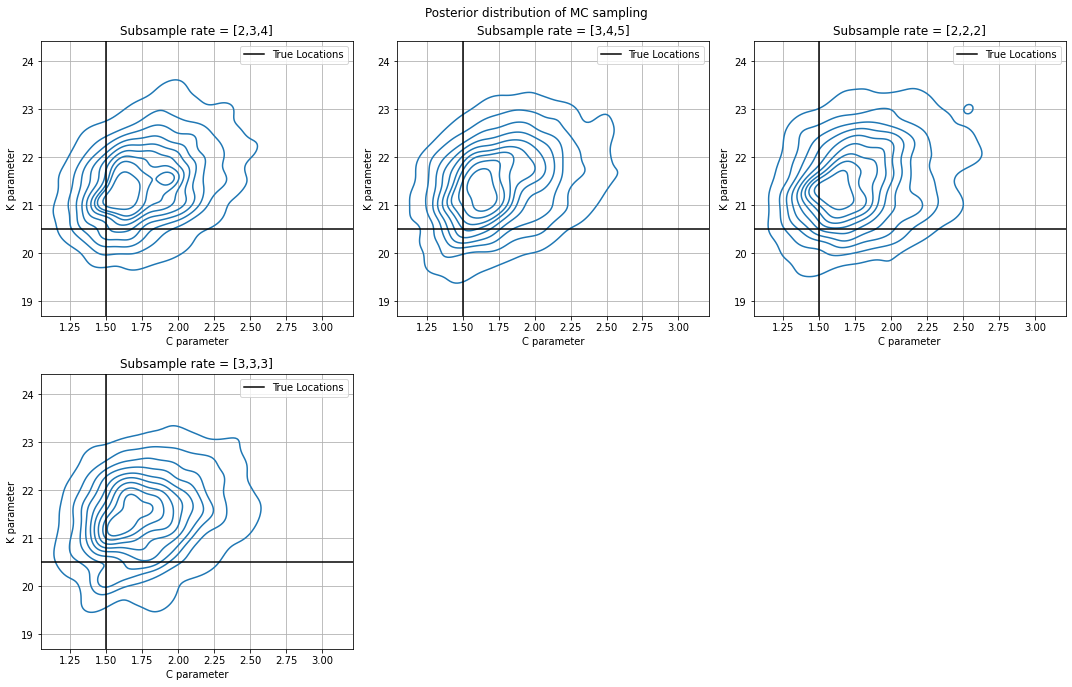

In [ ]:
minC = min(all_traces[0]['theta'][:,0])
maxC = max(all_traces[0]['theta'][:,0])
minK = min(all_traces[0]['theta'][:,1])
maxK = min(all_traces[0]['theta'][:,1])

for i in range(1,len(all_traces)):
  if min(all_traces[i]['theta'][:,0]) <= minC:
    minC = min(all_traces[i]['theta'][:,0])
  if max(all_traces[i]['theta'][:,0]) >= maxC:
    maxC = max(all_traces[i]['theta'][:,0])
  if min(all_traces[i]['theta'][:,1]) <= minK:
    minK = min(all_traces[i]['theta'][:,1])
  if max(all_traces[i]['theta'][:,1]) >= maxK:
    maxK = max(all_traces[i]['theta'][:,1])

limC = [minC,maxC]
limK = [minK,maxK]

N,M = (2,3)
f,ax = plt.subplots(N,M, figsize=(5*M,5*N))
ax = ax.flatten()
for i, trace in enumerate(all_traces):
  sn.kdeplot(x = trace['theta'][:,0], y = trace['theta'][:,1],ax = ax[i])
  # sn.kdeplot(x = trace['theta'][:,0], y = trace['theta'][:,1],ax = ax[i], fill = True, cmap="mako")
  ax[i].set_xlabel('C parameter', fontsize=10)
  ax[i].set_ylabel('K parameter', fontsize=10)
  ax[i].set_title(method_names[i])
  ax[i].grid('on')
  ax[i].set_xlim(limC)
  ax[i].set_ylim(limK)
  ax[i].axvline(x=C_true,color="k",alpha = 1.0, label=r"True Locations")
  ax[i].axhline(y=K_true,color="k",alpha = 1.0)
  ax[i].legend()
for j in range(i+1,N*M):
  ax[j].set_visible(False)
f.suptitle("Posterior distribution of MC sampling")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
f.savefig(image_folder + "posterior.png",bbox_inches='tight',dpi=300)

## Prior Distributions Test


In [201]:
# Set random seed
RANDOM_SEED = 915623497
np.random.seed(RANDOM_SEED)

image_folder = save_folder + "dual_parameter_estimation/Prior_distribution_test/"
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

# Define parameters
K_true = 20.5
C_true = 1.5

# Check that the parameters chosen are valid
assert pendulum_analytical_solution(C_true,K_true, t = 0) == 2
assert dudt(C_true,K_true, t = 0) == -C_true
assert C_true**2 - 4*K_true < 0

# Generate training data
T_max = 5
size = 400
time_config = [T_max, size]
t = get_time(time_config)
u_true = pendulum_analytical_solution(C_true,K_true, t) 

Create coarse data for the different levels of MLMCMC

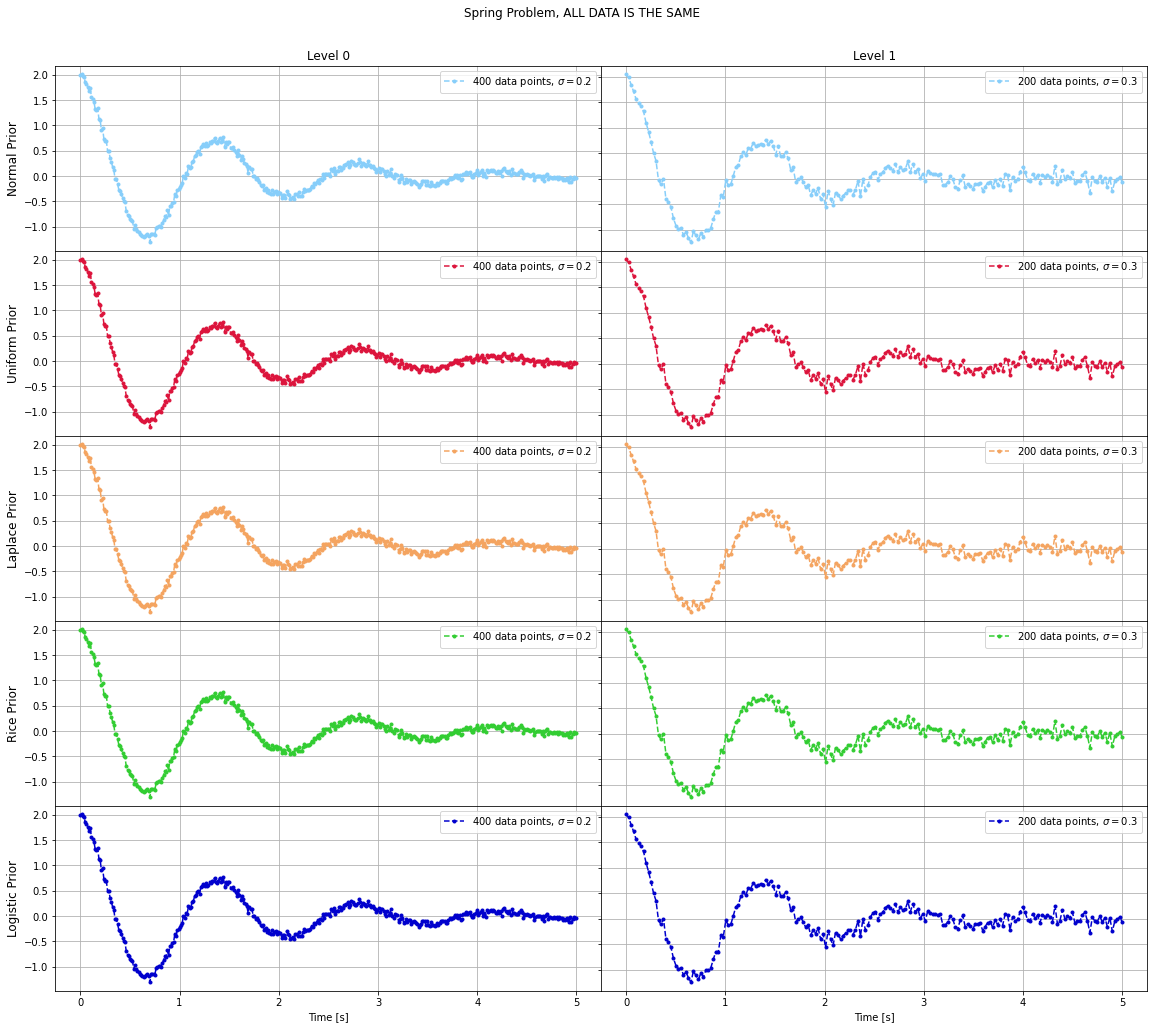

In [202]:
datasets = []
method_names = []

# Add noise
sigmas = [0.2, 0.3]
noises = []
for sigma in sigmas:
  noises.append(np.random.normal(0, sigma ** 2, u_true.shape))

# Dataset
dataset = []
dataset.append(u_true + noises[0])
dataset.append((u_true + noises[1])[::2])
datasets.append(dataset)
method_names.append("Normal Prior")

# Dataset
dataset = []
dataset.append(u_true + noises[0])
dataset.append((u_true + noises[1])[::2])
datasets.append(dataset)
method_names.append("Uniform Prior")

# Dataset
dataset = []
dataset.append(u_true + noises[0])
dataset.append((u_true + noises[1])[::2])
datasets.append(dataset)
method_names.append("Laplace Prior")

# Dataset
dataset = []
dataset.append(u_true + noises[0])
dataset.append((u_true + noises[1])[::2])
datasets.append(dataset)
method_names.append("Rice Prior")

# Dataset
dataset = []
dataset.append(u_true + noises[0])
dataset.append((u_true + noises[1])[::2])
datasets.append(dataset)
method_names.append("Logistic Prior")


cols = ["lightskyblue", "crimson", "sandybrown","limegreen","mediumblue","lightpink","darkolivegreen"]

max_len = 0
for i in range(len(datasets)):
  if len(datasets[i]) > max_len:
    max_len = len(datasets[i])

f,ax = plt.subplots(len(datasets),max_len, figsize=(8*max_len,3*len(datasets)))
empty_spaces = []
for i in range(len(datasets)):
  for j, data in enumerate(datasets[i]):
    if j == 0:
      ax[i,j].set_ylabel(method_names[i],fontsize=12)
      if i != len(datasets)-1:
        ax[i,j].set_xticklabels([])
      else:
        ax[i,j].set_xlabel("Time [s]")
    else:
      if i == len(datasets)-1:
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xlabel("Time [s]")
      else:
        ax[i,j].set_xticklabels([])
        ax[i,j].set_yticklabels([])
    if j == 0:
      ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'--.',color = cols[i], label = rf"{data.shape[0]} data points, $\sigma = {sigmas[0]}$")
    else:
      ax[i,j].plot(get_time([T_max,data.shape[0]]),data,'--.',color = cols[i], label = rf"{data.shape[0]} data points, $\sigma = {sigmas[1]}$")
    ax[i,j].legend()
    ax[i,j].grid('on')
  for k in range(j+1,max_len):
    ax[i,k].set_visible(False)
    empty_spaces.append([i,k])
for i in range(len(datasets)):
  for j in range(max_len):
    if i == 0:
      ax[i,j].set_title(f"Level {j}")
    if [i-1,j] in empty_spaces:
      ax[i,j].set_title(f"Level {j}")
f.suptitle("Spring Problem, ALL DATA IS THE SAME")
f.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()
f.savefig(image_folder + "data.png",bbox_inches='tight',dpi=400)

In [203]:
# create Theano Ops to wrap likelihoods of all model levels and store them in list
logls = []
for i in range(len(datasets)):
  logl = []
  for data in datasets[i]:
    logl.append(LogLike2(my_loglik2, data, T_max, sigma = 0.7))
  logls.append(logl)

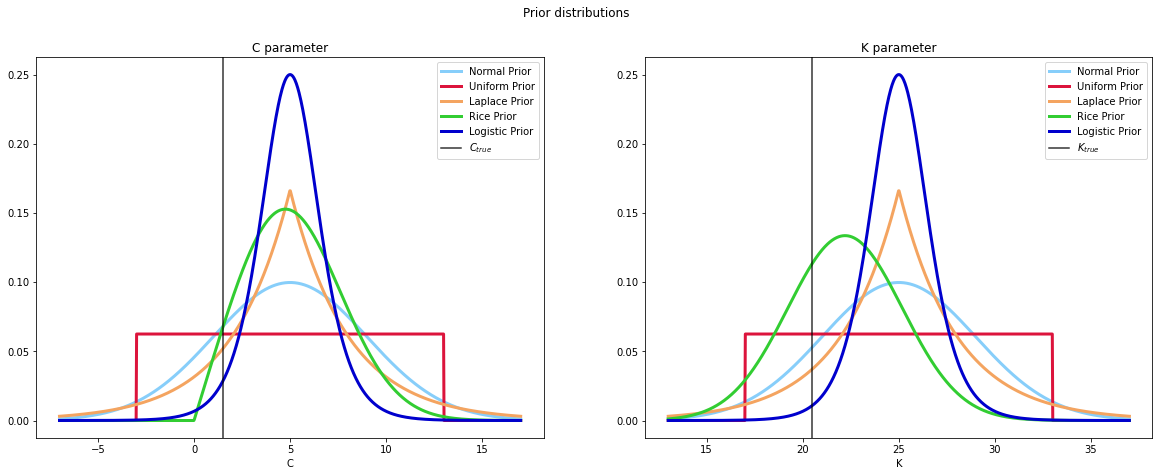

In [214]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
N = 1000
mu_prior = [5,25]
const = 12
c = np.linspace(mu_prior[0]-const, mu_prior[0]+const, 1000)
k = np.linspace(mu_prior[1]-const, mu_prior[1]+const, 1000)

f,ax = plt.subplots(1,2,figsize=(20,7))

pdf = st.norm.pdf(c, mu_prior[0], 4)
ax[0].plot(c, pdf, lw=3, color = cols[0], label=method_names[0])
pdf = np.zeros(N)
unif_const = 8
pdf[(c<mu_prior[0]+unif_const) & (c>mu_prior[0]-unif_const)] = 1.0/(2*unif_const)
ax[0].plot(c, pdf, lw=3, color = cols[1], label=method_names[1])
pdf = st.laplace.pdf(c, loc=mu_prior[0], scale=3)
ax[0].plot(c, pdf, lw=3, color = cols[2], label=method_names[2])
pdf = st.rice.pdf(c, 4 / 3, scale=3)
ax[0].plot(c, pdf, lw=3, color = cols[3], label=method_names[3])
pdf = st.logistic.pdf(c, loc=mu_prior[0], scale=1)
ax[0].plot(c, pdf, lw=3, color = cols[4], label=method_names[4])

pdf = st.norm.pdf(k, mu_prior[1], 4)
ax[1].plot(k, pdf, lw=3, color = cols[0], label=method_names[0])
pdf = np.zeros(N)
pdf[(k<mu_prior[1]+unif_const) & (k>mu_prior[1]-unif_const)] = 1.0/(2*unif_const)
ax[1].plot(k, pdf, lw=3, color = cols[1], label=method_names[1])
pdf = st.laplace.pdf(k, loc=mu_prior[1], scale=3)
ax[1].plot(k, pdf, lw=3, color = cols[2], label=method_names[2])
pdf = st.rice.pdf(k, 22 / 3, scale=3)
ax[1].plot(k, pdf, lw=3, color = cols[3], label=method_names[3])
pdf = st.logistic.pdf(k, loc=mu_prior[1], scale=1)
ax[1].plot(k, pdf, lw=3, color = cols[4], label=method_names[4])

ax[0].axvline(x=C_true,color="k",alpha = 0.8, label=r"$C_{true}$")
ax[1].axvline(x=K_true,color="k",alpha = 0.8, label=r"$K_{true}$")
ax[0].set_xlabel("C")
ax[1].set_xlabel("K")
ax[0].set_title("C parameter")
ax[1].set_title("K parameter")
for i in range(2):
  ax[i].legend()
f.suptitle("Prior distributions")
plt.show()
f.savefig(image_folder + "prior_distributions.png",bbox_inches='tight',dpi=400)

Create coarse and fine models

In [215]:
# Set prior parameters for multivariate Gaussian prior distribution.
mu_prior = np.array([5,25])
var_prior = [4,4]

# Set up models in pymc3 for each level - excluding finest model level
all_coarse_models = []
for i in range(len(datasets)):
  coarse_models = []
  for j in range(1, len(datasets[i])):
      with pm.Model() as model:
        # Multivariate normal prior.
        # theta = pm.MvNormal("theta", mu=mu_prior, cov=cov_prior, shape=(2,))
        if method_names[i] == 'Normal Prior':
          C = pm.Normal("C", mu_prior[0], sigma=var_prior[0])
          K = pm.Normal("K", mu_prior[1], sigma=var_prior[1])
        if method_names[i] == 'Uniform Prior':
          C = pm.Uniform("C",lower = mu_prior[0]-8, upper = mu_prior[0]+8)
          K = pm.Uniform("K",lower = mu_prior[1]-8, upper = mu_prior[1]+8)
        if method_names[i] == 'Laplace Prior':
          C = pm.Laplace("C", mu = mu_prior[0], b = 3)
          K = pm.Laplace("K", mu = mu_prior[1], b = 3)
        if method_names[i] == 'Rice Prior':
          C = pm.Rice("C", nu = mu_prior[0], sigma = 3)
          K = pm.Rice("K", nu = mu_prior[1], sigma = 3)
        if method_names[i] == 'Logistic Prior':
          C = pm.Logistic("C", mu = mu_prior[0], s = 1)
          K = pm.Logistic("K", mu = mu_prior[1], s = 1)
        # convert thetas to a tensor vector
        theta = tt.as_tensor_variable([C, K])

        # Use the Potential class to evaluate likelihood
        pm.Potential("likelihood", logls[i][j](theta))
      coarse_models.append(model)
  print(coarse_models)
  all_coarse_models.append(coarse_models)

all_fine_models = []
for i in range(len(datasets)):
  # Constructing the fine model
  with pm.Model() as fine_model:
    if method_names[i] == 'Normal Prior':
      C = pm.Normal("C", mu_prior[0], sigma=var_prior[0])
      K = pm.Normal("K", mu_prior[1], sigma=var_prior[1])
    if method_names[i] == 'Uniform Prior':
      C = pm.Uniform("C",lower = mu_prior[0]-8, upper = mu_prior[0]+8)
      K = pm.Uniform("K",lower = mu_prior[1]-8, upper = mu_prior[1]+8)
    if method_names[i] == 'Laplace Prior':
      C = pm.Laplace("C", mu = mu_prior[0], b = 3)
      K = pm.Laplace("K", mu = mu_prior[1], b = 3)
    if method_names[i] == 'Rice Prior':
      C = pm.Rice("C", nu = mu_prior[0], sigma = 3)
      K = pm.Rice("K", nu = mu_prior[1], sigma = 3)
    if method_names[i] == 'Logistic Prior':
      C = pm.Logistic("C", mu = mu_prior[0], s = 1)
      K = pm.Logistic("K", mu = mu_prior[1], s = 1)
    # convert thetas to a tensor vector
    theta = tt.as_tensor_variable([C, K])

    pm.Potential("likelihood", logls[i][0](theta))
  all_fine_models.append(fine_model)

Set MCMC parameters for inference

In [216]:
# Number of draws from the distribution
ndraws = 5000

# Number of independent chains.
nchains = 3

# Number of burn-in samples
nburn = 1000

# MLDA and Metropolis tuning parameters
tune = True
tune_interval = 100  # Set high to prevent tuning.
discard_tuning = True

# Subsampling rate for MLDA
nsub = [3,5]                     # MLDA draws nsub samples in the coarse chain and uses the last one as a proposal for the fine chain.

In [217]:
runtimes = []
all_traces = []
for fine_model,coarse_models in zip(all_fine_models,all_coarse_models):
  with fine_model:
    t_start = time.time()
    if len(coarse_models) == 0:
      step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)

      trace = pm.sample(
          draws=ndraws,
          step=step_metropolis,
          chains=nchains,
          tune=nburn,
          discard_tuned_samples=discard_tuning,
          random_seed=RANDOM_SEED,
          cores=10,
          )
    else:
      step_mlda = pm.MLDA(
          coarse_models=coarse_models, subsampling_rates=nsub[:len(coarse_models)],
          base_scaling = 0.5
          )
      trace = pm.sample(draws=ndraws, 
                        chains=nchains, 
                        tune=nburn, 
                        step=step_mlda, 
                        cores=10,
                        random_seed=RANDOM_SEED,
                        return_inferencedata=False,
                        )
    runtime = time.time() - t_start
  runtimes.append(runtime)
  all_traces.append(trace)

/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [K, C]


Sampling 3 chains for 1_000 tune and 5_000 draw iterations (3_000 + 15_000 draws total) took 100 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [K, C]


Sampling 3 chains for 1_000 tune and 5_000 draw iterations (3_000 + 15_000 draws total) took 94 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [K, C]


Sampling 3 chains for 1_000 tune and 5_000 draw iterations (3_000 + 15_000 draws total) took 94 seconds.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [K, C]


Sampling 3 chains for 1_000 tune and 5_000 draw iterations (3_000 + 15_000 draws total) took 95 seconds.
The number of effective samples is smaller than 10% for some parameters.
/usr/local/lib/python3.7/dist-packages/pymc3/step_methods/mlda.py:387: UserWarning: The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results.
  "The MLDA implementation in PyMC3 is still immature. You should be particularly critical of its results."
Multiprocess sampling (3 chains in 10 jobs)
MLDA: [K, C]


Sampling 3 chains for 1_000 tune and 5_000 draw iterations (3_000 + 15_000 draws total) took 68 seconds.
The number of effective samples is smaller than 25% for some parameters.


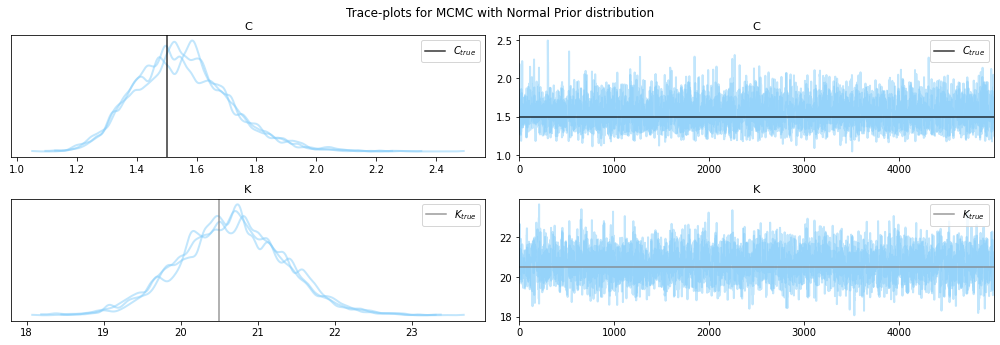

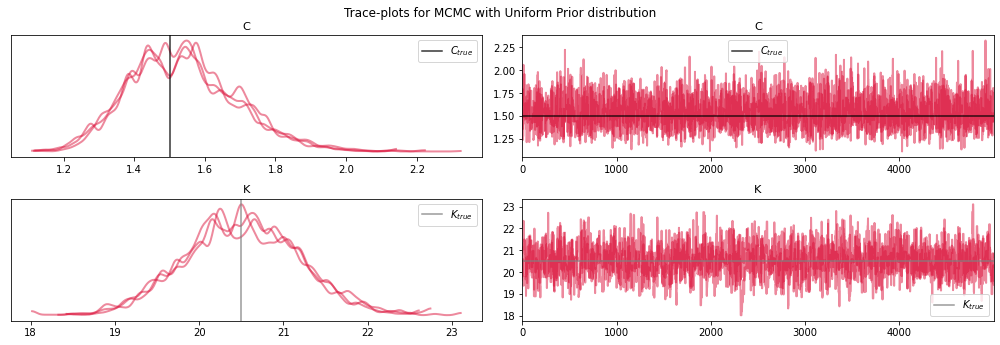

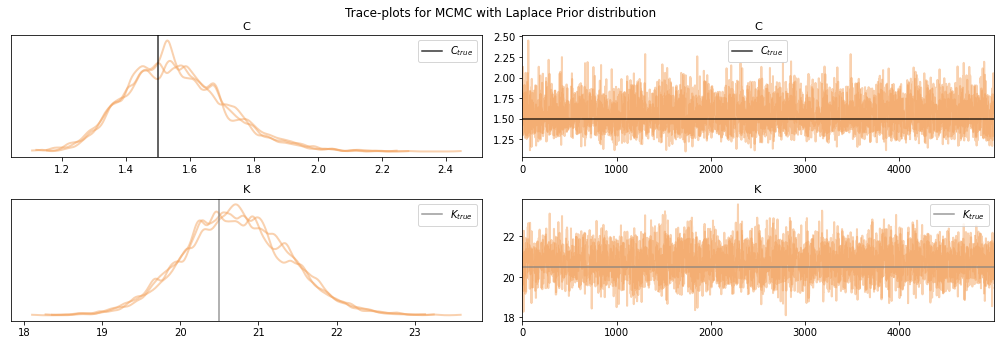

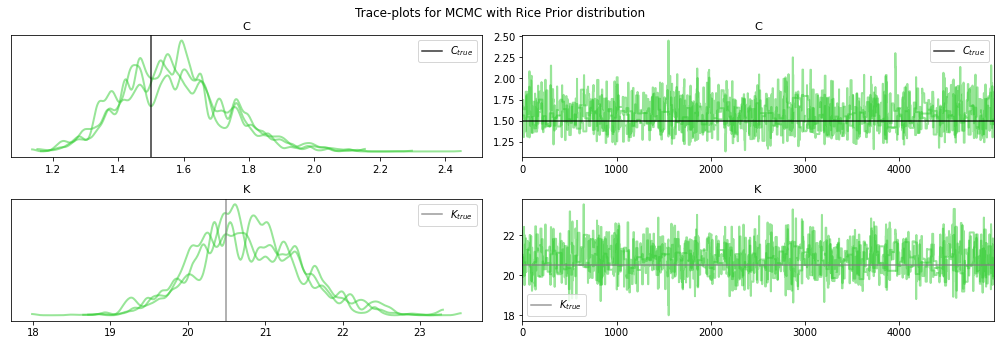

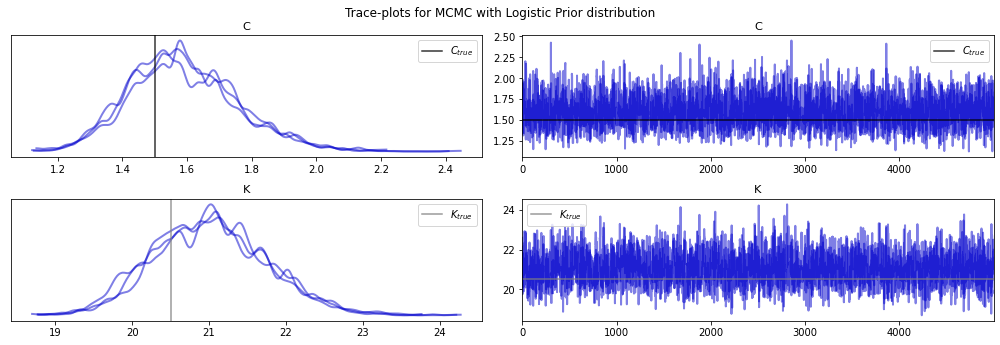

In [222]:
if not os.path.exists(image_folder+"trace_plots/"):
    os.makedirs(image_folder+"trace_plots/")

for i, (trace,fine_model) in enumerate(zip(all_traces,all_fine_models)):
  f,ax = plt.subplots(2,2, figsize=(14,5))
  with fine_model:
    chain_prop = {"color": [cols[i], cols[i]]}
    compact_prop={"lw": [2,2], "ls": ("-", "--"),"alpha":[0.5, 1.0]}
    az.plot_trace(trace, axes=ax, compact = True, combined=False, compact_prop=compact_prop, chain_prop=chain_prop)

    ax[0,0].axvline(x=C_true,color="k",alpha = 0.8, label=r"$C_{true}$")
    ax[1,0].axvline(x=K_true,color="grey",alpha = 0.8, label=r"$K_{true}$")
    ax[0,1].axhline(y=C_true,color="k",alpha = 0.8, label=r"$C_{true}$")
    ax[1,1].axhline(y=K_true,color="grey",alpha = 0.8, label=r"$K_{true}$")
    for k in range(2):
      ax[k,0].legend()
      ax[k,1].legend()
    f.suptitle("Trace-plots for MCMC with " + method_names[i] + " distribution")
    f.tight_layout(rect=[0, 0.03, 1, 0.97])
  f.savefig(image_folder + "trace_plots/" + method_names[i]+".png",bbox_inches='tight',dpi=300)
  plt.show()

In [219]:
theta_hats = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
    print(f"\n{method_names[i]} Sampler:\n","runtime : ", runtimes[i])
    display(az.summary(trace))

    theta_hats.append([np.mean(trace['C']), np.mean(trace['K'])])


Normal Prior Sampler:
 runtime :  103.13186383247375


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
C   1.553  0.158   1.266    1.849  ...    0.002    4485.0    5566.0    1.0
K  20.661  0.688  19.350   21.929  ...    0.009    3069.0    3801.0    1.0

[2 rows x 9 columns]


Uniform Prior Sampler:
 runtime :  98.57769751548767


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
C   1.538  0.152   1.273    1.828  ...    0.002    2911.0    3254.0    1.0
K  20.511  0.688  19.214   21.772  ...    0.014    1175.0    1503.0    1.0

[2 rows x 9 columns]


Laplace Prior Sampler:
 runtime :  97.55587005615234


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
C   1.557  0.158   1.272    1.851  ...    0.002    3591.0    4485.0    1.0
K  20.716  0.675  19.447   21.972  ...    0.008    3172.0    3985.0    1.0

[2 rows x 9 columns]


Rice Prior Sampler:
 runtime :  99.65929388999939


mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
C   1.571  0.159   1.276    1.860  ...    0.004     940.0    1205.0    1.0
K  20.781  0.690  19.465   22.039  ...    0.016     900.0     960.0    1.0

[2 rows x 9 columns]


Logistic Prior Sampler:
 runtime :  69.80072665214539


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat
C   1.59  0.168   1.291    1.916      0.003    0.002    3124.0    3927.0    1.0
K  21.02  0.736  19.667   22.393      0.015    0.010    2499.0    3621.0    1.0

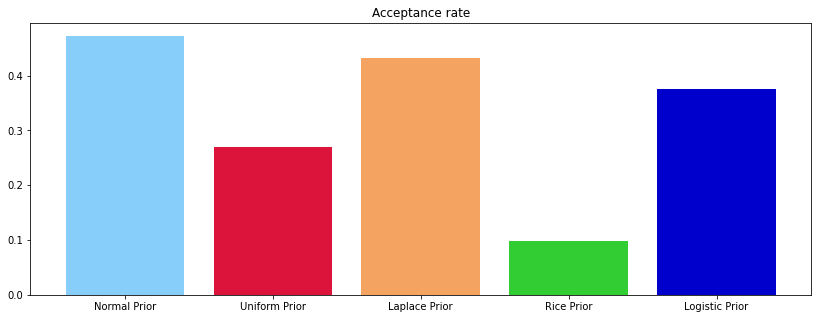

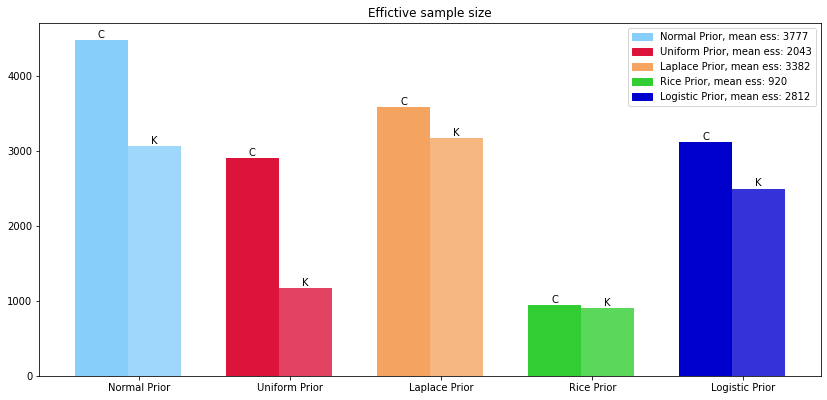

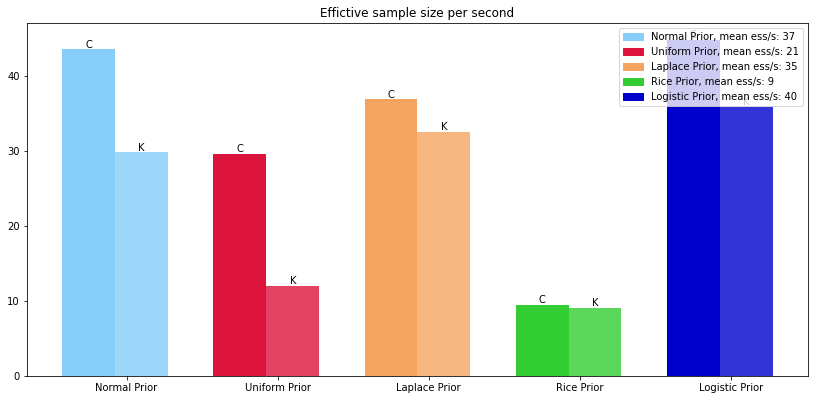

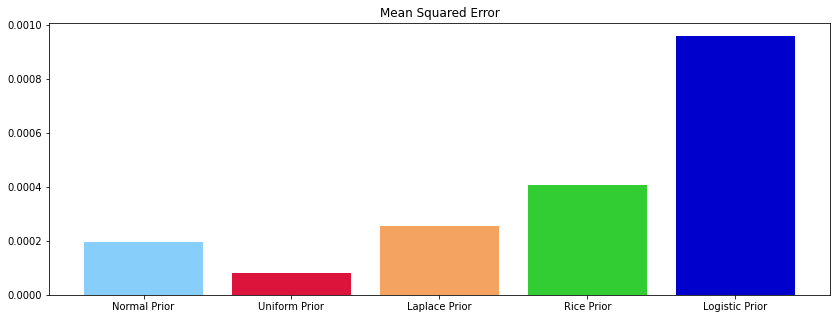

In [220]:
# Model predictions
error = []
for theta_hat in theta_hats:
  u_hat = pendulum_analytical_solution(theta_hat[0],theta_hat[1],t)
  mse = np.mean((u_true-u_hat)**2)
  error.append(mse)

# Get some more statistics.
acc = []
ess = []
ess_n = []
performances = []
for i, trace in enumerate(all_traces):
  with all_fine_models[i]:
        acc.append(trace.get_sampler_stats("accepted").mean())
        ess.append(np.array(az.ess(trace).to_array()))
        ess_n.append(ess[i] / len(trace) / trace.nchains)
        performances.append(ess[i] / runtimes[i])
ess = np.array(ess)
ess_n = np.array(ess_n)
performances = np.array(performances)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,acc, color = cols)
ax.set_title("Acceptance rate")
plt.show()
f.savefig(image_folder + "acceptance_rate.png",bbox_inches='tight',dpi=300)

N = ess.shape[0]
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars
labels = ["C"]*N + ["K"]*N
handles = [plt.Rectangle((0,0),1,1, color=cols[i]) for i in range(len(method_names))]

f,ax = plt.subplots(figsize=(14,5))
names = [method_names[i] + ", mean ess: " + str(round(e)) for i,e in enumerate(np.mean(ess,axis=1))]
ax.bar(ind,ess[:,0],width, color = cols)
ax.bar(ind+width,ess[:,1],width, color = cols, alpha=0.8)
ax.set_xticks(ind + 0.25)
ax.set_title('Effictive sample size')
ax.set_xticklabels(method_names)
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
ax.legend(handles, names)
f.subplots_adjust(bottom=-0.1)
plt.show()
f.savefig(image_folder + "ess.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
names = [method_names[i] + ", mean ess/s: " + str(round(e)) for i,e in enumerate(np.mean(performances,axis=1))]
ax.bar(ind,performances[:,0],width, color = cols)
ax.bar(ind+width,performances[:,1],width, color = cols, alpha=0.8)
ax.set_xticks(ind + 0.25)
ax.set_title('Effictive sample size per second')
ax.set_xticklabels(method_names)
rects = ax.patches
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 0, label, ha="center", va="bottom"
    )
ax.legend(handles, names)
f.subplots_adjust(bottom=-0.1)
plt.show()
f.savefig(image_folder + "performance.png",bbox_inches='tight',dpi=300)

f,ax = plt.subplots(figsize=(14,5))
ax.bar(method_names,error, color = cols)
ax.set_title("Mean Squared Error")
# ax.set_ylim([0,0.001])
plt.show()
f.savefig(image_folder + "mse_error.png",bbox_inches='tight',dpi=300)

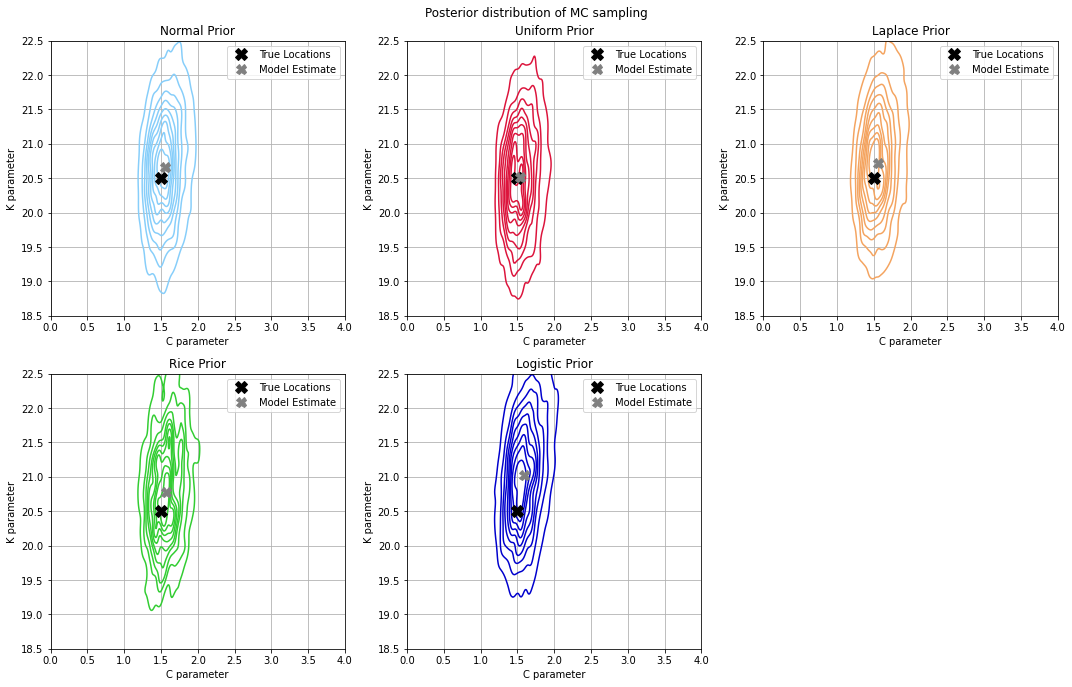

In [221]:
limC = [0,4]
limK = [18.5,22.5]

N,M = (2,3)
f,ax = plt.subplots(N,M, figsize=(5*M,5*N))
ax = ax.flatten()
for i, trace in enumerate(all_traces):
  sn.kdeplot(x = trace['C'], y = trace['K'],ax = ax[i], color = cols[i])
  # sn.kdeplot(x = trace['theta'][:,0], y = trace['theta'][:,1],ax = ax[i], fill = True, cmap="mako")
  ax[i].set_xlabel('C parameter', fontsize=10)
  ax[i].set_ylabel('K parameter', fontsize=10)
  ax[i].set_title(method_names[i])
  ax[i].grid('on')
  ax[i].set_xlim(limC)
  ax[i].set_ylim(limK)
  ax[i].plot(C_true,K_true,"Xk", alpha=1.0, markersize=12, label="True Locations")
  ax[i].plot(theta_hats[i][0],theta_hats[i][1],"X",color="gray", alpha=1.0, markersize=10, label="Model Estimate")
  ax[i].legend()
for j in range(i+1,N*M):
  ax[j].set_visible(False)
f.suptitle("Posterior distribution of MC sampling")
f.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()
f.savefig(image_folder + "posterior.png",bbox_inches='tight',dpi=300)

# Download figures

In [223]:
!zip -r spring_problem_analytical_figures.zip spring_problem_analytical_figures/ &> /dev/null

In [224]:
from google.colab import files
files.download("spring_problem_analytical_figures.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>